In [1]:
!pip install filterpy
  # Install scikit-learn to install datasets as dependencies
!pip install pynwb
!pip install hmmlearn

In [44]:
from pynwb import NWBHDF5IO

# Load NWB file
io = NWBHDF5IO('/content/drive/MyDrive/MLNBD/ML_Neuro/Original_Data/sub-Jenkins_ses-small_desc-train_behavior+ecephys.nwb', 'r')
nwbfile = io.read()


/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [45]:

# Access behavior data
hand_pos = nwbfile.processing['behavior'].data_interfaces['hand_pos']
hand_vel = nwbfile.processing['behavior'].data_interfaces['hand_vel']
eye_pos = nwbfile.processing['behavior'].data_interfaces['eye_pos']
cursor_pos = nwbfile.processing['behavior'].data_interfaces['cursor_pos']
trials = nwbfile.intervals['trials']



In [46]:
type(trials["trial_type"][0])

numpy.int64

In [47]:
import numpy as np

trial_data = []
for trial_idx in range(len(trials)):
    # Extract trial-specific information
    trial_type = int(trials['trial_type'][trial_idx])
    start_time = trials['start_time'][trial_idx]
    stop_time = trials['stop_time'][trial_idx]
    target_pos = trials['target_pos'][trial_idx]
    barrier_pos = trials['barrier_pos'][trial_idx]

    # Filter data for this trial interval
    trial_hand_pos = hand_pos.data[np.logical_and(
        hand_pos.timestamps >= start_time,
        hand_pos.timestamps <= stop_time
    )]
    trial_hand_vel = hand_vel.data[np.logical_and(
        hand_vel.timestamps >= start_time,
        hand_vel.timestamps <= stop_time
    )]
    trial_eye_pos = eye_pos.data[np.logical_and(
        eye_pos.timestamps >= start_time,
        eye_pos.timestamps <= stop_time
    )]
    trial_cursor_pos = cursor_pos.data[np.logical_and(
        cursor_pos.timestamps >= start_time,
        cursor_pos.timestamps <= stop_time
    )]

    # Ensure target_pos and barrier_pos are extracted properly
    trial_target_pos = np.array(target_pos)  # target_pos should already match trial indices
    trial_barrier_pos = np.array(barrier_pos)  # barrier_pos should already match trial indices

    # Handle missing data or empty arrays
    trial_hand_pos = trial_hand_pos.tolist() if trial_hand_pos.size > 0 else []
    trial_hand_vel = trial_hand_vel.tolist() if trial_hand_vel.size > 0 else []
    trial_eye_pos = trial_eye_pos.tolist() if trial_eye_pos.size > 0 else []
    trial_cursor_pos = trial_cursor_pos.tolist() if trial_cursor_pos.size > 0 else []

    # Store trial data
    trial_data.append({
        "trial_id": trial_idx,
        "start_time": start_time,
        "stop_time": stop_time,
        "hand_pos": trial_hand_pos,
        "hand_vel": trial_hand_vel,
        "eye_pos": trial_eye_pos,
        "cursor_pos": trial_cursor_pos,
        "target_pos": trial_target_pos.tolist(),
        "barrier_pos": trial_barrier_pos.tolist(),
        "trial_type": trial_type
    })

# Inspect trial data (optional)
print(f"Processed {len(trial_data)} trials.")
print("Example Trial Data:", trial_data[0])


Processed 100 trials.
Example Trial Data: {'trial_id': 0, 'start_time': 0.0, 'stop_time': 3.421, 'hand_pos': [[-4.069391463135143, -31.888892887357343], [-4.066940743020508, -31.90072273920979], [-4.064521096636136, -31.912980443054277], [-4.062168204665466, -31.92550113590004], [-4.059822094964986, -31.93811222659131], [-4.0575018514898025, -31.950827609315958], [-4.055336235211395, -31.963551494181534], [-4.053194103875741, -31.976226125096254], [-4.051181679682036, -31.98881230124836], [-4.049442752983631, -32.001309261157814], [-4.047961747944242, -32.01360252720889], [-4.046694205371443, -32.025667403302066], [-4.045650269799997, -32.037435315863426], [-4.044949639691285, -32.048996963288324], [-4.044444994545661, -32.06038109964912], [-4.044221847442087, -32.071510263127536], [-4.044360219183204, -32.08239796878024], [-4.044796222150323, -32.09320891472272], [-4.045825880771241, -32.10392623957359], [-4.047124621023265, -32.11453707021373], [-4.048655874392575, -32.12509484159441

In [38]:
trial_data[2]["trial_type"]

4

In [48]:
units = nwbfile.units  # Access the units table
spike_times = units['spike_times']  # Spike times for each unit
obs_intervals = units['obs_intervals']  # Observation intervals for each unit


In [49]:
trial_spike_data = []

for trial_idx in range(len(trials)):
    # Get trial start/stop time
    start_time = trials['start_time'][trial_idx]
    stop_time = trials['stop_time'][trial_idx]

    # Filter spike times for this trial
    trial_spikes = []
    for unit_idx in range(len(units)):
        # Get spike times for this unit
        unit_spike_times = spike_times[unit_idx]

        # Filter spike times within the trial interval
        trial_unit_spikes = unit_spike_times[
            (unit_spike_times >= start_time) & (unit_spike_times <= stop_time)
        ]

        # Append the unit-specific spikes for this trial
        trial_spikes.append(trial_unit_spikes.tolist())

    # Store trial-level spike data
    trial_spike_data.append({
        "trial_id": trial_idx,
        "start_time": start_time,
        "stop_time": stop_time,
        "spike_data": trial_spikes  # List of spike times for all units
    })


In [50]:
import json
for i, trial in enumerate(trial_data):
    trial['spike_data'] = trial_spike_data[i]['spike_data']

# Save combined data
with open('/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json', 'w') as f:
    json.dump(trial_data, f)


In [19]:
with open("output.txt", "w") as file:
    # Redirect the print output to the file
    print(trial_data[0], file=file)

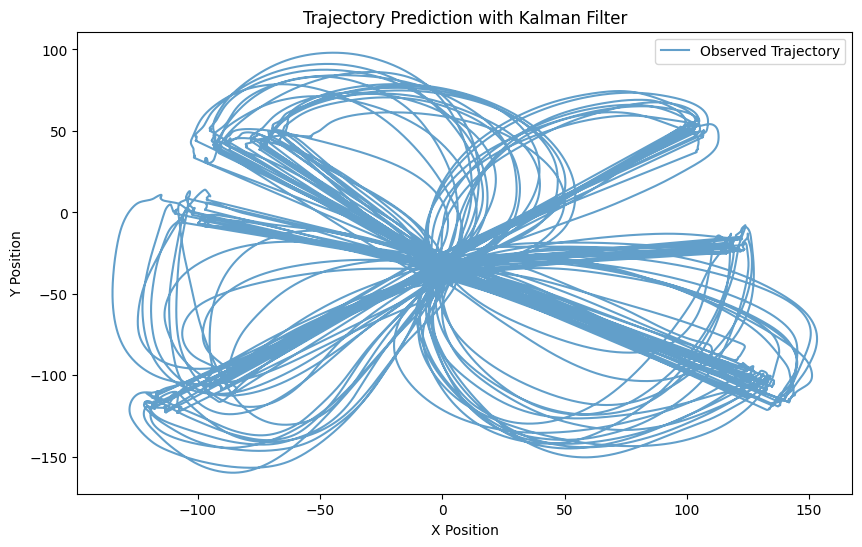

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Preprocess data: Extract hand positions from unfiltered data
def preprocess_hand_pos(unfiltered_data):
    # Extract observations (e.g., hand_pos from trials)
    observations = []
    for trial in unfiltered_data:
        hand_pos = np.array(trial.get("hand_pos", []))  # Extract hand positions
        if hand_pos.shape[0] > 0:  # Skip trials with no data
            observations.append(hand_pos)
    return np.concatenate(observations, axis=0)  # Combine all trials into one array

# Load unfiltered data (replace with your actual JSON file path)
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    unfiltered_data = json.load(f)

# Extract hand positions
observations = preprocess_hand_pos(unfiltered_data)

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=2)  # State and observation dimensions (e.g., x, y)

# Define Kalman Filter matrices
kf.F = np.eye(2)  # Transition matrix
kf.H = np.eye(2)  # Observation matrix
kf.P = np.eye(2) * 500  # Covariance matrix
kf.R = np.eye(2) * 5    # Measurement noise
kf.Q = np.eye(2) * 0.1  # Process noise

# Initial state
kf.x = np.zeros(2)

# Apply the filter to smooth data
smoothed_states = []
for obs in observations:
    kf.predict()
    kf.update(obs)
    smoothed_states.append(kf.x.copy())

smoothed_states = np.array(smoothed_states)

# Predict future states
future_steps = 50
predicted_states = []
current_state = kf.x.copy()

for _ in range(future_steps):
    kf.predict()
    predicted_states.append(kf.x.copy())

predicted_states = np.array(predicted_states)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(observations[:, 0], observations[:, 1], label="Observed Trajectory", alpha=0.7)
# plt.plot(smoothed_states[:, 0], smoothed_states[:, 1], label="Smoothed Trajectory", alpha=0.7)
# plt.plot(predicted_states[:, 0], predicted_states[:, 1], label="Predicted Trajectory", linestyle="--")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction with Kalman Filter")
plt.show()


Mean Squared Error on Test Set: 7264.5929


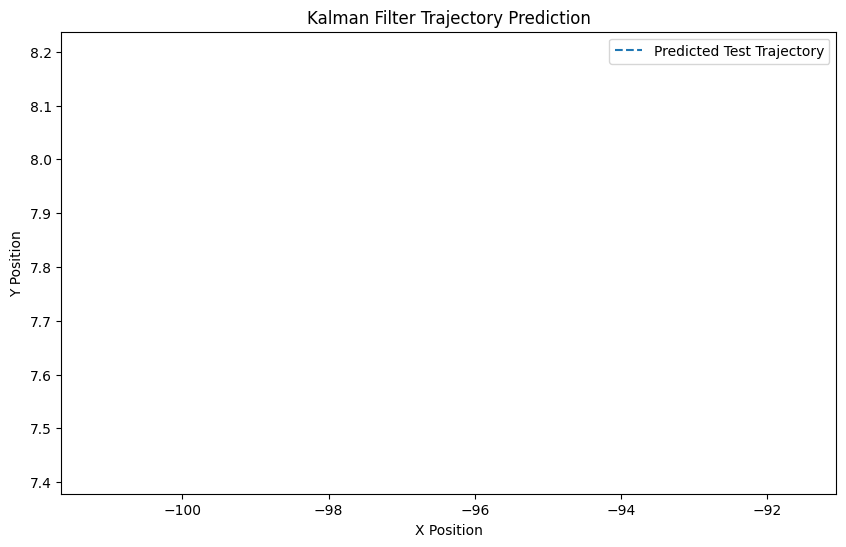

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Function to group data by trial IDs and times
def group_data_by_trials(unfiltered_data):
    trials = []
    for trial in unfiltered_data:
        trial_id = trial.get("trial_id", None)  # Extract trial ID
        start_time = trial.get("start_time", None)  # Extract start time
        hand_pos = np.array(trial.get("hand_pos", []))  # Extract hand positions

        if trial_id is not None and start_time is not None and hand_pos.shape[0] > 0:
            trials.append({
                "trial_id": trial_id,
                "start_time": start_time,
                "hand_pos": hand_pos
            })
    return sorted(trials, key=lambda x: x["start_time"])  # Sort by start time

# Load unfiltered data (replace with your actual JSON file path)
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    unfiltered_data = json.load(f)

# Group and sort trials by time
trials = group_data_by_trials(unfiltered_data)

# Split into train and test sets based on trial count
split_ratio = 0.8
split_idx = int(len(trials) * split_ratio)

train_trials = trials[:split_idx]
test_trials = trials[split_idx:]

# Combine data from train and test trials
train_data = np.concatenate([trial["hand_pos"] for trial in train_trials], axis=0)
test_data = np.concatenate([trial["hand_pos"] for trial in test_trials], axis=0)

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=2)  # State and observation dimensions (e.g., x, y)

# Define Kalman Filter matrices
kf.F = np.eye(2)  # Transition matrix
kf.H = np.eye(2)  # Observation matrix
kf.P = np.eye(2) * 500  # Covariance matrix
kf.R = np.eye(2) * 5    # Measurement noise
kf.Q = np.eye(2) * 0.1  # Process noise

# Initial state
kf.x = np.zeros(2)

# Train on the training set
smoothed_train_states = []
for obs in train_data:
    kf.predict()
    kf.update(obs)
    smoothed_train_states.append(kf.x.copy())

# Validate on the test set
predicted_test_states = []
for obs in test_data:
    kf.predict()
    predicted_test_states.append(kf.x.copy())  # Predict without updating

predicted_test_states = np.array(predicted_test_states)

# Compute error metrics
mse = mean_squared_error(test_data, predicted_test_states)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
# plt.plot(train_data[:, 0], train_data[:, 1], label="Training Data", alpha=0.7)
# plt.plot(test_data[:, 0], test_data[:, 1], label="Test Data", alpha=0.7)
plt.plot(predicted_test_states[:, 0], predicted_test_states[:, 1], label="Predicted Test Trajectory", linestyle="--")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Kalman Filter Trajectory Prediction")
plt.show()


In [ ]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("First Train Observation:", train_data[0])
print("First Test Observation:", test_data[0])


Train Data Shape: (229420, 2)
Test Data Shape: (58290, 2)
First Train Observation: [ -4.06939146 -31.88889289]
First Test Observation: [  0.96226634 -27.8929647 ]


Train Data Shape: (229420, 2)
Test Data Shape: (58290, 2)
First Predicted State: [-96.35368629   7.80783844]
Mean Squared Error on Test Set: 7264.5929


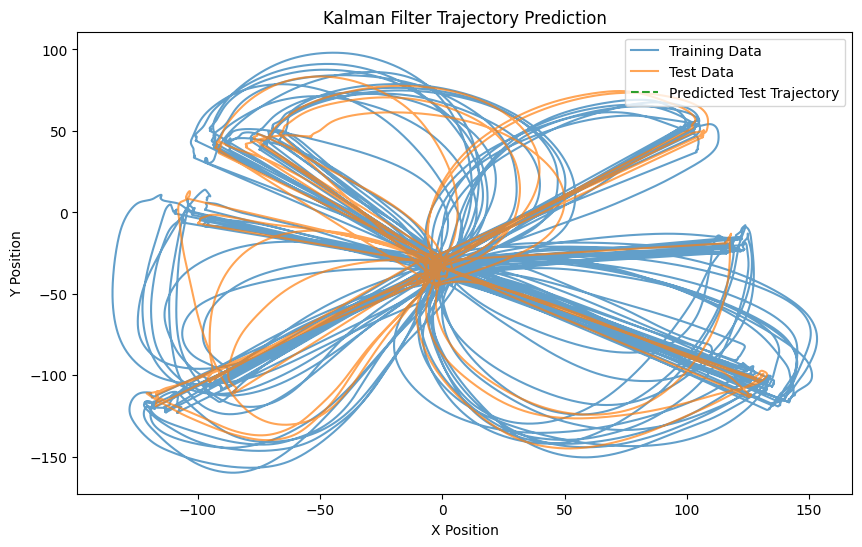

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Function to group data by trial IDs and times
def group_data_by_trials(unfiltered_data):
    trials = []
    for trial in unfiltered_data:
        trial_id = trial.get("trial_id", None)  # Extract trial ID
        start_time = trial.get("start_time", None)  # Extract start time
        hand_pos = np.array(trial.get("hand_pos", []))  # Extract hand positions

        if trial_id is not None and start_time is not None and hand_pos.shape[0] > 0:
            trials.append({
                "trial_id": trial_id,
                "start_time": start_time,
                "hand_pos": hand_pos
            })
    return sorted(trials, key=lambda x: x["start_time"])  # Sort by start time

# Load unfiltered data (replace with your actual JSON file path)
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    unfiltered_data = json.load(f)

# Group and sort trials by time
trials = group_data_by_trials(unfiltered_data)

# Split into train and test sets based on trial count
split_ratio = 0.8
split_idx = int(len(trials) * split_ratio)

train_trials = trials[:split_idx]
test_trials = trials[split_idx:]

# Combine data from train and test trials
train_data = np.concatenate([trial["hand_pos"] for trial in train_trials], axis=0)
test_data = np.concatenate([trial["hand_pos"] for trial in test_trials], axis=0)

# Debug: Verify train and test data
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=2)  # State and observation dimensions (e.g., x, y)

# Define Kalman Filter matrices
kf.F = np.eye(2)  # Transition matrix
kf.H = np.eye(2)  # Observation matrix
kf.P = np.eye(2) * 500  # Covariance matrix
kf.R = np.eye(2) * 5    # Measurement noise
kf.Q = np.eye(2) * 0.1  # Process noise
kf.x = train_data[0]    # Initialize state with the first observation

# Train on the training set
smoothed_train_states = []
for obs in train_data:
    kf.predict()
    kf.update(obs)
    smoothed_train_states.append(kf.x.copy())

# Validate on the test set
predicted_test_states = []
for obs in test_data:
    kf.predict()
    predicted_test_states.append(kf.x.copy())  # Predict without updating

predicted_test_states = np.array(predicted_test_states)

# Debug: Check predicted states
if len(predicted_test_states) > 0:
    print("First Predicted State:", predicted_test_states[0])
else:
    print("No Predicted States")

# Compute error metrics
if len(predicted_test_states) == len(test_data):
    mse = mean_squared_error(test_data, predicted_test_states)
    print(f"Mean Squared Error on Test Set: {mse:.4f}")
else:
    print("Mismatch in predicted and actual test data length")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train_data[:, 0], train_data[:, 1], label="Training Data", alpha=0.7)
plt.plot(test_data[:, 0], test_data[:, 1], label="Test Data", alpha=0.7)
plt.plot(predicted_test_states[:, 0], predicted_test_states[:, 1], label="Predicted Test Trajectory", linestyle="--")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Kalman Filter Trajectory Prediction")
plt.show()


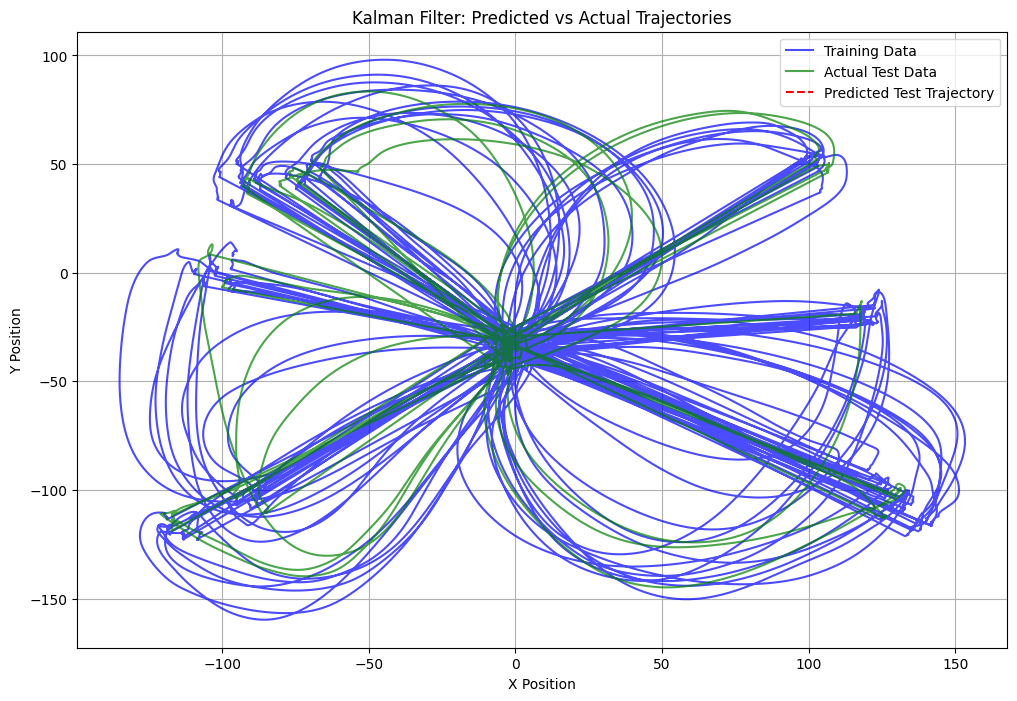

In [ ]:
# Plot results
plt.figure(figsize=(12, 8))

# Plot the training trajectory
plt.plot(train_data[:, 0], train_data[:, 1], label="Training Data", alpha=0.7, color="blue")

# Plot the actual test trajectory
plt.plot(test_data[:, 0], test_data[:, 1], label="Actual Test Data", alpha=0.7, color="green")

# Plot the predicted test trajectory
if len(predicted_test_states) > 0:
    plt.plot(predicted_test_states[:, 0], predicted_test_states[:, 1], label="Predicted Test Trajectory", linestyle="--", color="red")
else:
    print("No predicted states available for plotting.")

# Add labels, legend, and title
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Kalman Filter: Predicted vs Actual Trajectories")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error
import json

# Load the JSON file (replace with the actual file path)
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    data = json.load(f)

# Extract spike data and trajectory (hand_pos) from the JSON
def preprocess_data(data, max_length=None):
    spike_data = []
    trajectory_data = []

    # Determine maximum sequence length if not provided
    if max_length is None:
        max_length = max((len(trial.get("spike_data", [])) for trial in data), default=0)

    for trial_idx, trial in enumerate(data):
        if "spike_data" not in trial or "hand_pos" not in trial:
            print(f"Skipping trial {trial_idx}: Missing 'spike_data' or 'hand_pos'")
            continue

        spikes = trial["spike_data"]
        hand_pos = trial["hand_pos"]

        if not isinstance(spikes, list) or not isinstance(hand_pos, list):
            print(f"Skipping trial {trial_idx}: Invalid data types (spike_data: {type(spikes)}, hand_pos: {type(hand_pos)})")
            continue

        spikes = np.array(spikes, dtype=object)
        hand_pos = np.array(hand_pos, dtype=object)

        if len(spikes) != len(hand_pos):
            print(f"Skipping trial {trial_idx}: Length mismatch (spikes: {len(spikes)}, hand_pos: {len(hand_pos)})")
            continue

        # Pad or truncate to the maximum length
        padded_spikes = np.zeros((max_length, spikes.shape[1]))
        padded_spikes[:len(spikes), :] = spikes

        padded_hand_pos = np.zeros((max_length, hand_pos.shape[1]))
        padded_hand_pos[:len(hand_pos), :] = hand_pos

        spike_data.append(padded_spikes)
        trajectory_data.append(padded_hand_pos)

    # Check if any valid trials were processed
    if not spike_data or not trajectory_data:
        raise ValueError("No valid trials found. Check your data structure.")

    # Concatenate all trials into one array
    return np.concatenate(spike_data, axis=0), np.concatenate(trajectory_data, axis=0)





# Preprocess data
spike_data, trajectory_data = preprocess_data(data)

# Split data into train and test sets (80-20 split)
split_ratio = 0.8
split_idx = int(len(spike_data) * split_ratio)

spike_train = spike_data[:split_idx]
trajectory_train = trajectory_data[:split_idx]
spike_test = spike_data[split_idx:]
trajectory_test = trajectory_data[split_idx:]

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=spike_train.shape[1] + 2, dim_z=2)  # Include spikes and trajectory states

# Define Kalman Filter matrices
kf.F = np.eye(spike_train.shape[1] + 2)  # Transition matrix
kf.H = np.zeros((2, spike_train.shape[1] + 2))  # Observation matrix
kf.H[:, -2:] = np.eye(2)  # Map trajectory state to observed data
kf.P = np.eye(spike_train.shape[1] + 2) * 500  # Covariance matrix
kf.R = np.eye(2) * 5    # Measurement noise
kf.Q = np.eye(spike_train.shape[1] + 2) * 0.1  # Process noise
kf.x = np.zeros(spike_train.shape[1] + 2)  # Initial state

# Train on the training set
smoothed_train_states = []
for i in range(len(spike_train)):
    kf.predict()
    combined_input = np.hstack([spike_train[i], trajectory_train[i]])  # Combine spike and trajectory
    kf.update(combined_input)
    smoothed_train_states.append(kf.x.copy())

# Validate on the test set
predicted_test_states = []
for i in range(len(spike_test)):
    kf.predict()
    predicted_state = kf.x[-2:]  # Extract trajectory predictions
    predicted_test_states.append(predicted_state)

predicted_test_states = np.array(predicted_test_states)

# Compute error metrics
mse = mean_squared_error(trajectory_test, predicted_test_states)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(trajectory_train[:, 0], trajectory_train[:, 1], label="Training Trajectory", alpha=0.7, color="blue")
plt.plot(trajectory_test[:, 0], trajectory_test[:, 1], label="Actual Test Trajectory", alpha=0.7, color="green")
plt.plot(predicted_test_states[:, 0], predicted_test_states[:, 1], label="Predicted Test Trajectory", linestyle="--", color="red")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Kalman Filter with Neural Data for Trajectory Prediction")
plt.grid(True)
plt.show()


**CORRECT FROM HERE**

In [3]:
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    data = json.load(f)

In [4]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# Example of parsing one dictionary from your data
# Assuming `data` is a list of dictionaries from your dataset


# Extracting relevant fields
hand_positions = np.array(data[0]["hand_pos"])  # Shape (T, 2) where T is the number of time steps
spike_data = np.array(data[0]["spike_data"])    # Shape (T, N) where N is the number of neurons

# Kalman Filter Initialization
kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

# State Transition Matrix (F)
kf.F = np.array([
    [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
    [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
    [0, 0, 1, 0],  # vx_t = vx_(t-1)
    [0, 0, 0, 1],  # vy_t = vy_(t-1)
])

# Measurement Function (H)
kf.H = np.array([
    [1, 0, 0, 0],  # Measure x
    [0, 1, 0, 0],  # Measure y
])

# Covariance Matrix (P)
kf.P = np.eye(4) * 1000  # High initial uncertainty

# Process Noise (Q)
kf.Q = np.eye(4) * 0.1  # Small process noise

# Measurement Noise (R)
kf.R = np.eye(2) * 10  # Measurement noise

# Initial State (x)
kf.x = np.array([hand_positions[0, 0], hand_positions[0, 1], 0, 0])  # Start with initial position and zero velocity

# Running the Kalman Filter
filtered_positions = []
for position in hand_positions:
    kf.predict()
    kf.update(position)  # Use hand position as measurement
    filtered_positions.append(kf.x[:2])  # Append only x, y positions

filtered_positions = np.array(filtered_positions)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(hand_positions[:, 0], hand_positions[:, 1], label="True Trajectory", linestyle="--", alpha=0.7)
plt.plot(filtered_positions[:, 0], filtered_positions[:, 1], label="Kalman Filtered Trajectory", linewidth=2)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction with Kalman Filter")
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (142,) + inhomogeneous part.

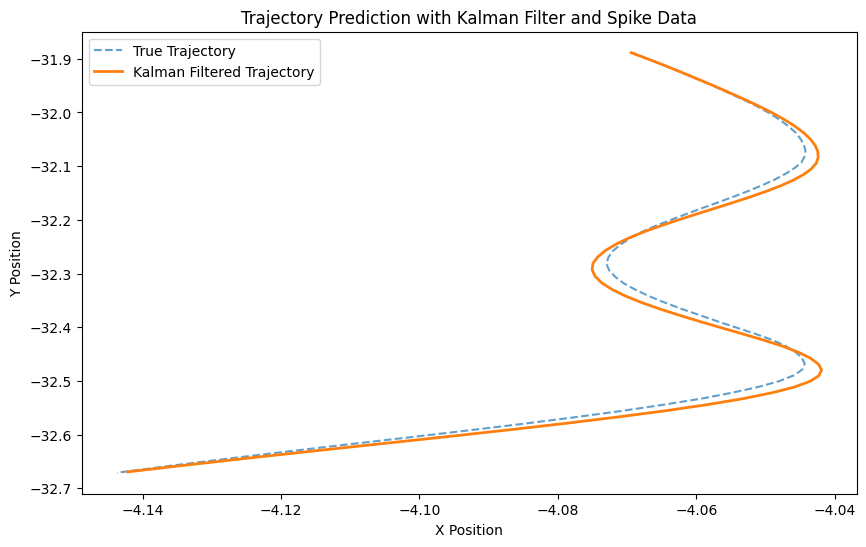

In [5]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt



# Extracting relevant fields
hand_positions = np.array(data[0]["hand_pos"])  # Shape (T, 2)
spike_data = data[0]["spike_data"]             # List of 142 lists of spike times

# Parameters for discretization
bin_size = 0.05  # Time bin size (e.g., 50ms)
num_bins = int((data[0]["stop_time"] - data[0]["start_time"]) / bin_size)

# Preprocess spike data into fixed bins
spike_features = np.zeros((len(spike_data), num_bins))  # Shape (142 neurons, num_bins)
for neuron_idx, spikes in enumerate(spike_data):
    # Histogram the spike times for each neuron
    binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, data[0]["stop_time"], num_bins + 1))
    spike_features[neuron_idx, :] = binned_spikes

# Combine spike features across neurons into one feature per bin
spike_summary = np.sum(spike_features, axis=0)  # Shape (num_bins,)

# Align hand positions to the number of bins
hand_positions = hand_positions[:num_bins]

# Kalman Filter Initialization
kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

# State Transition Matrix (F)
kf.F = np.array([
    [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
    [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
    [0, 0, 1, 0],  # vx_t = vx_(t-1)
    [0, 0, 0, 1],  # vy_t = vy_(t-1)
])

# Measurement Function (H)
kf.H = np.array([
    [1, 0, 0, 0],  # Measure x
    [0, 1, 0, 0],  # Measure y
])

# Covariance Matrix (P)
kf.P = np.eye(4) * 1000  # High initial uncertainty

# Process Noise (Q)
kf.Q = np.eye(4) * 0.1  # Small process noise

# Measurement Noise (R)
kf.R = np.eye(2) * 10  # Measurement noise

# Initial State (x)
kf.x = np.array([hand_positions[0, 0], hand_positions[0, 1], 0, 0])  # Start with initial position and zero velocity

# Running the Kalman Filter
filtered_positions = []
for i, position in enumerate(hand_positions):
    kf.predict()
    kf.update(position)  # Use hand position as measurement
    filtered_positions.append(kf.x[:2])  # Append only x, y positions

filtered_positions = np.array(filtered_positions)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(hand_positions[:, 0], hand_positions[:, 1], label="True Trajectory", linestyle="--", alpha=0.7)
plt.plot(filtered_positions[:, 0], filtered_positions[:, 1], label="Kalman Filtered Trajectory", linewidth=2)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction with Kalman Filter and Spike Data")
plt.show()


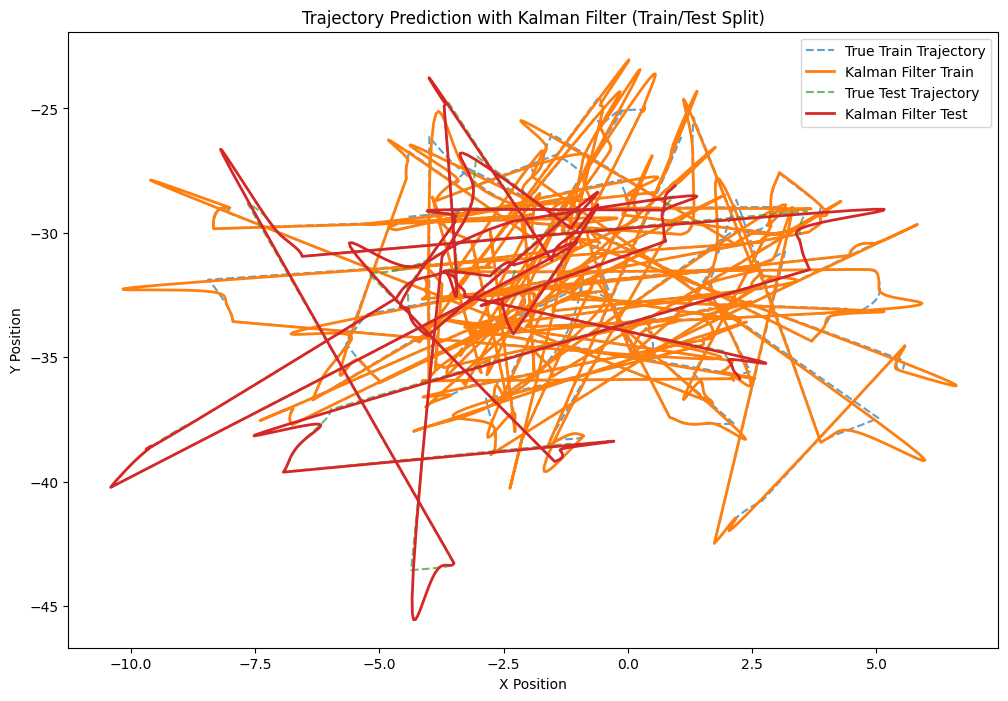

In [ ]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Example dataset with multiple trials
# Replace this with your actual data
# data = [
#     {
#         "trial_id": 0,
#         "start_time": 0.0,
#         "stop_time": 3.421,
#         "hand_pos": [[-4.06, -31.88], [-4.06, -31.90], ...],  # Truncated for example
#         "spike_data": [[0.01, 0.02, 0.1], [0.03, 0.07], ...],  # Truncated for example
#     },
#     # Additional trials...
# ]

# Parameters
bin_size = 0.05  # Time bin size (e.g., 50ms)

def preprocess_trial(trial):
    """Preprocess a single trial, binning spike data and aligning hand positions."""
    hand_positions = np.array(trial["hand_pos"])  # Shape (T, 2)
    spike_data = trial["spike_data"]              # List of lists with spike timestamps

    # Calculate the number of bins
    num_bins = int((trial["stop_time"] - trial["start_time"]) / bin_size)

    # Preprocess spike data into fixed bins
    spike_features = np.zeros((len(spike_data), num_bins))  # Shape (num_neurons, num_bins)
    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1))
        spike_features[neuron_idx, :] = binned_spikes

    # Combine spike features across neurons
    spike_summary = np.sum(spike_features, axis=0)  # Shape (num_bins,)

    # Truncate hand positions to align with the number of bins
    hand_positions = hand_positions[:num_bins]

    return hand_positions, spike_summary

# Preprocess all trials
all_hand_positions = []
all_spike_summaries = []
all_times = []

for trial in data:
    hand_positions, spike_summary = preprocess_trial(trial)
    time_stamps = np.linspace(trial["start_time"], trial["stop_time"], len(hand_positions))

    all_hand_positions.append(hand_positions)
    all_spike_summaries.append(spike_summary)
    all_times.append(time_stamps)

# Combine all trials into single arrays
all_hand_positions = np.concatenate(all_hand_positions)
all_spike_summaries = np.concatenate(all_spike_summaries)
all_times = np.concatenate(all_times)

# Split data into training and testing based on time
train_indices = all_times < np.percentile(all_times, 80)  # 80% for training
test_indices = ~train_indices

train_positions = all_hand_positions[train_indices]
test_positions = all_hand_positions[test_indices]

train_spikes = all_spike_summaries[train_indices]
test_spikes = all_spike_summaries[test_indices]

# Kalman Filter Setup
kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

kf.F = np.array([
    [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
    [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
    [0, 0, 1, 0],  # vx_t = vx_(t-1)
    [0, 0, 0, 1],  # vy_t = vy_(t-1)
])

kf.H = np.array([
    [1, 0, 0, 0],  # Measure x
    [0, 1, 0, 0],  # Measure y
])

kf.P = np.eye(4) * 1000
kf.Q = np.eye(4) * 0.1
kf.R = np.eye(2) * 10

kf.x = np.array([train_positions[0, 0], train_positions[0, 1], 0, 0])

# Apply Kalman Filter to Training Data
filtered_train_positions = []
for position in train_positions:
    kf.predict()
    kf.update(position)
    filtered_train_positions.append(kf.x[:2])
filtered_train_positions = np.array(filtered_train_positions)

# Predict on Test Data
filtered_test_positions = []
for position in test_positions:
    kf.predict()
    kf.update(position)
    filtered_test_positions.append(kf.x[:2])
filtered_test_positions = np.array(filtered_test_positions)

# Plot Results
plt.figure(figsize=(12, 8))
plt.plot(train_positions[:, 0], train_positions[:, 1], label="True Train Trajectory", linestyle="--", alpha=0.7)
plt.plot(filtered_train_positions[:, 0], filtered_train_positions[:, 1], label="Kalman Filter Train", linewidth=2)
plt.plot(test_positions[:, 0], test_positions[:, 1], label="True Test Trajectory", linestyle="--", alpha=0.7)
plt.plot(filtered_test_positions[:, 0], filtered_test_positions[:, 1], label="Kalman Filter Test", linewidth=2)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction with Kalman Filter (Train/Test Split)")
plt.show()


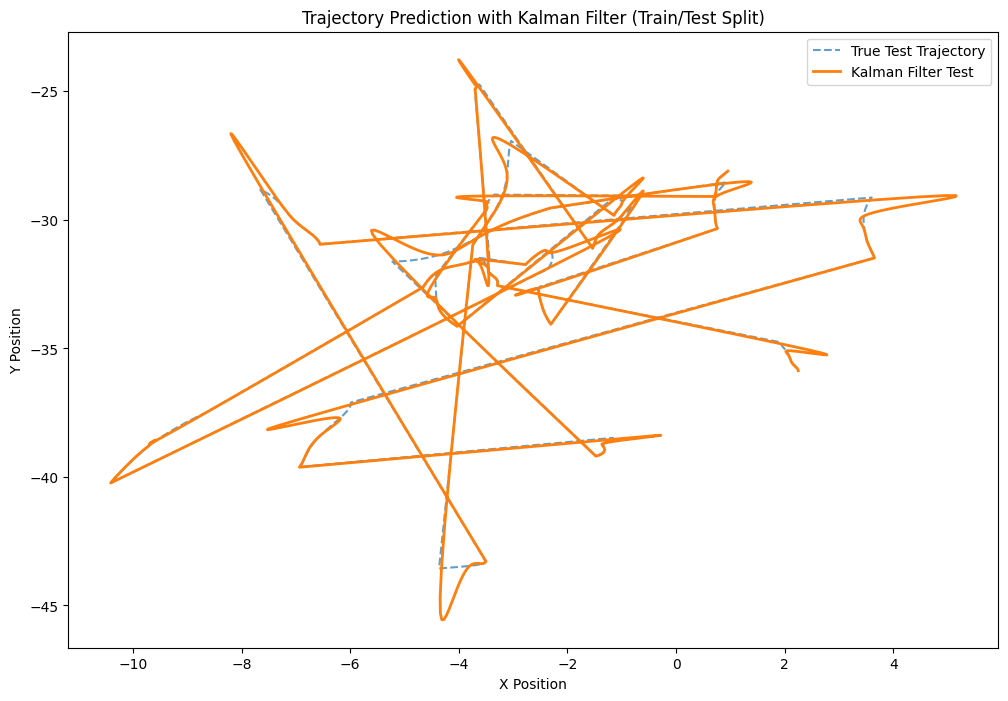

In [ ]:
plt.figure(figsize=(12, 8))
# plt.plot(train_positions[:, 0], train_positions[:, 1], label="True Train Trajectory", linestyle="--", alpha=0.7)
# plt.plot(filtered_train_positions[:, 0], filtered_train_positions[:, 1], label="Kalman Filter Train", linewidth=2)
plt.plot(test_positions[:, 0], test_positions[:, 1], label="True Test Trajectory", linestyle="--", alpha=0.7)
plt.plot(filtered_test_positions[:, 0], filtered_test_positions[:, 1], label="Kalman Filter Test", linewidth=2)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction with Kalman Filter (Train/Test Split)")
plt.show()

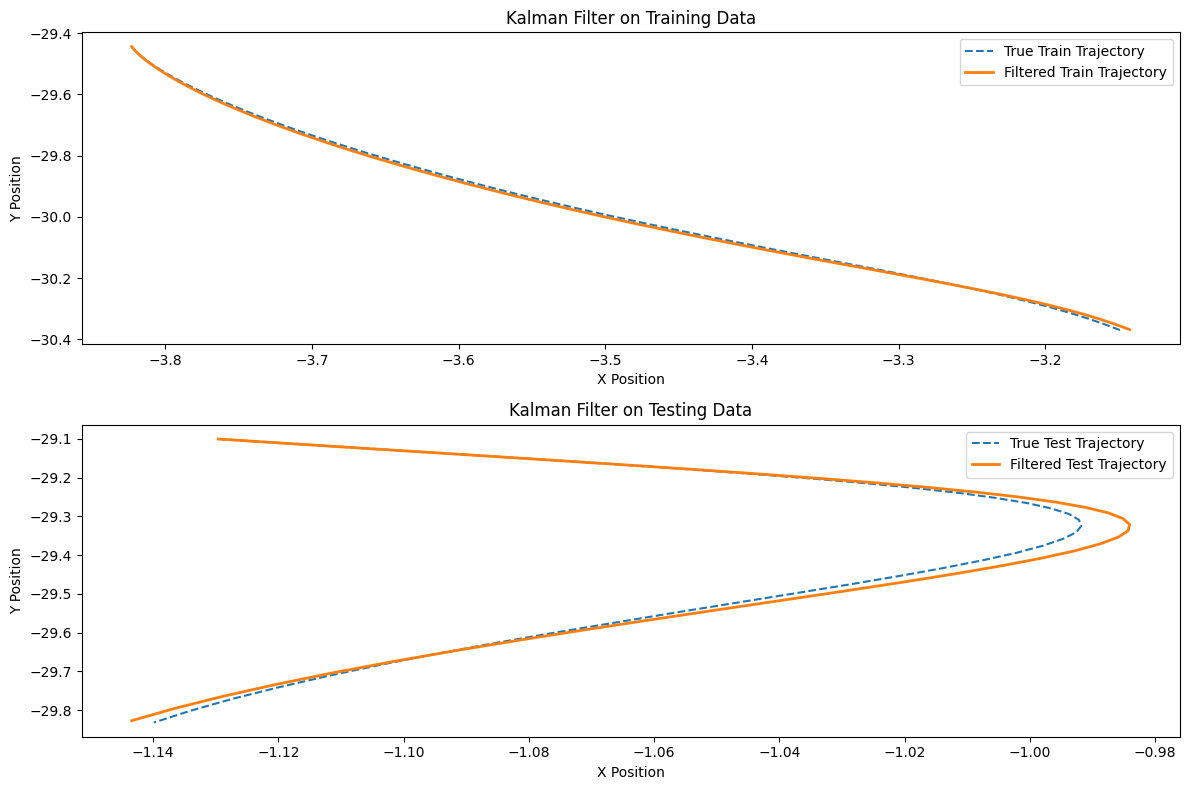

In [ ]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Example dataset with multiple trials
# Replace this with your actual data

# Parameters
bin_size = 0.05  # Time bin size (e.g., 50ms)

def preprocess_trial(trial):
    """Preprocess a single trial, binning spike data and aligning hand positions."""
    hand_positions = np.array(trial["hand_pos"])  # Shape (T, 2)
    spike_data = trial["spike_data"]              # List of lists with spike timestamps

    # Calculate the number of bins
    num_bins = int((trial["stop_time"] - trial["start_time"]) / bin_size)

    # Preprocess spike data into fixed bins
    spike_features = np.zeros((len(spike_data), num_bins))  # Shape (num_neurons, num_bins)
    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1))
        spike_features[neuron_idx, :] = binned_spikes

    # Combine spike features across neurons
    spike_summary = np.sum(spike_features, axis=0)  # Shape (num_bins,)

    # Truncate hand positions to align with the number of bins
    hand_positions = hand_positions[:num_bins]

    return hand_positions, spike_summary

# Preprocess all trials
all_hand_positions = []
all_spike_summaries = []

for trial in data:
    hand_positions, spike_summary = preprocess_trial(trial)
    all_hand_positions.append(hand_positions)
    all_spike_summaries.append(spike_summary)

# Split data into train and test sets based on trials
train_hand_positions, test_hand_positions, train_spike_summaries, test_spike_summaries = train_test_split(
    all_hand_positions, all_spike_summaries, test_size=0.2, random_state=42
)

# Function to apply Kalman Filter to a single trial
def apply_kalman_filter(hand_positions):
    """Apply Kalman Filter to a single trial's hand positions."""
    kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])

    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    kf.P = np.eye(4) * 1000
    kf.Q = np.eye(4) * 0.1
    kf.R = np.eye(2) * 10

    kf.x = np.array([hand_positions[0, 0], hand_positions[0, 1], 0, 0])

    filtered_positions = []
    for position in hand_positions:
        kf.predict()
        kf.update(position)
        filtered_positions.append(kf.x[:2])

    return np.array(filtered_positions)

# Apply Kalman Filter to training and testing trials
filtered_train_positions = [apply_kalman_filter(trial) for trial in train_hand_positions]
filtered_test_positions = [apply_kalman_filter(trial) for trial in test_hand_positions]

# Plot one example from training and testing
plt.figure(figsize=(12, 8))

# Training example
plt.subplot(2, 1, 1)
plt.plot(train_hand_positions[0][:, 0], train_hand_positions[0][:, 1], label="True Train Trajectory", linestyle="--")
plt.plot(filtered_train_positions[0][:, 0], filtered_train_positions[0][:, 1], label="Filtered Train Trajectory", linewidth=2)
plt.title("Kalman Filter on Training Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

# Testing example
plt.subplot(2, 1, 2)
plt.plot(test_hand_positions[0][:, 0], test_hand_positions[0][:, 1], label="True Test Trajectory", linestyle="--")
plt.plot(filtered_test_positions[0][:, 0], filtered_test_positions[0][:, 1], label="Filtered Test Trajectory", linewidth=2)
plt.title("Kalman Filter on Testing Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import json


with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", 'r') as f:
    trials = json.load(f)

def plot_maze_with_trajectory_from_file(trial):
    """
    Plots the maze with barriers and overlays the trajectory for a single trial.

    Parameters:
        trial (dict): Contains 'barrier_pos' and 'hand_pos' keys.
    """
    # Extract barriers and trajectory
    barriers = trial.get("barrier_pos", [])
    trajectory = trial.get("hand_pos", [])

    # Convert trajectory to numpy array for easier handling
    trajectory = np.array(trajectory)

    # Plot barriers
    plt.figure(figsize=(10, 10))
    for barrier in barriers:
        x1, y1, x2, y2 = barrier
        plt.plot([x1, x2], [y1, y2], color='black', linewidth=2, label="Barrier" if barrier == barriers[0] else "")

    # Plot trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label="True Trajectory", linestyle="--", color="blue", alpha=0.7)

    # Set plot properties
    plt.title(f"Trial ID: {trial['trial_id']}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

# Loop through trials and plot each maze with trajectory
for trial in trials:
    plot_maze_with_trajectory_from_file(trial)


In [ ]:
trials[0].keys()

dict_keys(['trial_id', 'start_time', 'stop_time', 'hand_pos', 'hand_vel', 'eye_pos', 'target_pos', 'barrier_pos', 'spike_data'])

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", 'r') as f:
    trials = json.load(f)

def plot_maze_with_cursor_trajectory(trial):
    """
    Plots the maze with barriers and overlays the trajectory using cursor positions for a single trial.

    Parameters:
        trial (dict): Contains 'barrier_pos' and 'cursor_pos' keys.
    """
    # Extract barriers and trajectory
    barriers = trial.get("barrier_pos", [])
    trajectory = trial.get("cursor_pos", [])

    # Convert trajectory to numpy array for easier handling
    trajectory = np.array(trajectory)

    # Plot barriers
    plt.figure(figsize=(10, 10))
    for barrier in barriers:
        x1, y1, x2, y2 = barrier
        plt.plot([x1, x2], [y1, y2], color='black', linewidth=2, label="Barrier" if barrier == barriers[0] else "")

    # Plot trajectory
    if trajectory.size > 0:
        plt.plot(trajectory[:, 0], trajectory[:, 1], label="Cursor Trajectory", linestyle="--", color="blue", alpha=0.7)

    # Set plot properties
    plt.title(f"Trial ID: {trial['trial_id']}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

# Loop through trials and plot each maze with cursor trajectory
for trial in trials[:10]:
    plot_maze_with_cursor_trajectory(trial)


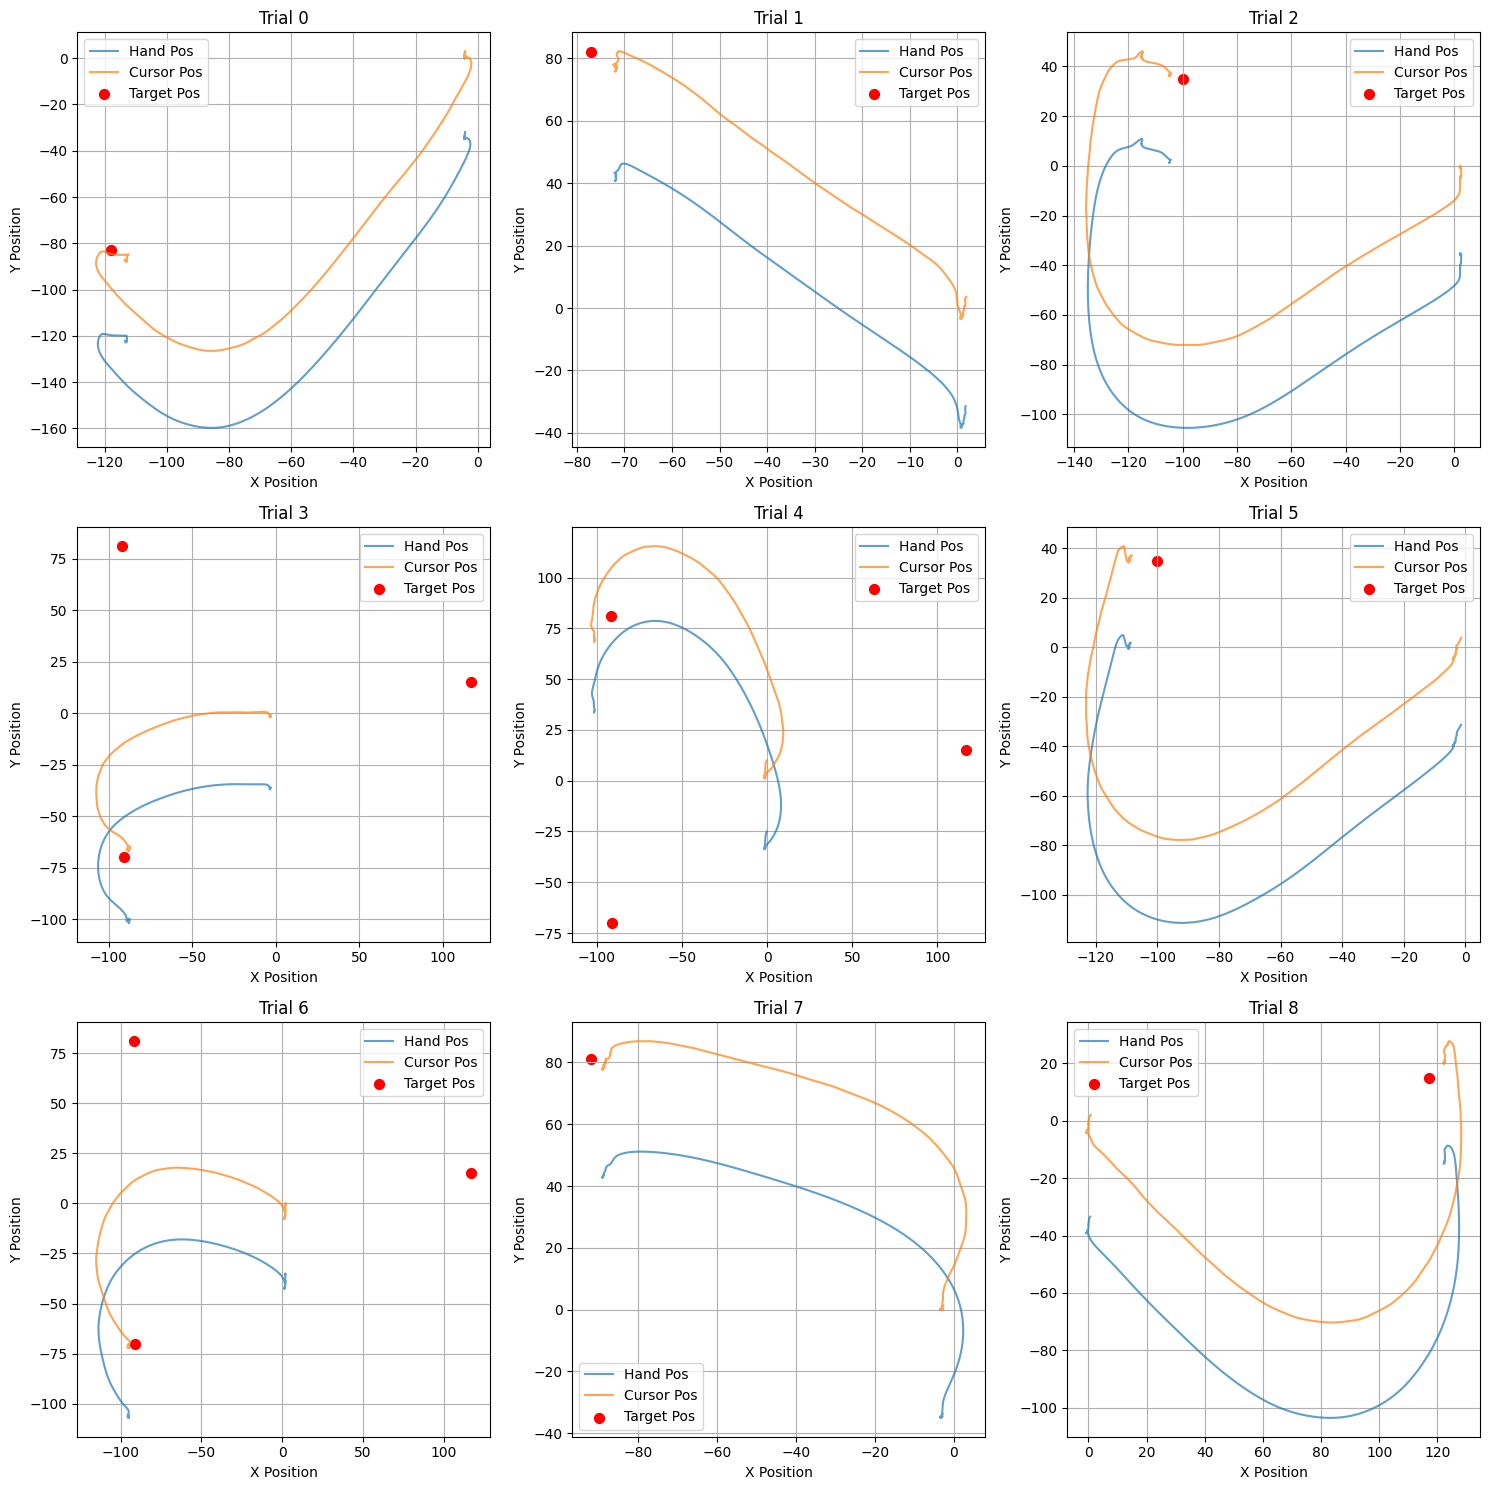

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of rows and columns for the grid plot
n_rows = 3
n_cols = 3
n_trials_to_plot = n_rows * n_cols

# Set up the grid for plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot trajectories and target positions for each trial
for i in range(n_trials_to_plot):
    if i >= len(trial_data):
        break  # Stop if there are no more trials to plot

    trial = trial_data[i]
    ax = axes[i]

    # Plot hand position
    hand_pos = np.array(trial["hand_pos"])
    if hand_pos.size > 0:
        ax.plot(hand_pos[:, 0], hand_pos[:, 1], label="Hand Pos", alpha=0.7)

    # Plot cursor position
    cursor_pos = np.array(trial["cursor_pos"])
    if cursor_pos.size > 0:
        ax.plot(cursor_pos[:, 0], cursor_pos[:, 1], label="Cursor Pos", alpha=0.7)

    # Plot target position
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        ax.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Add trial information
    ax.set_title(f"Trial {trial['trial_id']}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


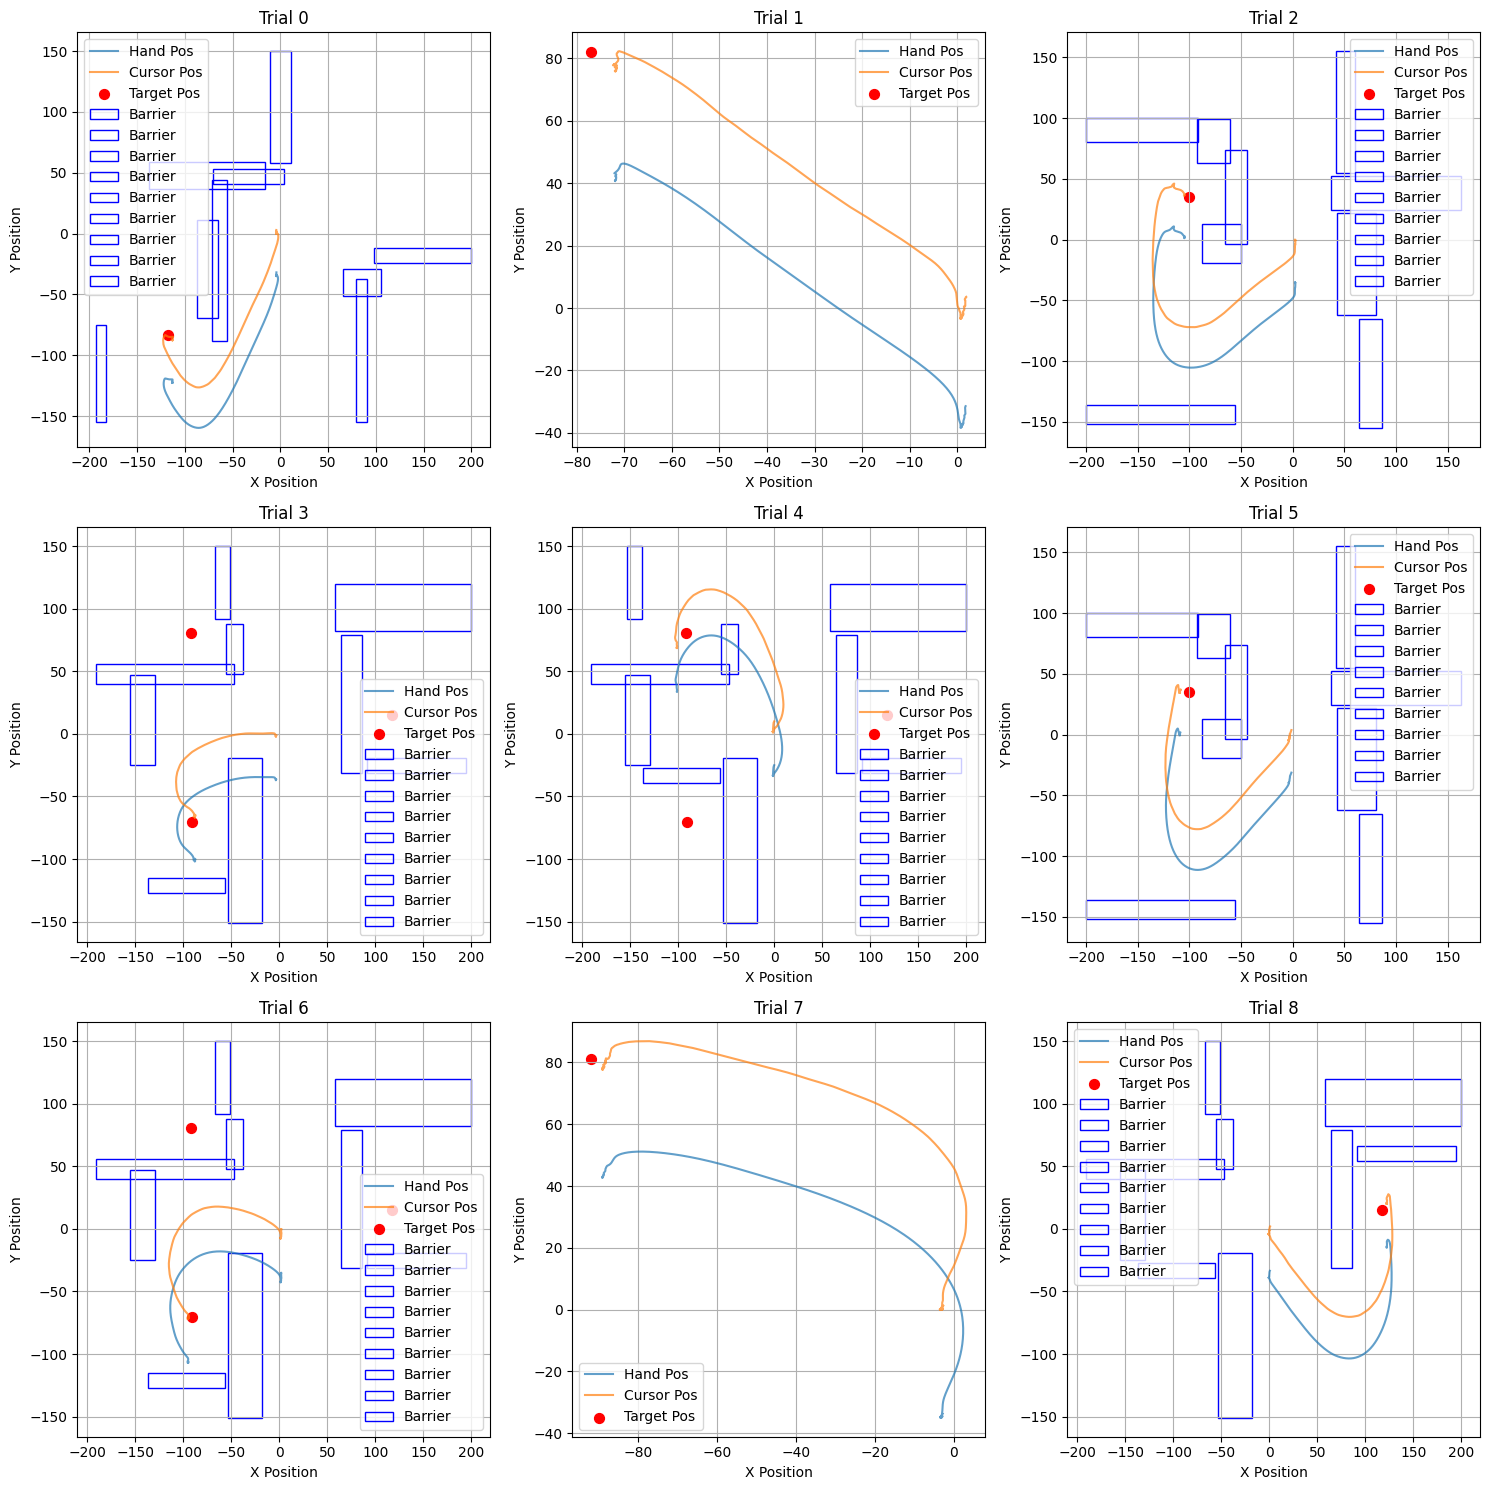

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Number of rows and columns for the grid plot
n_rows = 3
n_cols = 3
n_trials_to_plot = n_rows * n_cols

# Set up the grid for plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot trajectories, target positions, and barriers for each trial
for i in range(n_trials_to_plot):
    if i >= len(trial_data):
        break  # Stop if there are no more trials to plot

    trial = trial_data[i]
    ax = axes[i]

    # Plot hand position
    hand_pos = np.array(trial["hand_pos"])
    if hand_pos.size > 0:
        ax.plot(hand_pos[:, 0], hand_pos[:, 1], label="Hand Pos", alpha=0.7)

    # Plot cursor position
    cursor_pos = np.array(trial["cursor_pos"])
    if cursor_pos.size > 0:
        ax.plot(cursor_pos[:, 0], cursor_pos[:, 1], label="Cursor Pos", alpha=0.7)

    # Plot target position
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        ax.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            ax.add_patch(rect)

    # Add trial information
    ax.set_title(f"Trial {trial['trial_id']}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig("plot_image.png")
plt.show()



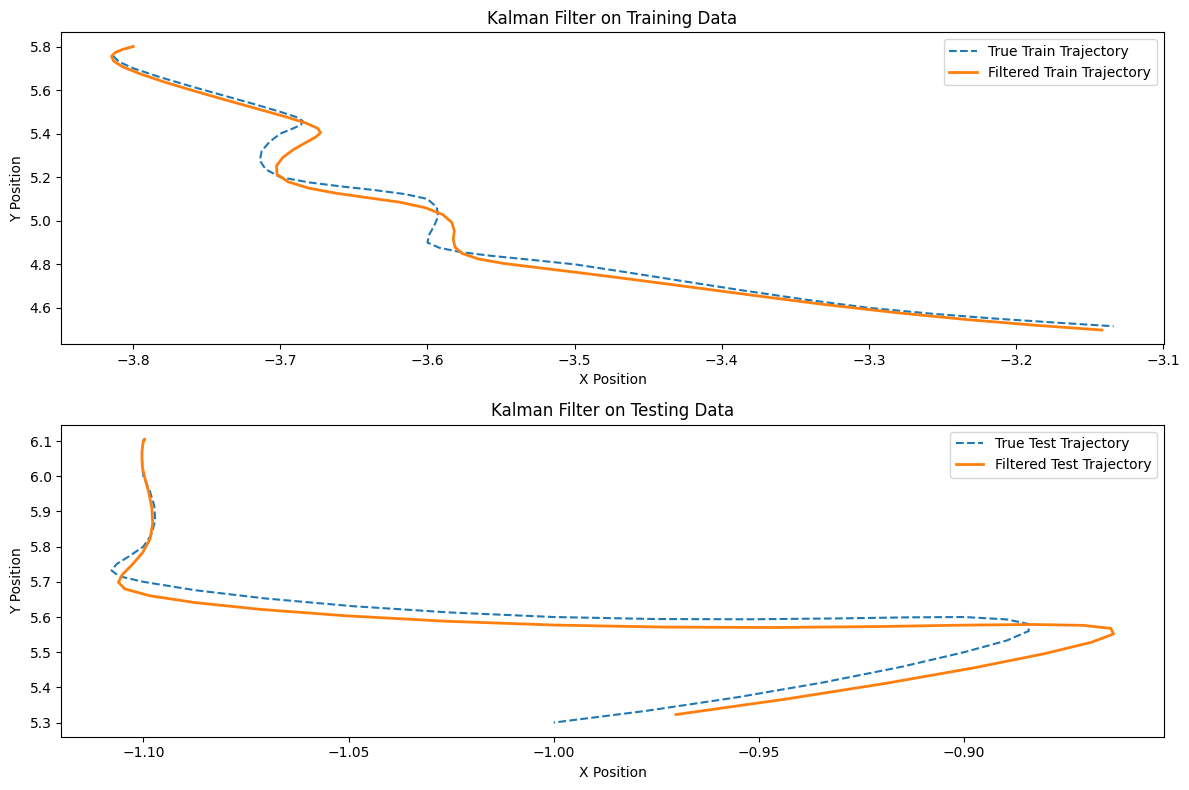

In [ ]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    data = json.load(f)

# Parameters
bin_size = 0.05  # Time bin size (e.g., 50ms)

def preprocess_trial(trial):
    """Preprocess a single trial, binning spike data and aligning cursor positions."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    spike_data = trial["spike_data"]                  # List of lists with spike timestamps

    # Calculate the number of bins
    num_bins = int((trial["stop_time"] - trial["start_time"]) / bin_size)

    # Preprocess spike data into fixed bins
    spike_features = np.zeros((len(spike_data), num_bins))  # Shape (num_neurons, num_bins)
    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1))
        spike_features[neuron_idx, :] = binned_spikes

    # Combine spike features across neurons
    spike_summary = np.sum(spike_features, axis=0)  # Shape (num_bins,)

    # Truncate cursor positions to align with the number of bins
    cursor_positions = cursor_positions[:num_bins]

    return cursor_positions, spike_summary

# Preprocess all trials
all_cursor_positions = []
all_spike_summaries = []

for trial in data:
    cursor_positions, spike_summary = preprocess_trial(trial)
    all_cursor_positions.append(cursor_positions)
    all_spike_summaries.append(spike_summary)

# Split data into train and test sets based on trials
train_cursor_positions, test_cursor_positions, train_spike_summaries, test_spike_summaries = train_test_split(
    all_cursor_positions, all_spike_summaries, test_size=0.2, random_state=42
)

# Function to apply Kalman Filter to a single trial
def apply_kalman_filter(cursor_positions, spike_features):
    """Apply Kalman Filter to a single trial's cursor positions."""
    kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])

    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    kf.P = np.eye(4) * 1000
    kf.Q = np.eye(4) * 0.1
    kf.R = np.eye(2) * 10

    kf.x = np.array([cursor_positions[0, 0], cursor_positions[0, 1], 0, 0])

    filtered_positions = []
    for i, position in enumerate(cursor_positions):
        kf.predict()
        if i < len(spike_features):  # Incorporate spike feature scaling (optional)
            observation = position
        else:
            observation = np.zeros(2)
        kf.update(observation)
        filtered_positions.append(kf.x[:2])

    return np.array(filtered_positions)

# Apply Kalman Filter to training and testing trials
filtered_train_positions = [
    apply_kalman_filter(trial_cursor, trial_spike)
    for trial_cursor, trial_spike in zip(train_cursor_positions, train_spike_summaries)
]

filtered_test_positions = [
    apply_kalman_filter(trial_cursor, trial_spike)
    for trial_cursor, trial_spike in zip(test_cursor_positions, test_spike_summaries)
]

# Plot one example from training and testing
plt.figure(figsize=(12, 8))

# Training example
plt.subplot(2, 1, 1)
plt.plot(train_cursor_positions[0][:, 0], train_cursor_positions[0][:, 1], label="True Train Trajectory", linestyle="--")
plt.plot(filtered_train_positions[0][:, 0], filtered_train_positions[0][:, 1], label="Filtered Train Trajectory", linewidth=2)
plt.title("Kalman Filter on Training Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

# Testing example
plt.subplot(2, 1, 2)
plt.plot(test_cursor_positions[0][:, 0], test_cursor_positions[0][:, 1], label="True Test Trajectory", linestyle="--")
plt.plot(filtered_test_positions[0][:, 0], filtered_test_positions[0][:, 1], label="Filtered Test Trajectory", linewidth=2)
plt.title("Kalman Filter on Testing Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

plt.tight_layout()
plt.show()


KALMAN with traial based split

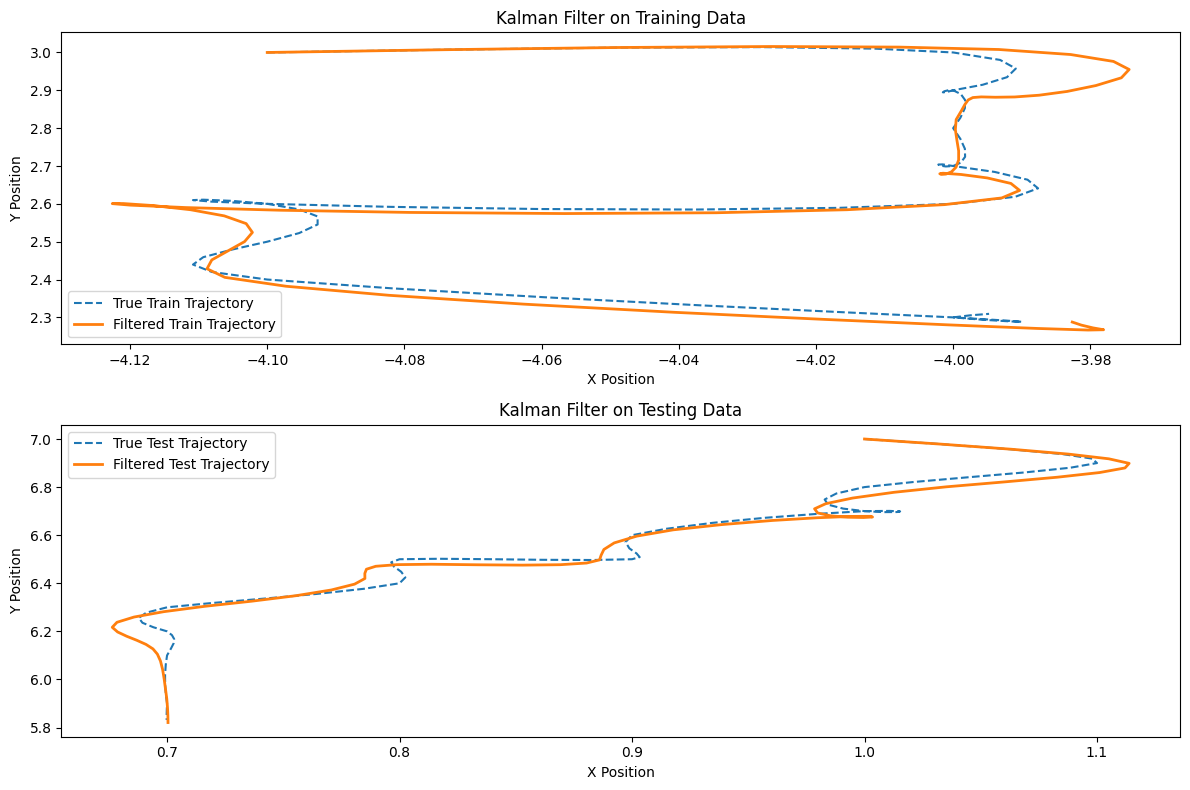

In [6]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# Example dataset with multiple trials
# Replace `data` with your actual list of trials
# Assuming `data` is a list of dictionaries, each representing one trial

# Parameters
bin_size = 0.05  # Time bin size (e.g., 50ms)

def preprocess_trial(trial):
    """Preprocess a single trial, binning spike data and aligning cursor positions."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    spike_data = trial["spike_data"]                  # List of lists with spike timestamps

    # Calculate the number of bins
    num_bins = int((trial["stop_time"] - trial["start_time"]) / bin_size)

    # Preprocess spike data into fixed bins
    spike_features = np.zeros((len(spike_data), num_bins))  # Shape (num_neurons, num_bins)
    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1))
        spike_features[neuron_idx, :] = binned_spikes

    # Combine spike features across neurons
    spike_summary = np.sum(spike_features, axis=0)  # Shape (num_bins,)

    # Truncate cursor positions to align with the number of bins
    cursor_positions = cursor_positions[:num_bins]

    return cursor_positions, spike_summary

# Preprocess all trials
all_cursor_positions = []
all_spike_summaries = []

for trial in data:
    cursor_positions, spike_summary = preprocess_trial(trial)
    all_cursor_positions.append(cursor_positions)
    all_spike_summaries.append(spike_summary)

# Split data into training and testing sets by trial index
num_trials = len(data)
train_indices = list(range(80))  # First 80 trials
test_indices = list(range(80, num_trials))  # Remaining trials

train_cursor_positions = [all_cursor_positions[i] for i in train_indices]
test_cursor_positions = [all_cursor_positions[i] for i in test_indices]

train_spike_summaries = [all_spike_summaries[i] for i in train_indices]
test_spike_summaries = [all_spike_summaries[i] for i in test_indices]

# Function to apply Kalman Filter to a single trial
def apply_kalman_filter(cursor_positions, spike_features):
    """Apply Kalman Filter to a single trial's cursor positions."""
    kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state variables (x, y, vx, vy), 2 measurements (x, y)

    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])

    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    kf.P = np.eye(4) * 1000
    kf.Q = np.eye(4) * 0.1
    kf.R = np.eye(2) * 10

    kf.x = np.array([cursor_positions[0, 0], cursor_positions[0, 1], 0, 0])

    filtered_positions = []
    for i, position in enumerate(cursor_positions):
        kf.predict()
        if i < len(spike_features):  # Incorporate spike feature scaling (optional)
            observation = position
        else:
            observation = np.zeros(2)
        kf.update(observation)
        filtered_positions.append(kf.x[:2])

    return np.array(filtered_positions)

# Apply Kalman Filter to training and testing trials
filtered_train_positions = [
    apply_kalman_filter(trial_cursor, trial_spike)
    for trial_cursor, trial_spike in zip(train_cursor_positions, train_spike_summaries)
]

filtered_test_positions = [
    apply_kalman_filter(trial_cursor, trial_spike)
    for trial_cursor, trial_spike in zip(test_cursor_positions, test_spike_summaries)
]

# Plot one example from training and testing
plt.figure(figsize=(12, 8))

# Training example
plt.subplot(2, 1, 1)
plt.plot(train_cursor_positions[0][:, 0], train_cursor_positions[0][:, 1], label="True Train Trajectory", linestyle="--")
plt.plot(filtered_train_positions[0][:, 0], filtered_train_positions[0][:, 1], label="Filtered Train Trajectory", linewidth=2)
plt.title("Kalman Filter on Training Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

# Testing example
plt.subplot(2, 1, 2)
plt.plot(test_cursor_positions[0][:, 0], test_cursor_positions[0][:, 1], label="True Test Trajectory", linestyle="--")
plt.plot(filtered_test_positions[0][:, 0], filtered_test_positions[0][:, 1], label="Filtered Test Trajectory", linewidth=2)
plt.title("Kalman Filter on Testing Data")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")

plt.tight_layout()
plt.show()


In [18]:
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    trial_data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from filterpy.kalman import KalmanFilter

# Function to preprocess trial data for cursor positions
def preprocess_trial(trial):
    """Extract cursor positions from trial data."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    return cursor_positions

# Function to apply Kalman Filter to predict the trajectory for a single trial
def apply_kalman_filter(cursor_positions):
    """Apply Kalman Filter to predict the entire cursor trajectory."""
    if cursor_positions.size == 0:
        return np.array([])

    # Define Kalman Filter with 4 state variables (x, y, vx, vy) and 2 measurements (x, y)
    kf = KalmanFilter(dim_x=4, dim_z=2)

    # Define the state transition matrix (F) and measurement matrix (H)
    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])
    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    # Initialize covariances
    kf.P = np.eye(4) * 1000  # Initial uncertainty
    kf.Q = np.eye(4) * 0.1   # Process noise
    kf.R = np.eye(2) * 10    # Measurement noise

    # Initialize the state vector [x, y, vx, vy]
    kf.x = np.array([cursor_positions[0, 0], cursor_positions[0, 1], 0, 0])

    # Predict the trajectory
    filtered_positions = []
    for position in cursor_positions:
        kf.predict()
        kf.update(position)
        filtered_positions.append(kf.x[:2])  # Append the predicted position [x, y]

    return np.array(filtered_positions)

# Apply Kalman Filter to all trials and predict trajectories
predicted_trajectories = []
for trial in trial_data:
    cursor_positions = preprocess_trial(trial)
    predicted_cursor = apply_kalman_filter(cursor_positions)
    predicted_trajectories.append(predicted_cursor)

# Plot each trial's actual and predicted trajectories
for i, trial in enumerate(trial_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_trajectories[i]

    # Start a new figure for each trial
    plt.figure(figsize=(10, 8))

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        plt.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        plt.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        plt.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            plt.gca().add_patch(rect)

    # Add plot labels and title
    plt.title(f"Trial {trial['trial_id']}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    # Show the plot
    plt.show()


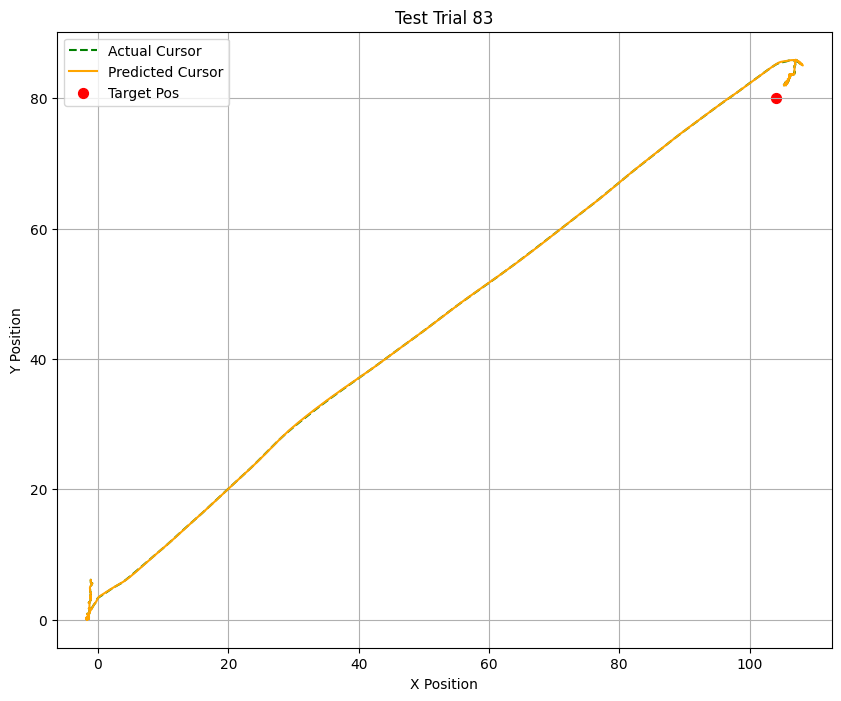

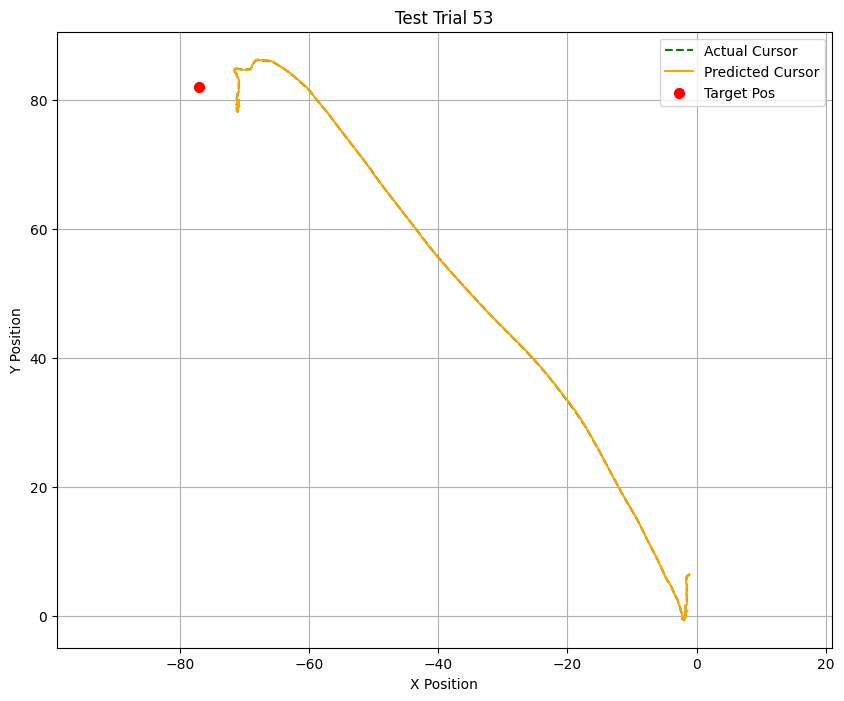

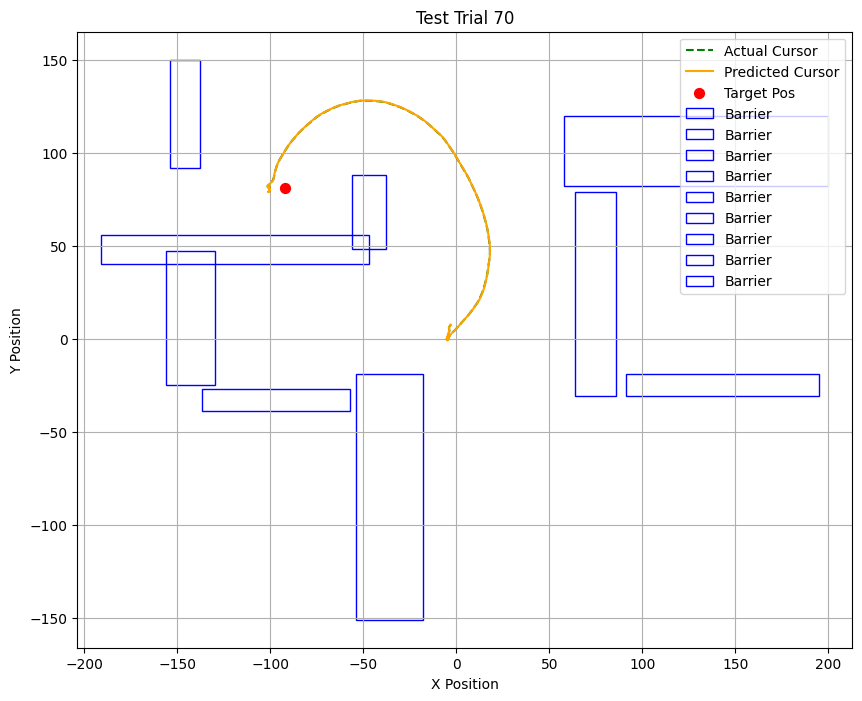

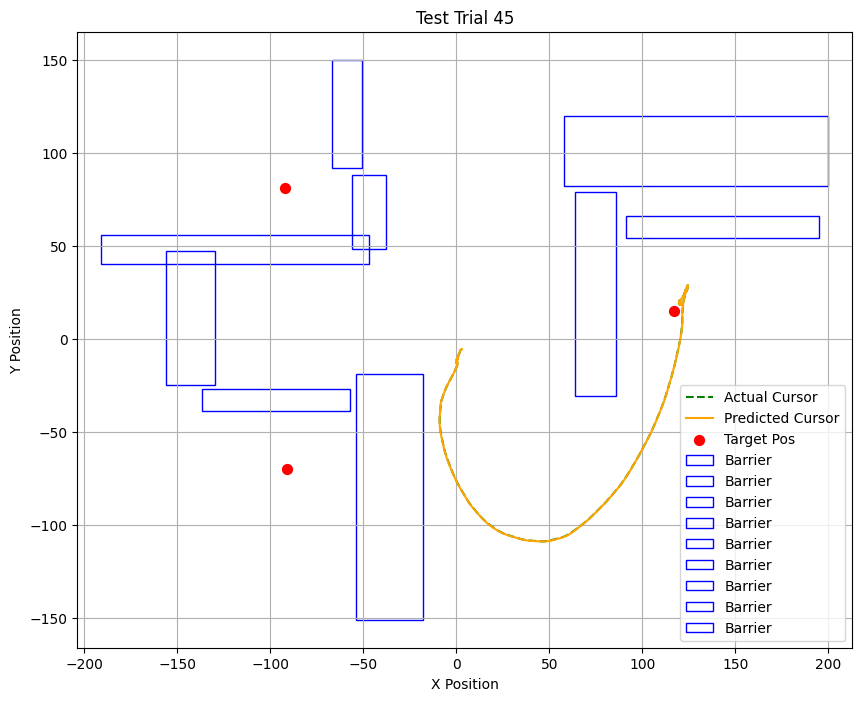

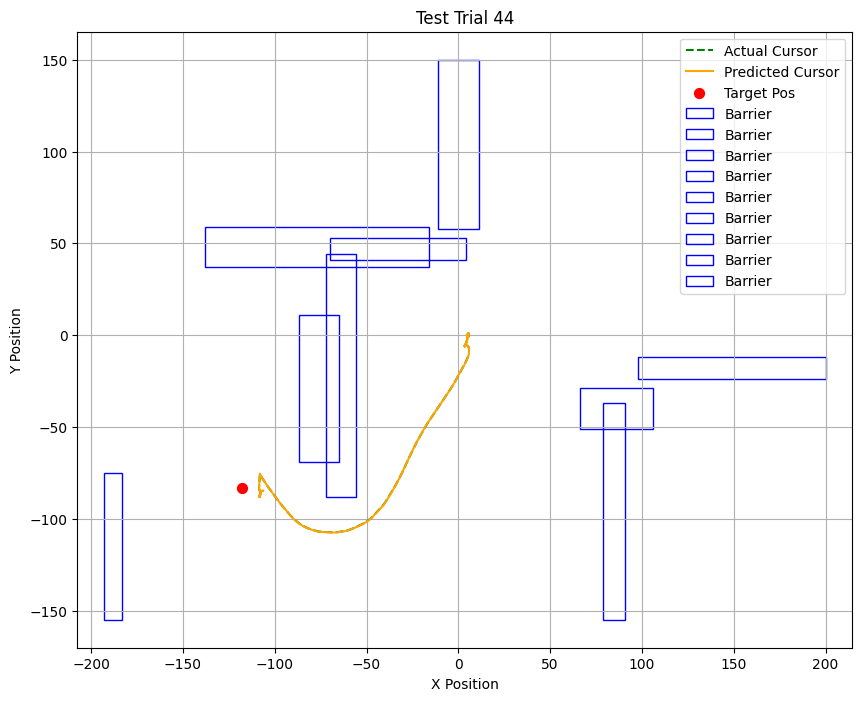

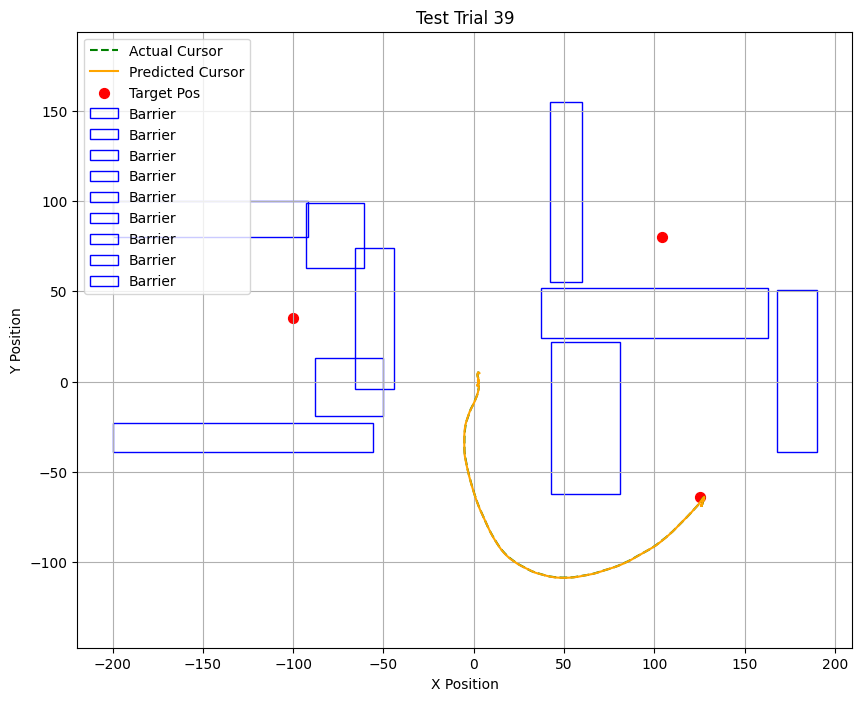

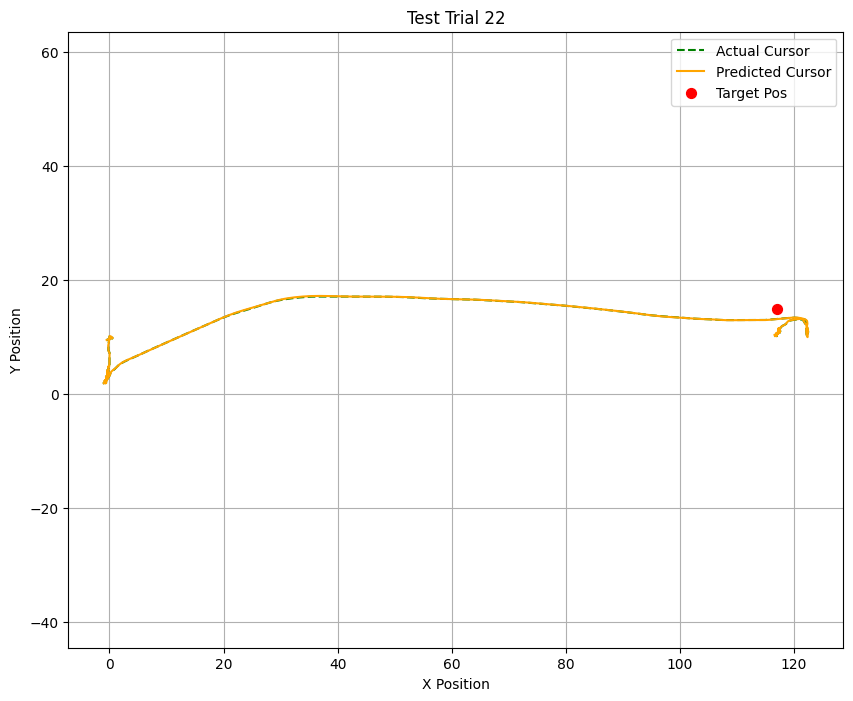

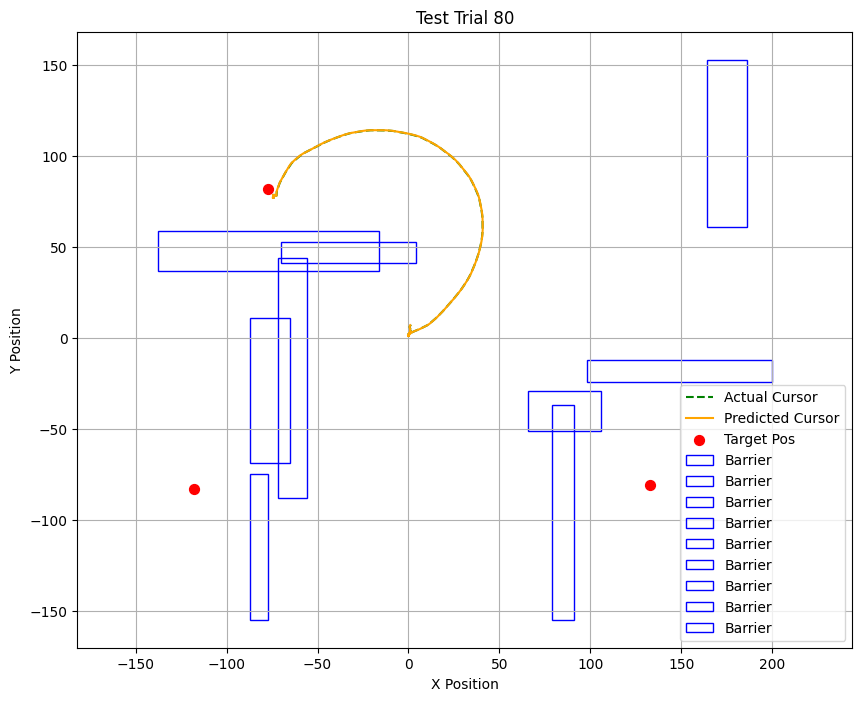

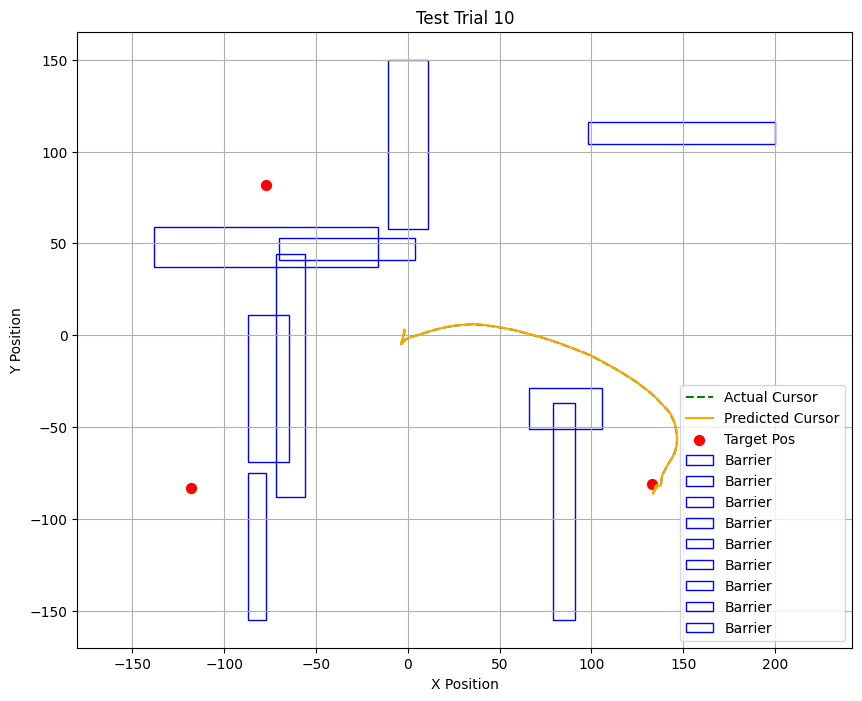

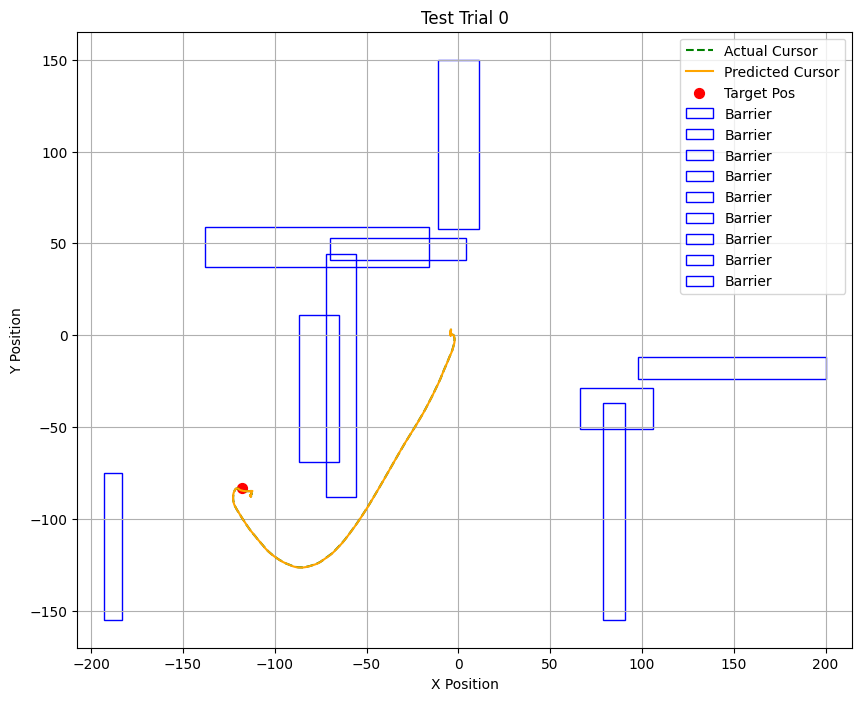

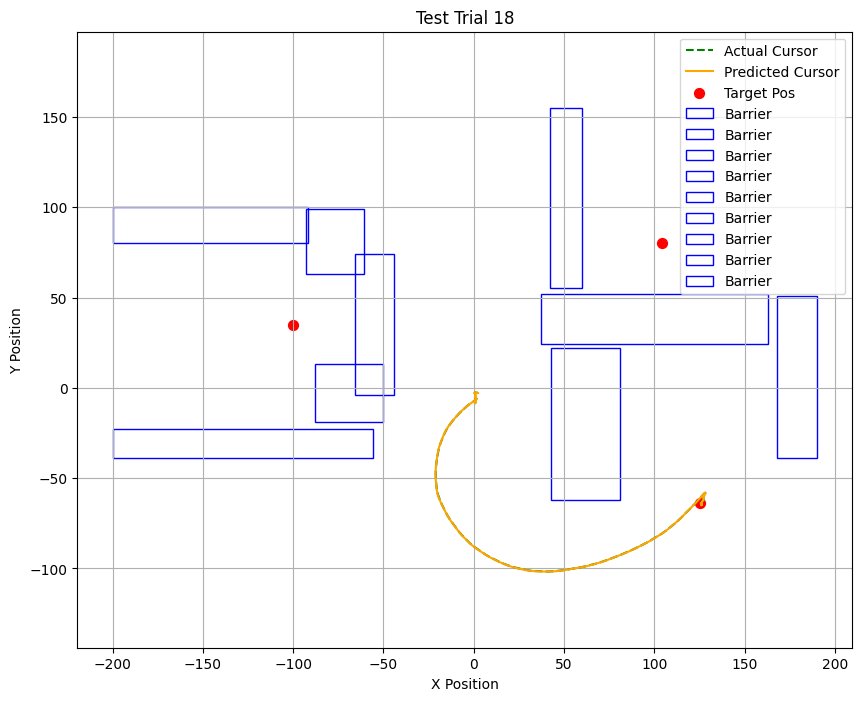

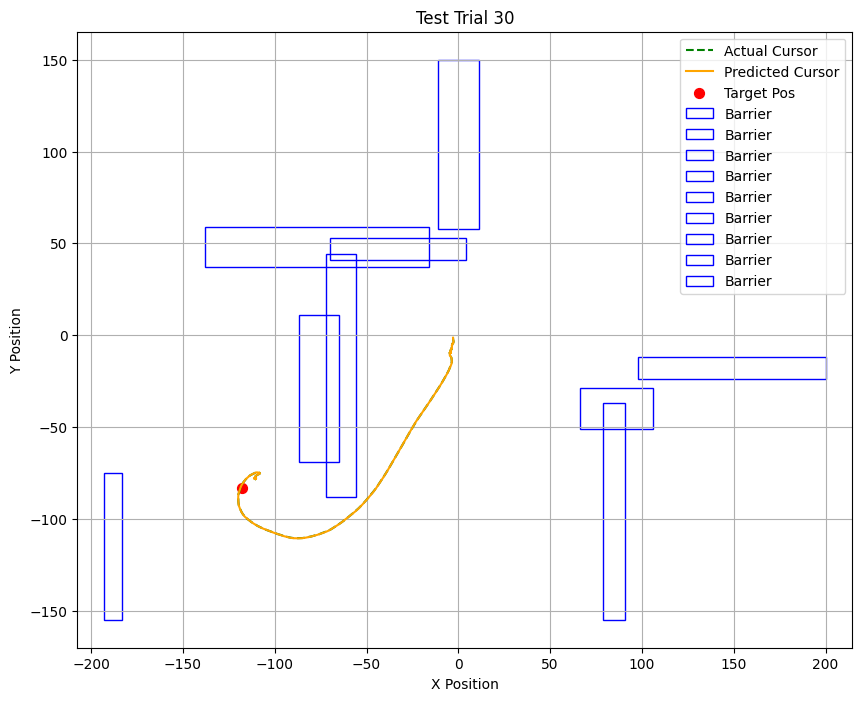

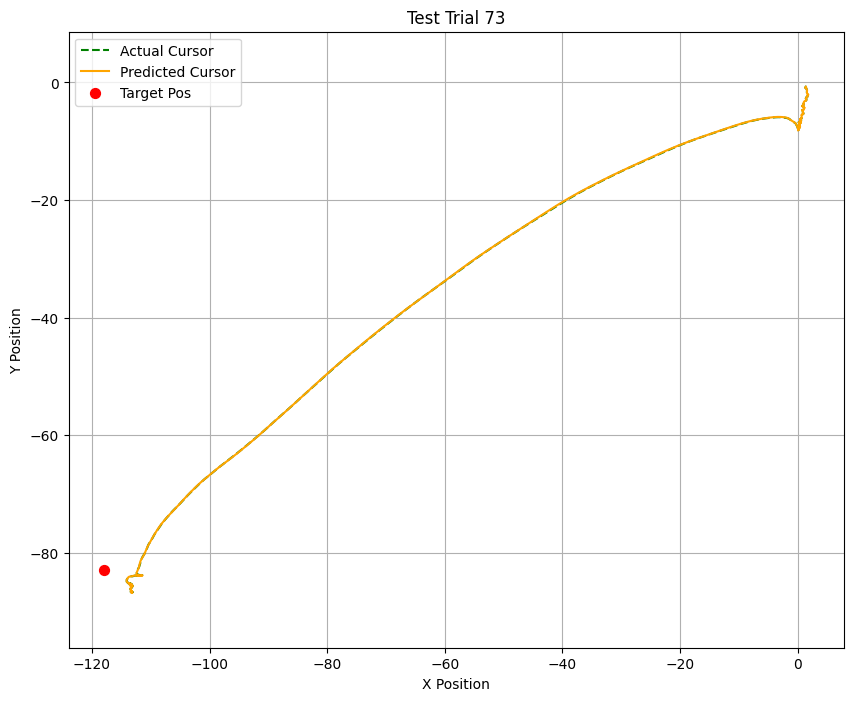

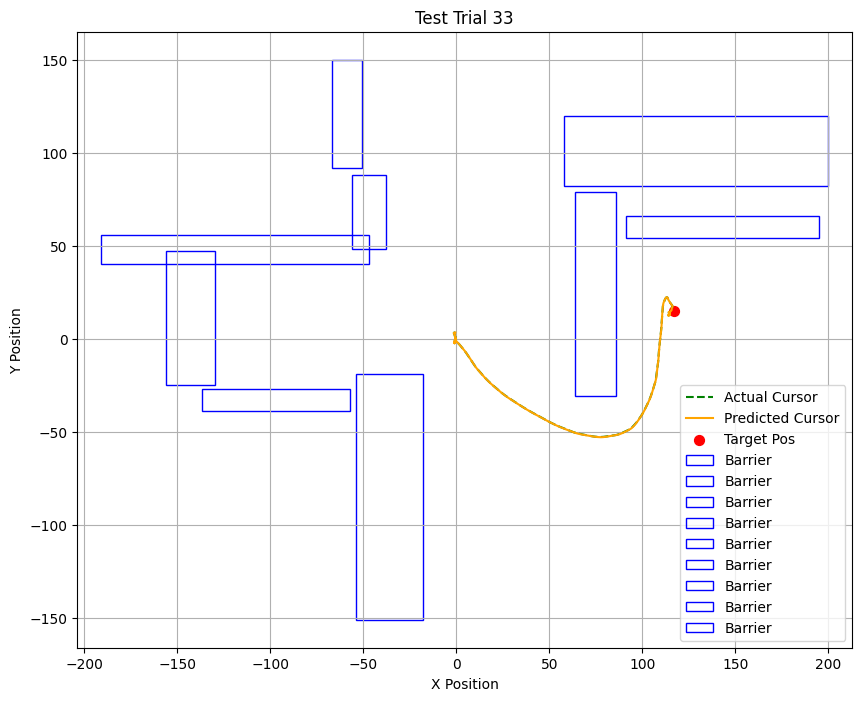

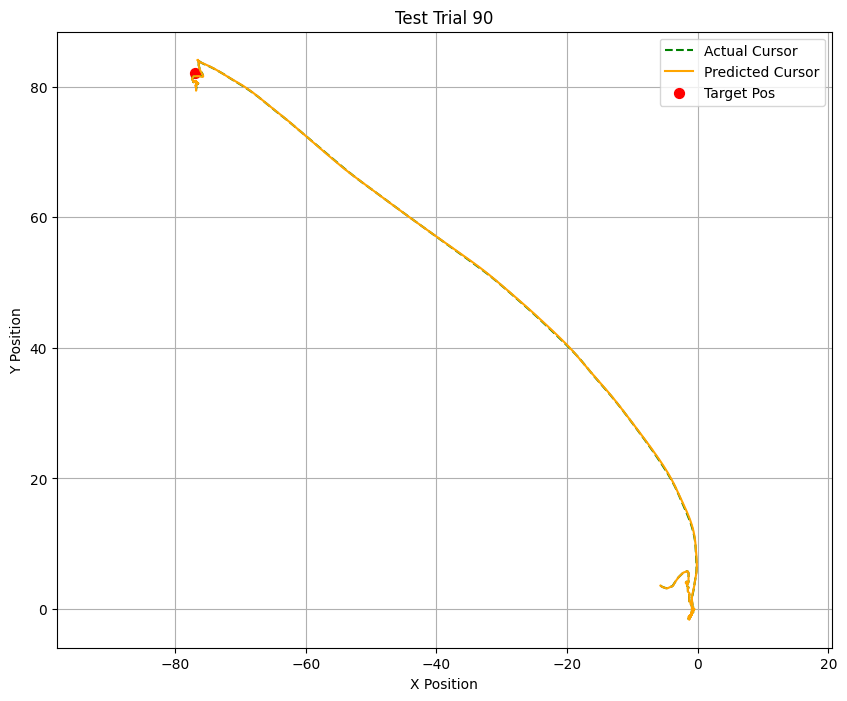

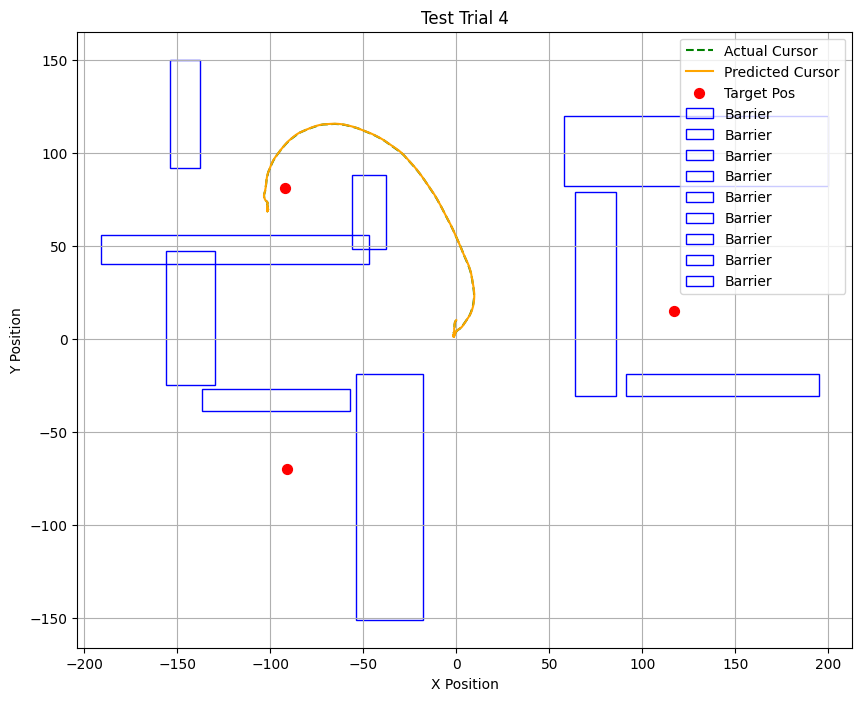

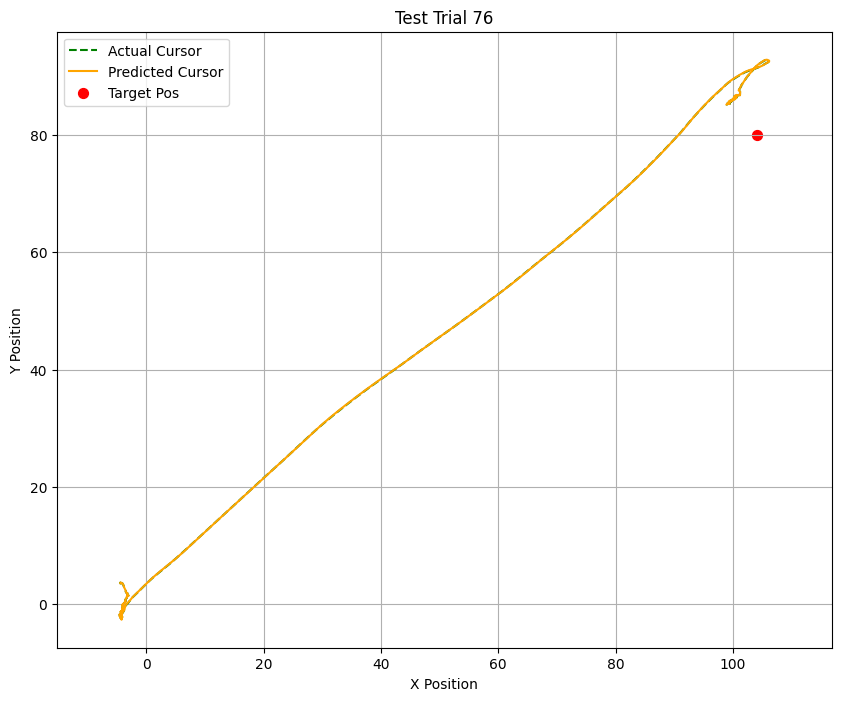

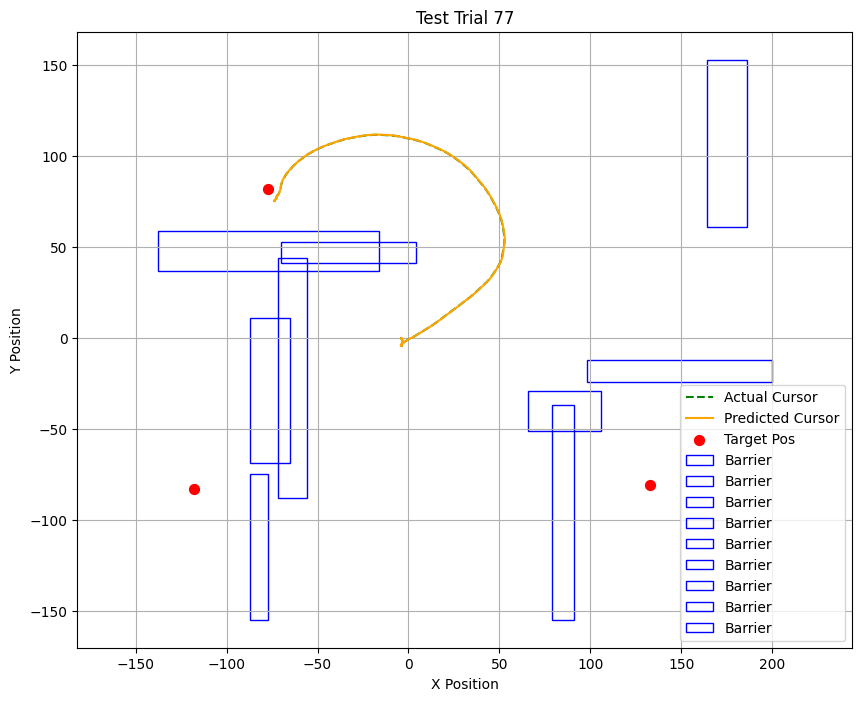

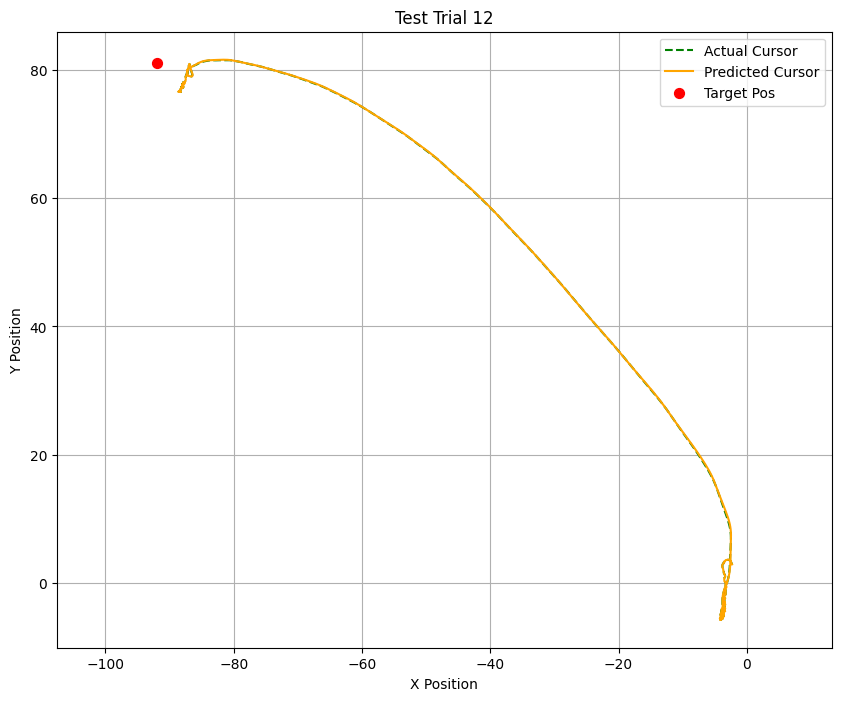

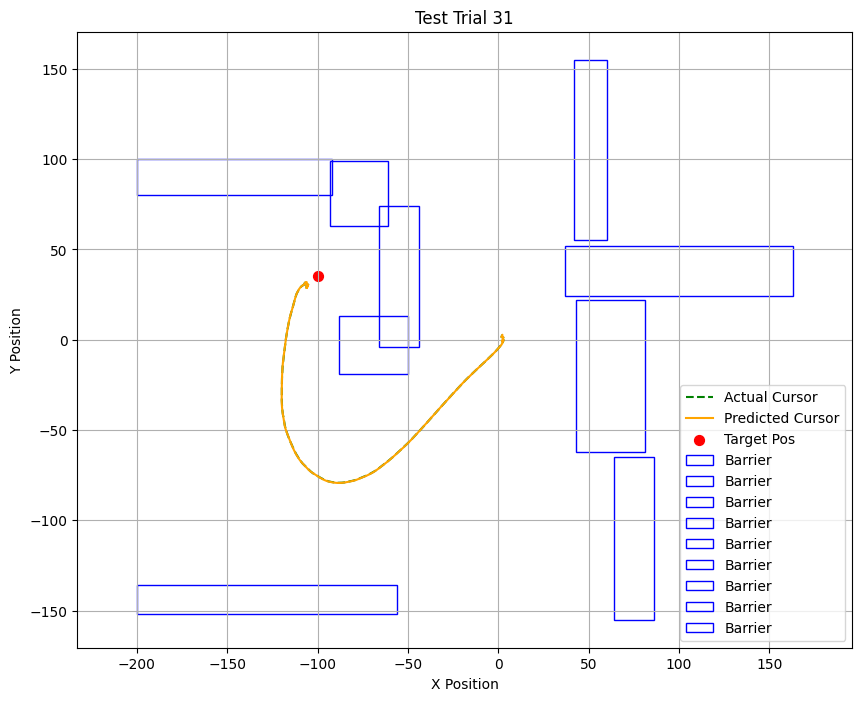

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from filterpy.kalman import KalmanFilter
from sklearn.model_selection import train_test_split

# Function to preprocess trial data for cursor positions
def preprocess_trial(trial):
    """Extract cursor positions from trial data."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    return cursor_positions

# Function to apply Kalman Filter to predict the trajectory for a single trial
def apply_kalman_filter(cursor_positions):
    """Apply Kalman Filter to predict the entire cursor trajectory."""
    if cursor_positions.size == 0:
        return np.array([])

    # Define Kalman Filter with 4 state variables (x, y, vx, vy) and 2 measurements (x, y)
    kf = KalmanFilter(dim_x=4, dim_z=2)

    # Define the state transition matrix (F) and measurement matrix (H)
    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])
    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    # Initialize covariances
    kf.P = np.eye(4) * 1000  # Initial uncertainty
    kf.Q = np.eye(4) * 0.1   # Process noise
    kf.R = np.eye(2) * 10    # Measurement noise

    # Initialize the state vector [x, y, vx, vy]
    kf.x = np.array([cursor_positions[0, 0], cursor_positions[0, 1], 0, 0])

    # Predict the trajectory
    filtered_positions = []
    for position in cursor_positions:
        kf.predict()
        kf.update(position)
        filtered_positions.append(kf.x[:2])  # Append the predicted position [x, y]

    return np.array(filtered_positions)

# Split data into training and testing sets based on trial IDs
train_data, test_data = train_test_split(trial_data, test_size=0.2, random_state=42, shuffle=True)

# Apply Kalman Filter to training trials and testing trials
predicted_train_trajectories = []
predicted_test_trajectories = []

for trial in train_data:
    cursor_positions = preprocess_trial(trial)
    predicted_cursor = apply_kalman_filter(cursor_positions)
    predicted_train_trajectories.append(predicted_cursor)

for trial in test_data:
    cursor_positions = preprocess_trial(trial)
    predicted_cursor = apply_kalman_filter(cursor_positions)
    predicted_test_trajectories.append(predicted_cursor)

# Plot actual and predicted trajectories for test trials
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    # Start a new figure for each test trial
    plt.figure(figsize=(10, 8))

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        plt.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        plt.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        plt.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            plt.gca().add_patch(rect)

    # Add plot labels and title
    plt.title(f"Test Trial {trial['trial_id']}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    # Show the plot
    plt.show()


Correct

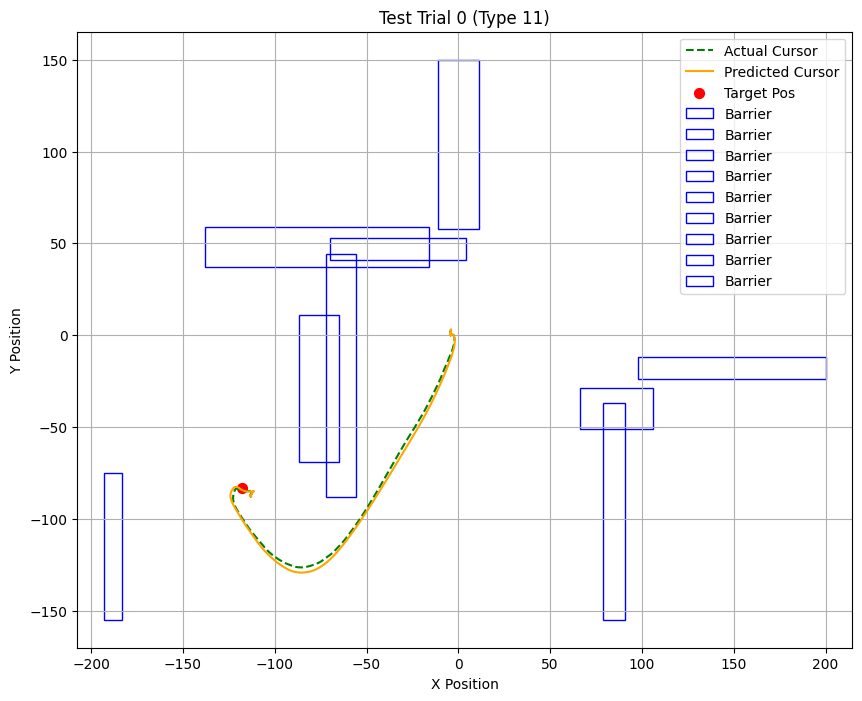

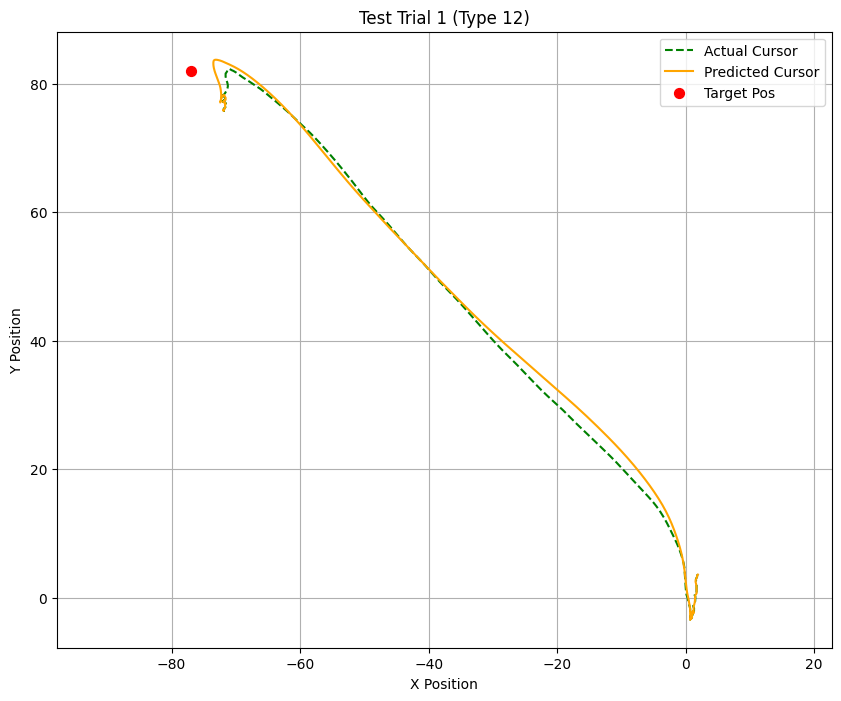

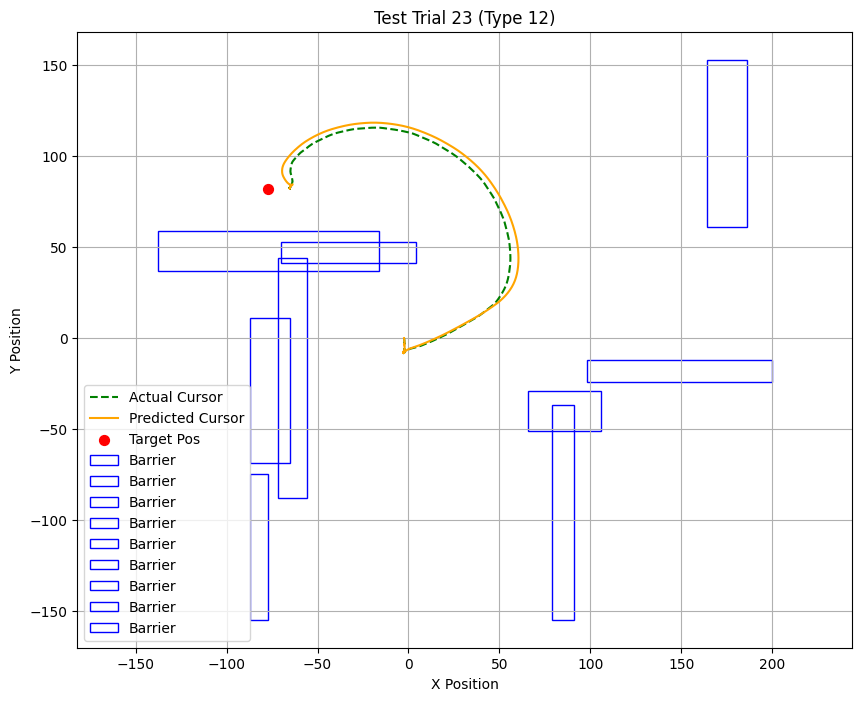

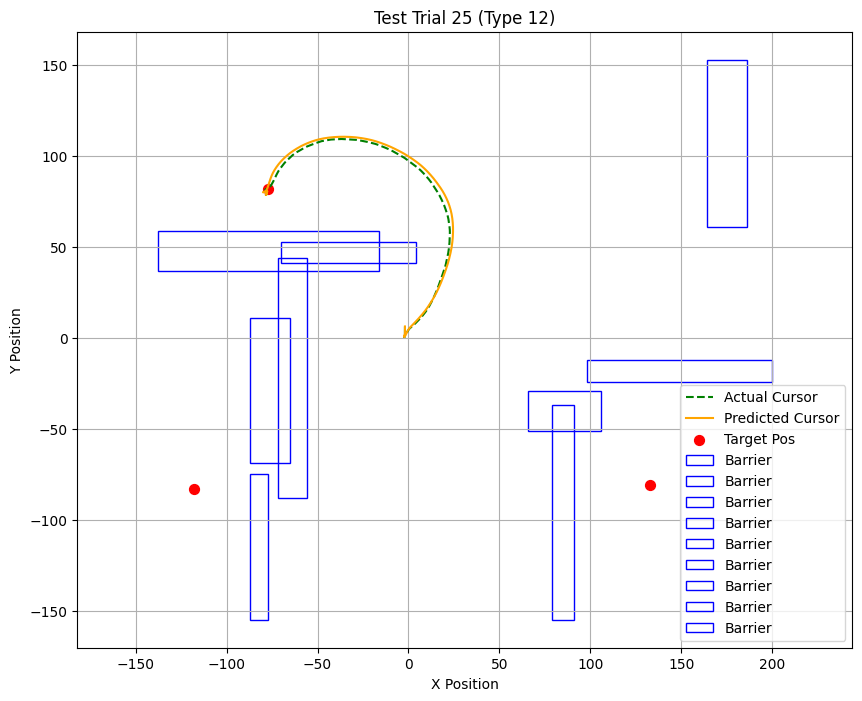

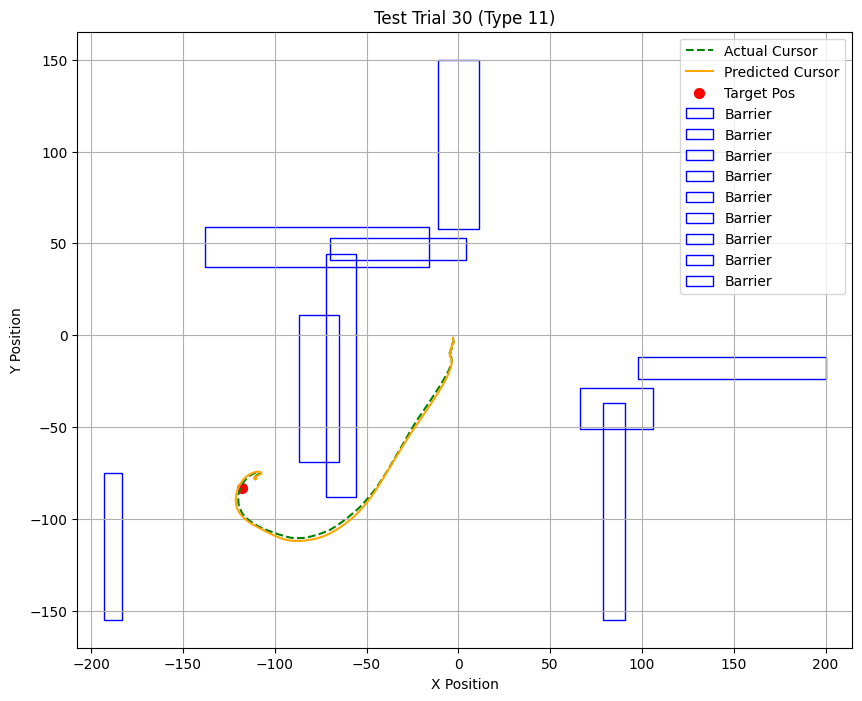

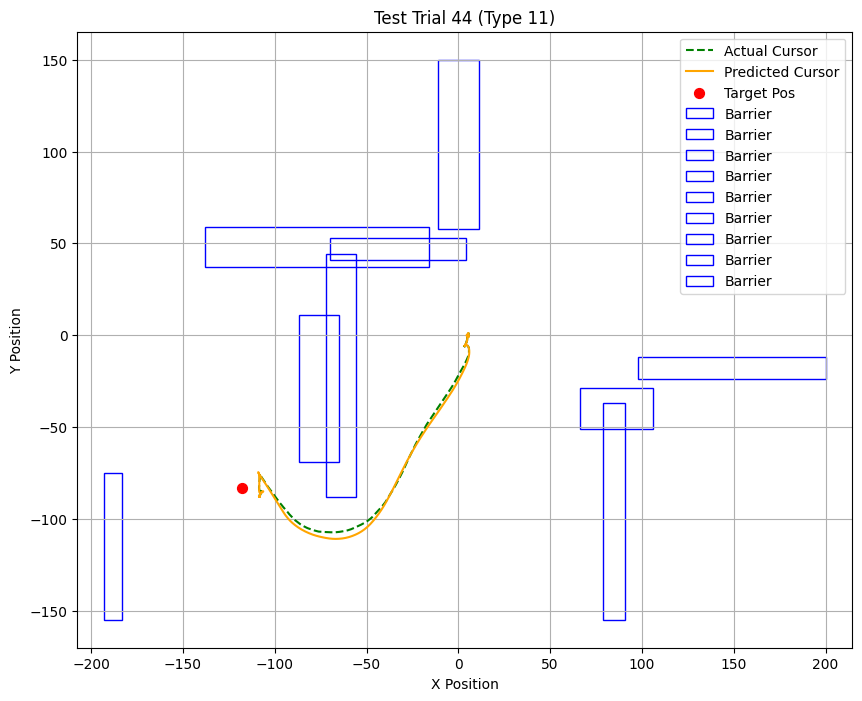

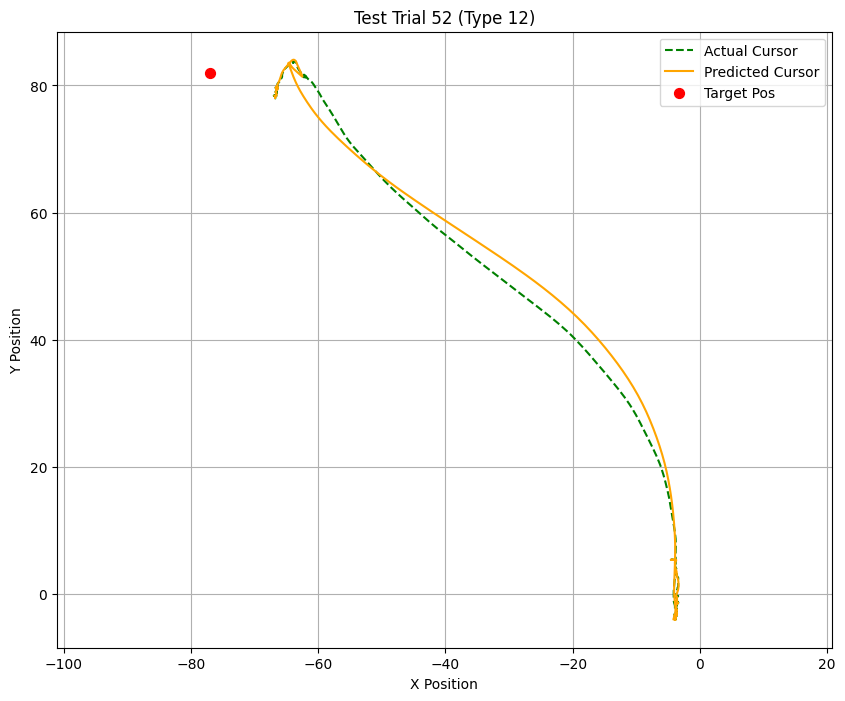

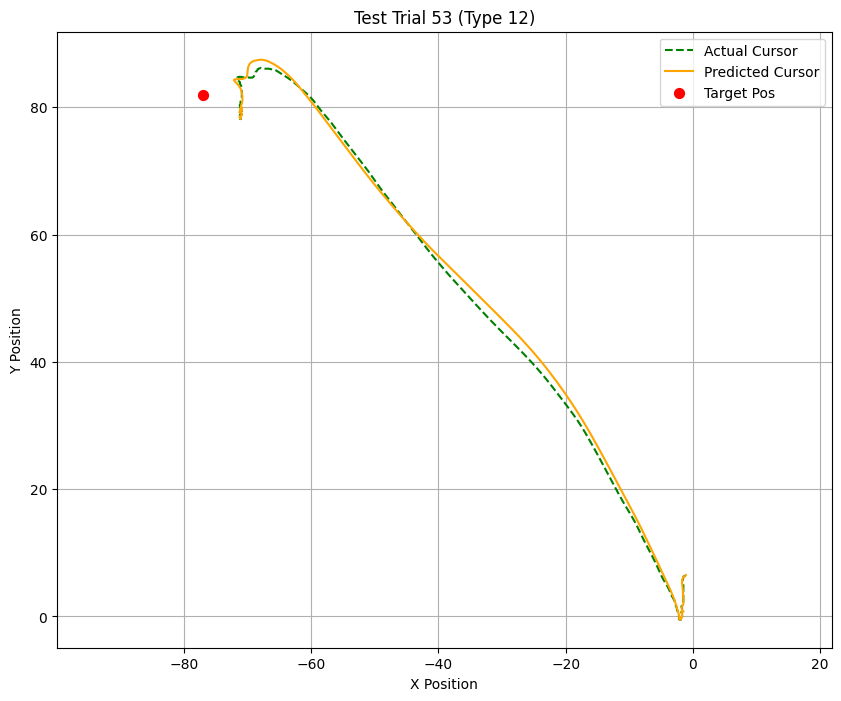

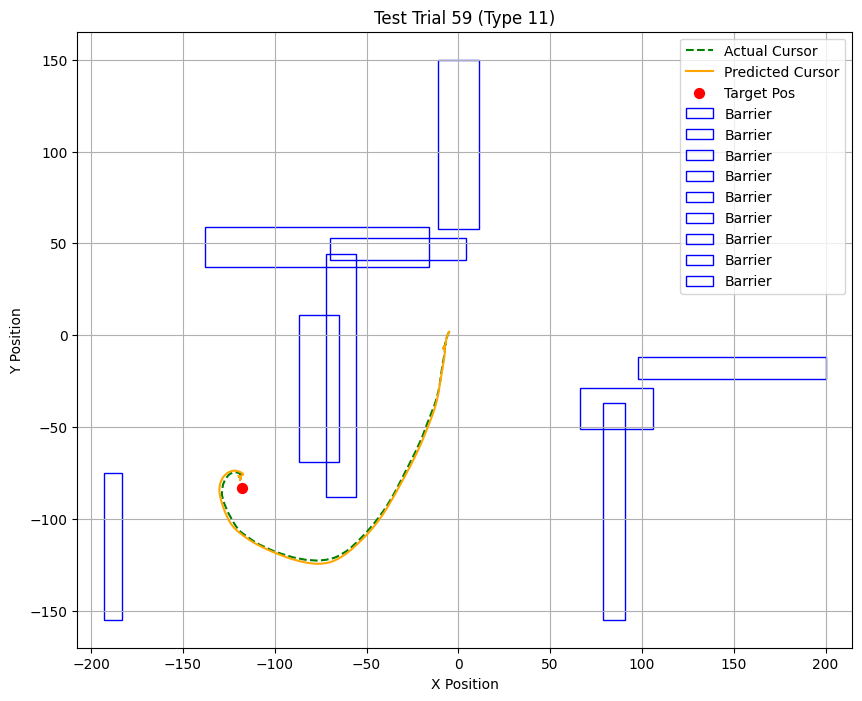

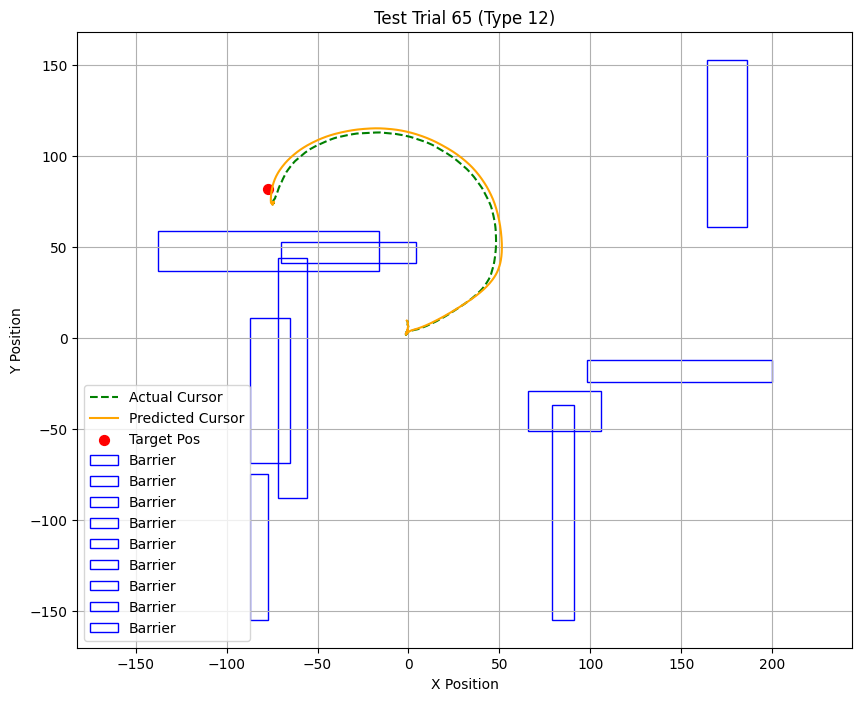

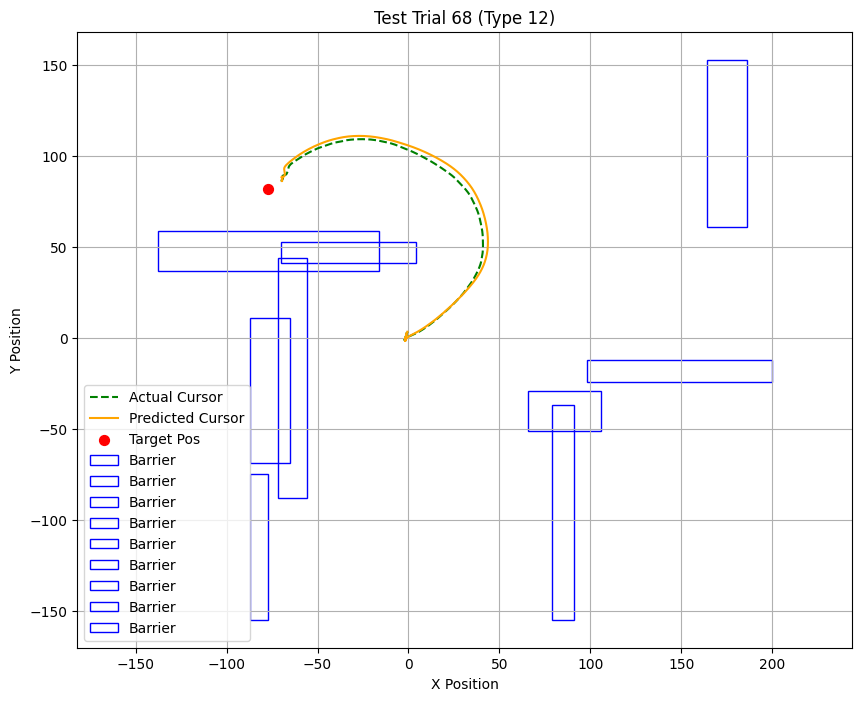

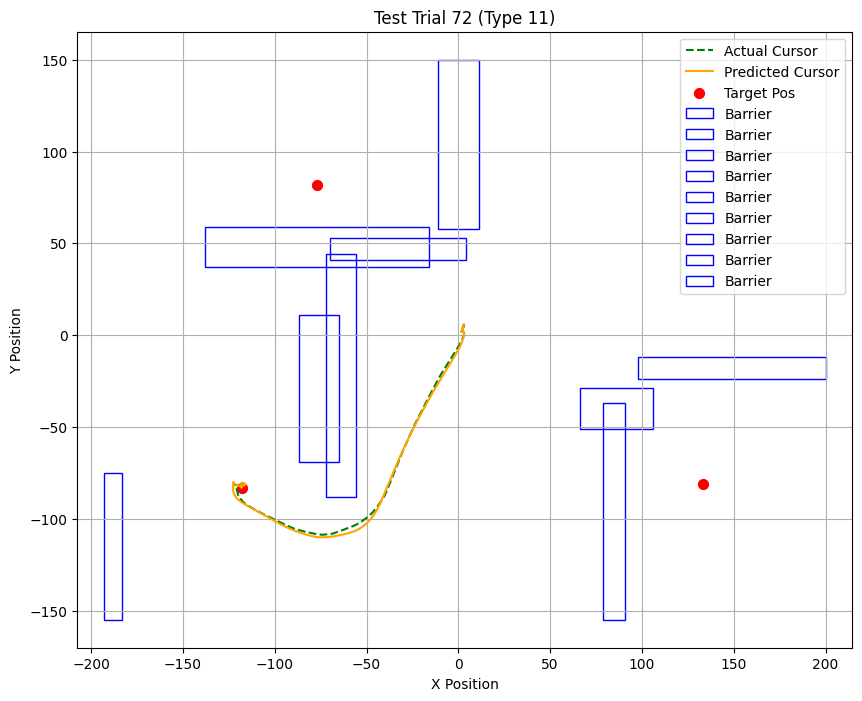

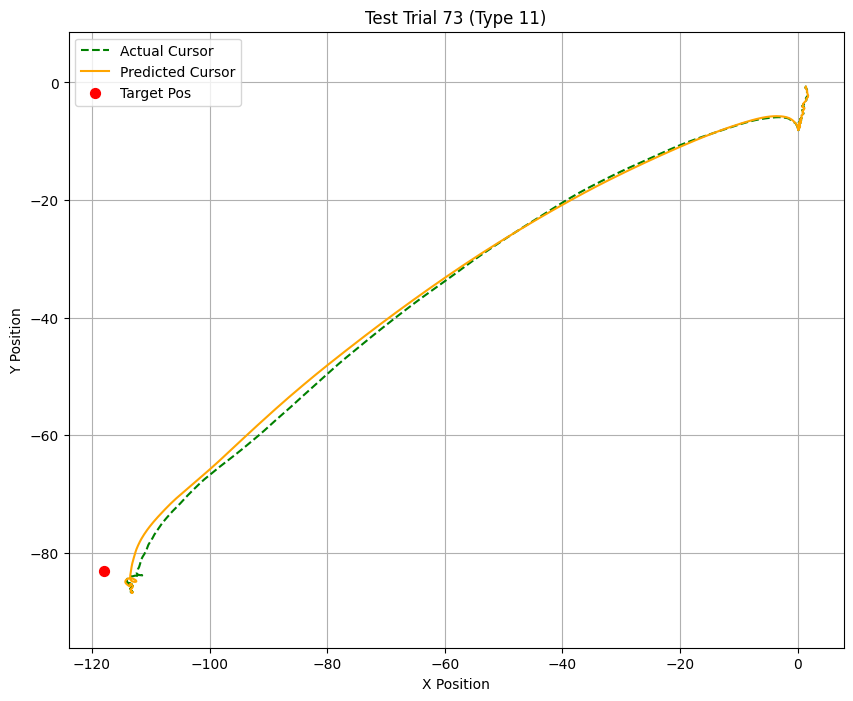

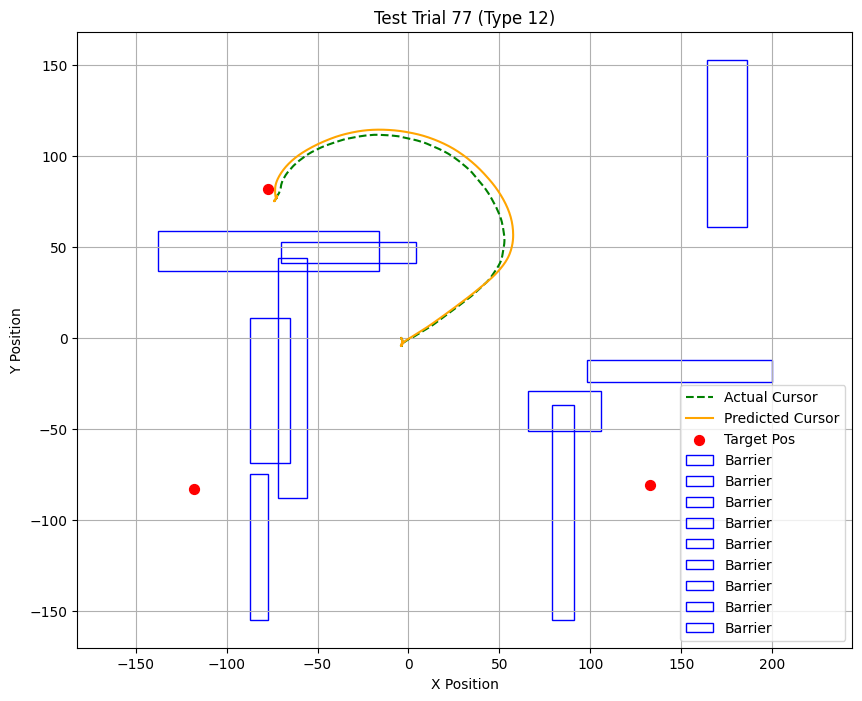

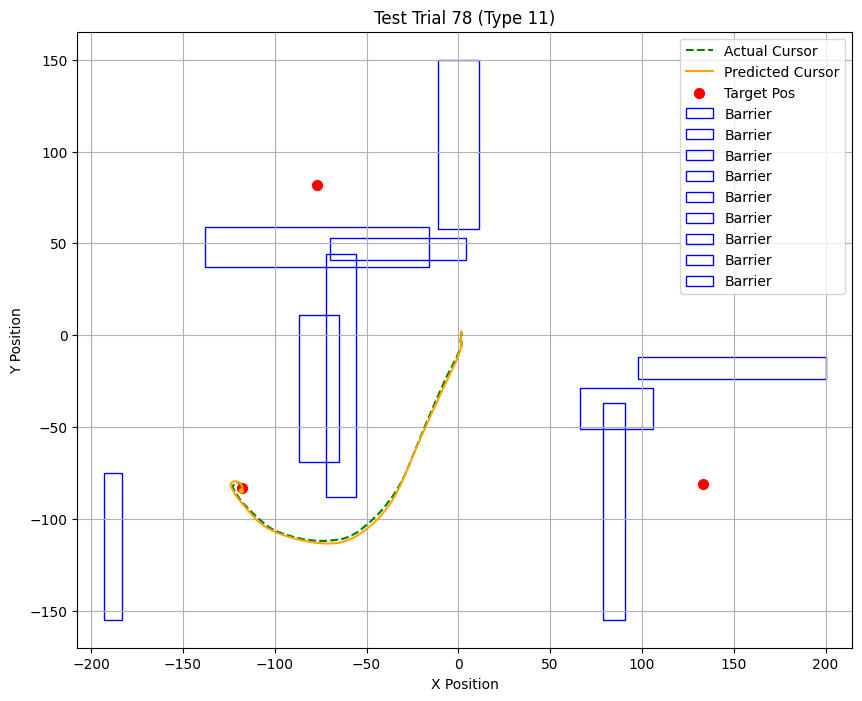

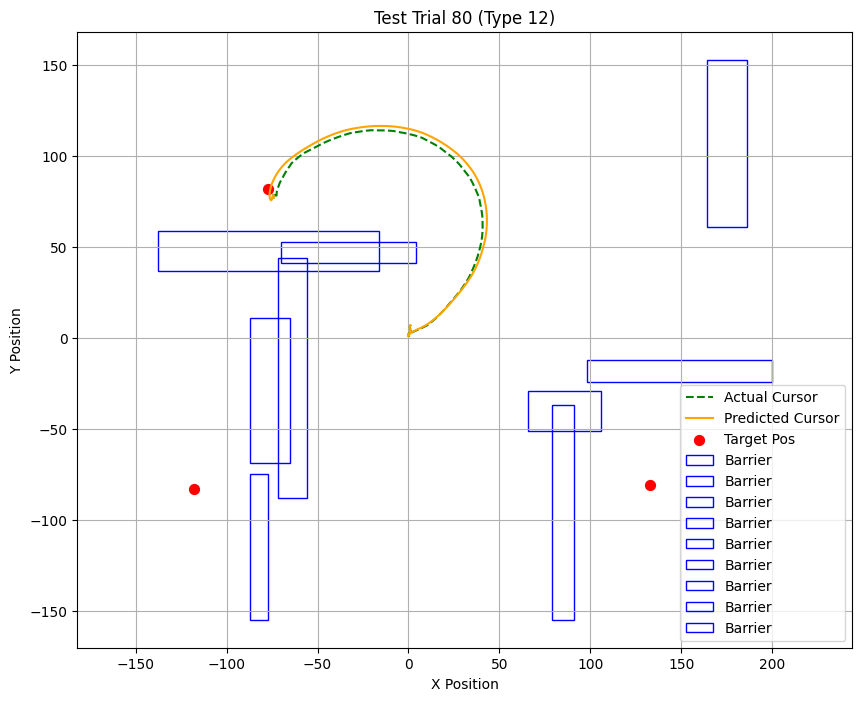

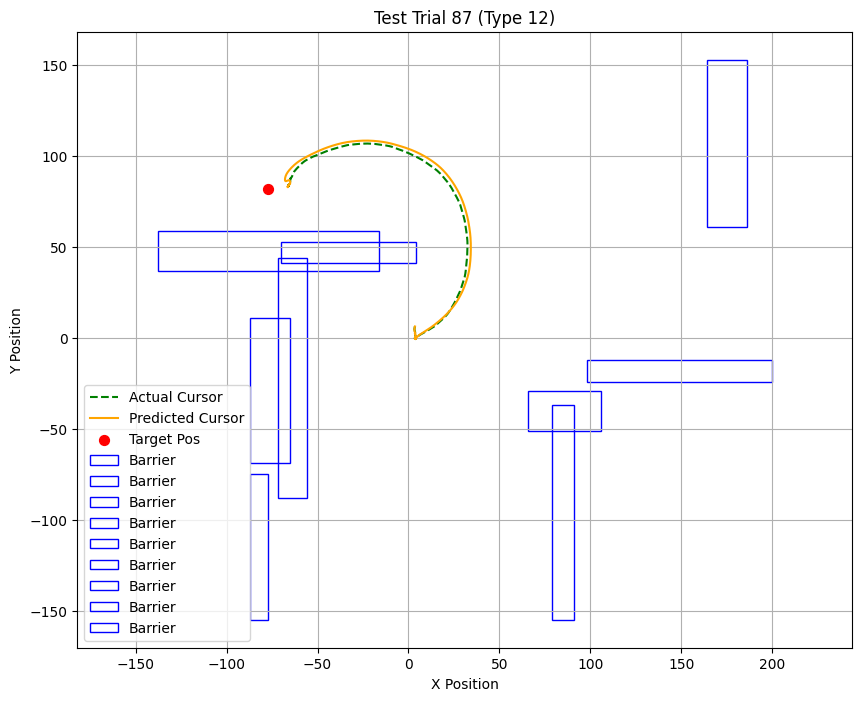

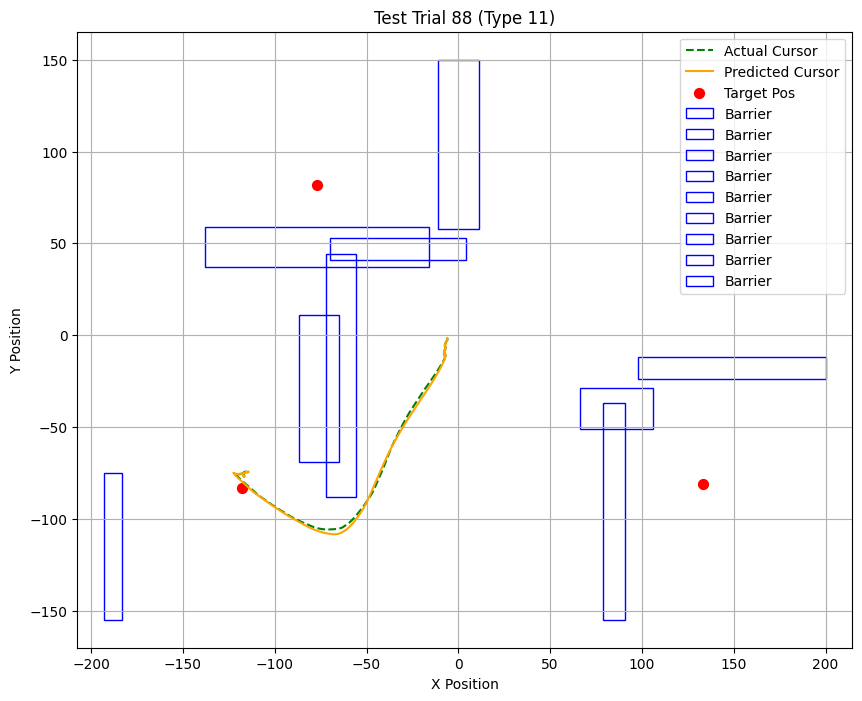

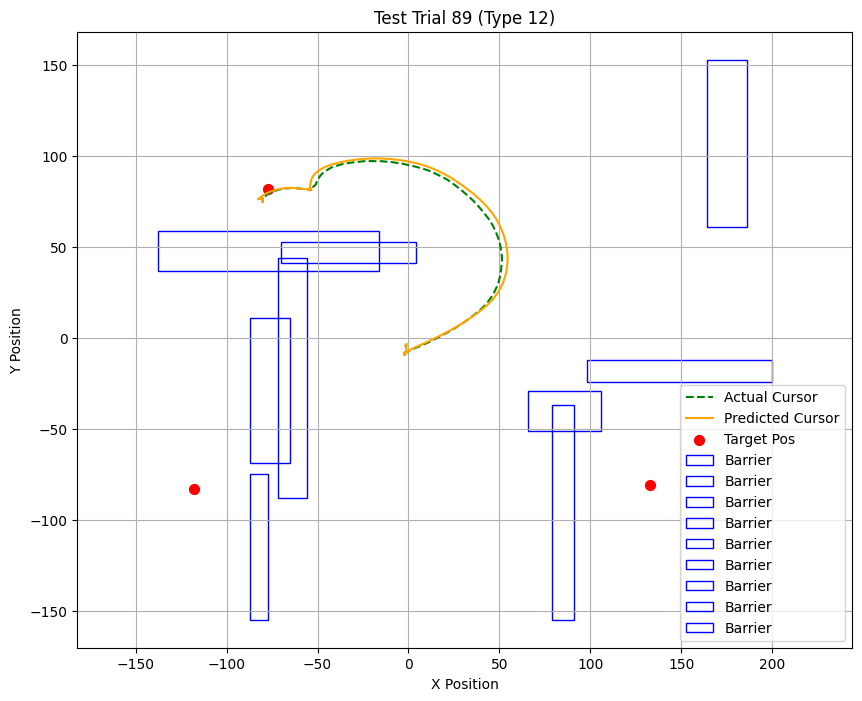

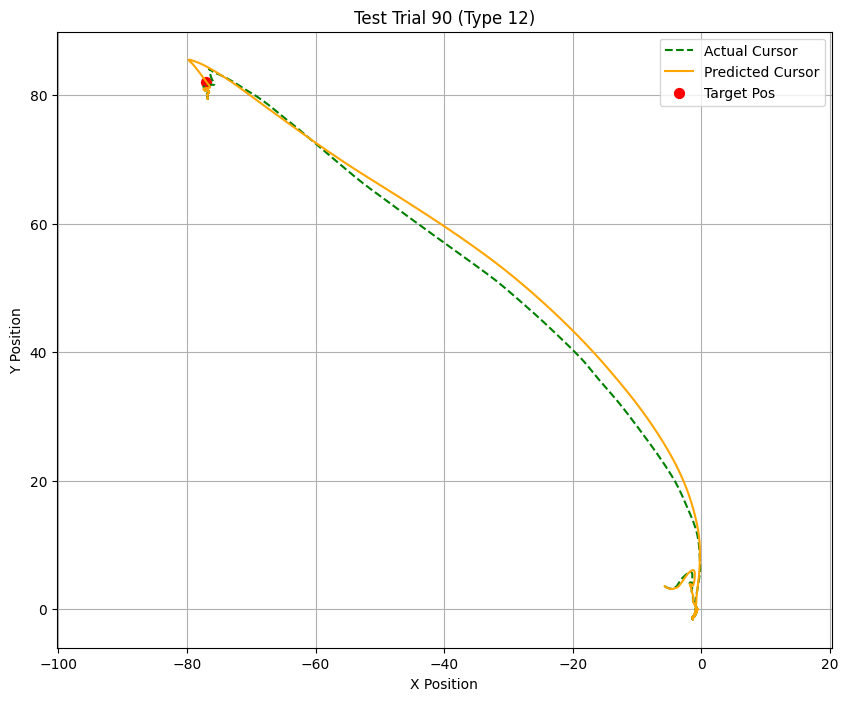

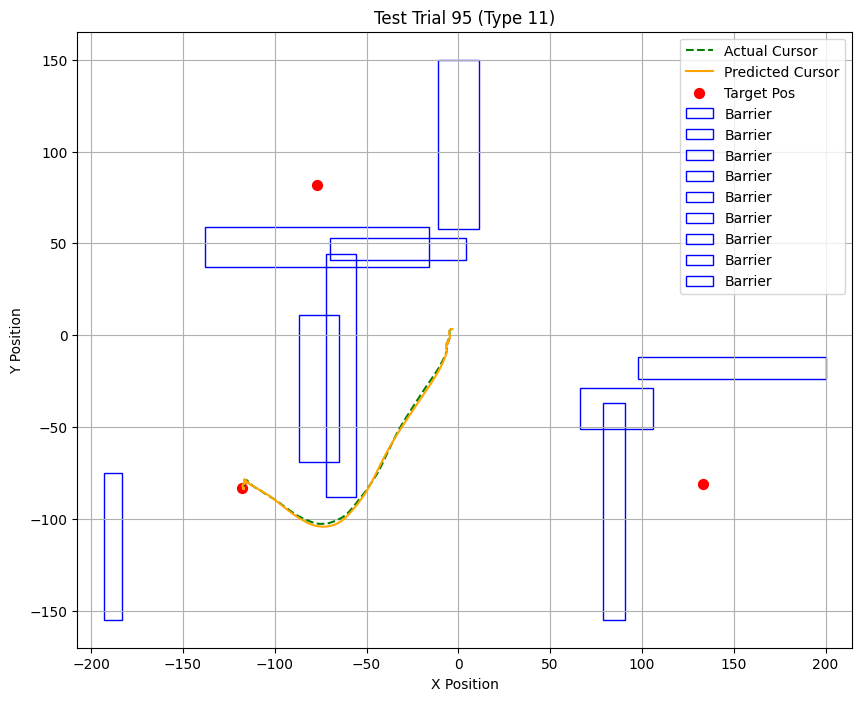

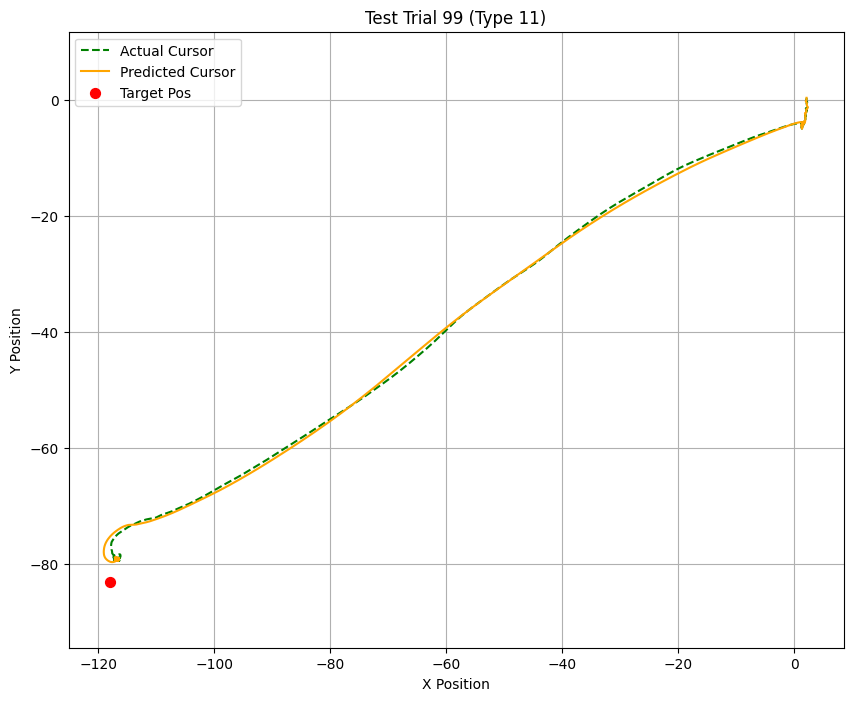

In [21]:
# Adjust training function to generate appropriate dimensions for Q
def train_kalman_filter(train_data):
    """Train Kalman Filter using training data to estimate noise covariances."""
    all_deltas = []  # To collect state transitions

    for trial in train_data:
        cursor_positions = preprocess_trial(trial)
        if cursor_positions.shape[0] < 2:
            continue  # Skip if there's not enough data

        # Calculate position differences (dx, dy) as velocity
        deltas = np.diff(cursor_positions, axis=0)
        velocities = np.hstack([deltas, deltas])  # Simulate [vx, vy] with deltas
        all_deltas.append(velocities)

    # Combine all deltas
    all_deltas = np.vstack(all_deltas)

    # Create a 4x4 process noise covariance matrix (Q)
    process_noise_cov = np.eye(4) * np.var(all_deltas)

    # Measurement noise covariance (R) can be estimated as the variance of observed positions
    all_positions = np.vstack([preprocess_trial(trial) for trial in train_data if len(trial["cursor_pos"]) > 0])
    measurement_noise_cov = np.eye(2) * np.var(all_positions, axis=0)

    return process_noise_cov, measurement_noise_cov


# Function to apply Kalman Filter to predict trajectory
def apply_kalman_filter(cursor_positions, Q, R):
    """Apply Kalman Filter to predict the entire cursor trajectory."""
    if cursor_positions.size == 0:
        return np.array([])

    # Define Kalman Filter with 4 state variables (x, y, vx, vy) and 2 measurements (x, y)
    kf = KalmanFilter(dim_x=4, dim_z=2)

    # Define the state transition matrix (F) and measurement matrix (H)
    kf.F = np.array([
        [1, 0, 1, 0],  # x_t = x_(t-1) + vx_(t-1)
        [0, 1, 0, 1],  # y_t = y_(t-1) + vy_(t-1)
        [0, 0, 1, 0],  # vx_t = vx_(t-1)
        [0, 0, 0, 1],  # vy_t = vy_(t-1)
    ])
    kf.H = np.array([
        [1, 0, 0, 0],  # Measure x
        [0, 1, 0, 0],  # Measure y
    ])

    # Covariances
    kf.P = np.eye(4) * 1000  # Initial uncertainty
    kf.Q = Q  # Process noise covariance (4x4 matrix)
    kf.R = R  # Measurement noise covariance (2x2 matrix)

    # Initialize the state vector [x, y, vx, vy]
    kf.x = np.array([cursor_positions[0, 0], cursor_positions[0, 1], 0, 0])  # [x, y, vx, vy]

    filtered_positions = []  # To store the full predicted trajectory

    for position in cursor_positions:
        kf.predict()  # Predict the next state
        kf.update(position)  # Update with measurement
        filtered_positions.append(kf.x[:2])  # Append only the predicted position [x, y]

    return np.array(filtered_positions)


# Train the Kalman Filter on the training data
Q, R = train_kalman_filter(train_data)

# Apply Kalman Filter to testing trials
predicted_test_trajectories = []
for trial in test_data:
    cursor_positions = preprocess_trial(trial)
    predicted_cursor = apply_kalman_filter(cursor_positions, Q, R)
    predicted_test_trajectories.append(predicted_cursor)

# Plot actual and predicted trajectories for test trials
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    # Start a new figure for each test trial
    plt.figure(figsize=(10, 8))

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        plt.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        plt.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        plt.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            plt.gca().add_patch(rect)

    # Add plot labels and title
    plt.title(f"Test Trial {trial['trial_id']} (Type {trial['trial_type']})")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    # Show the plot
    plt.show()


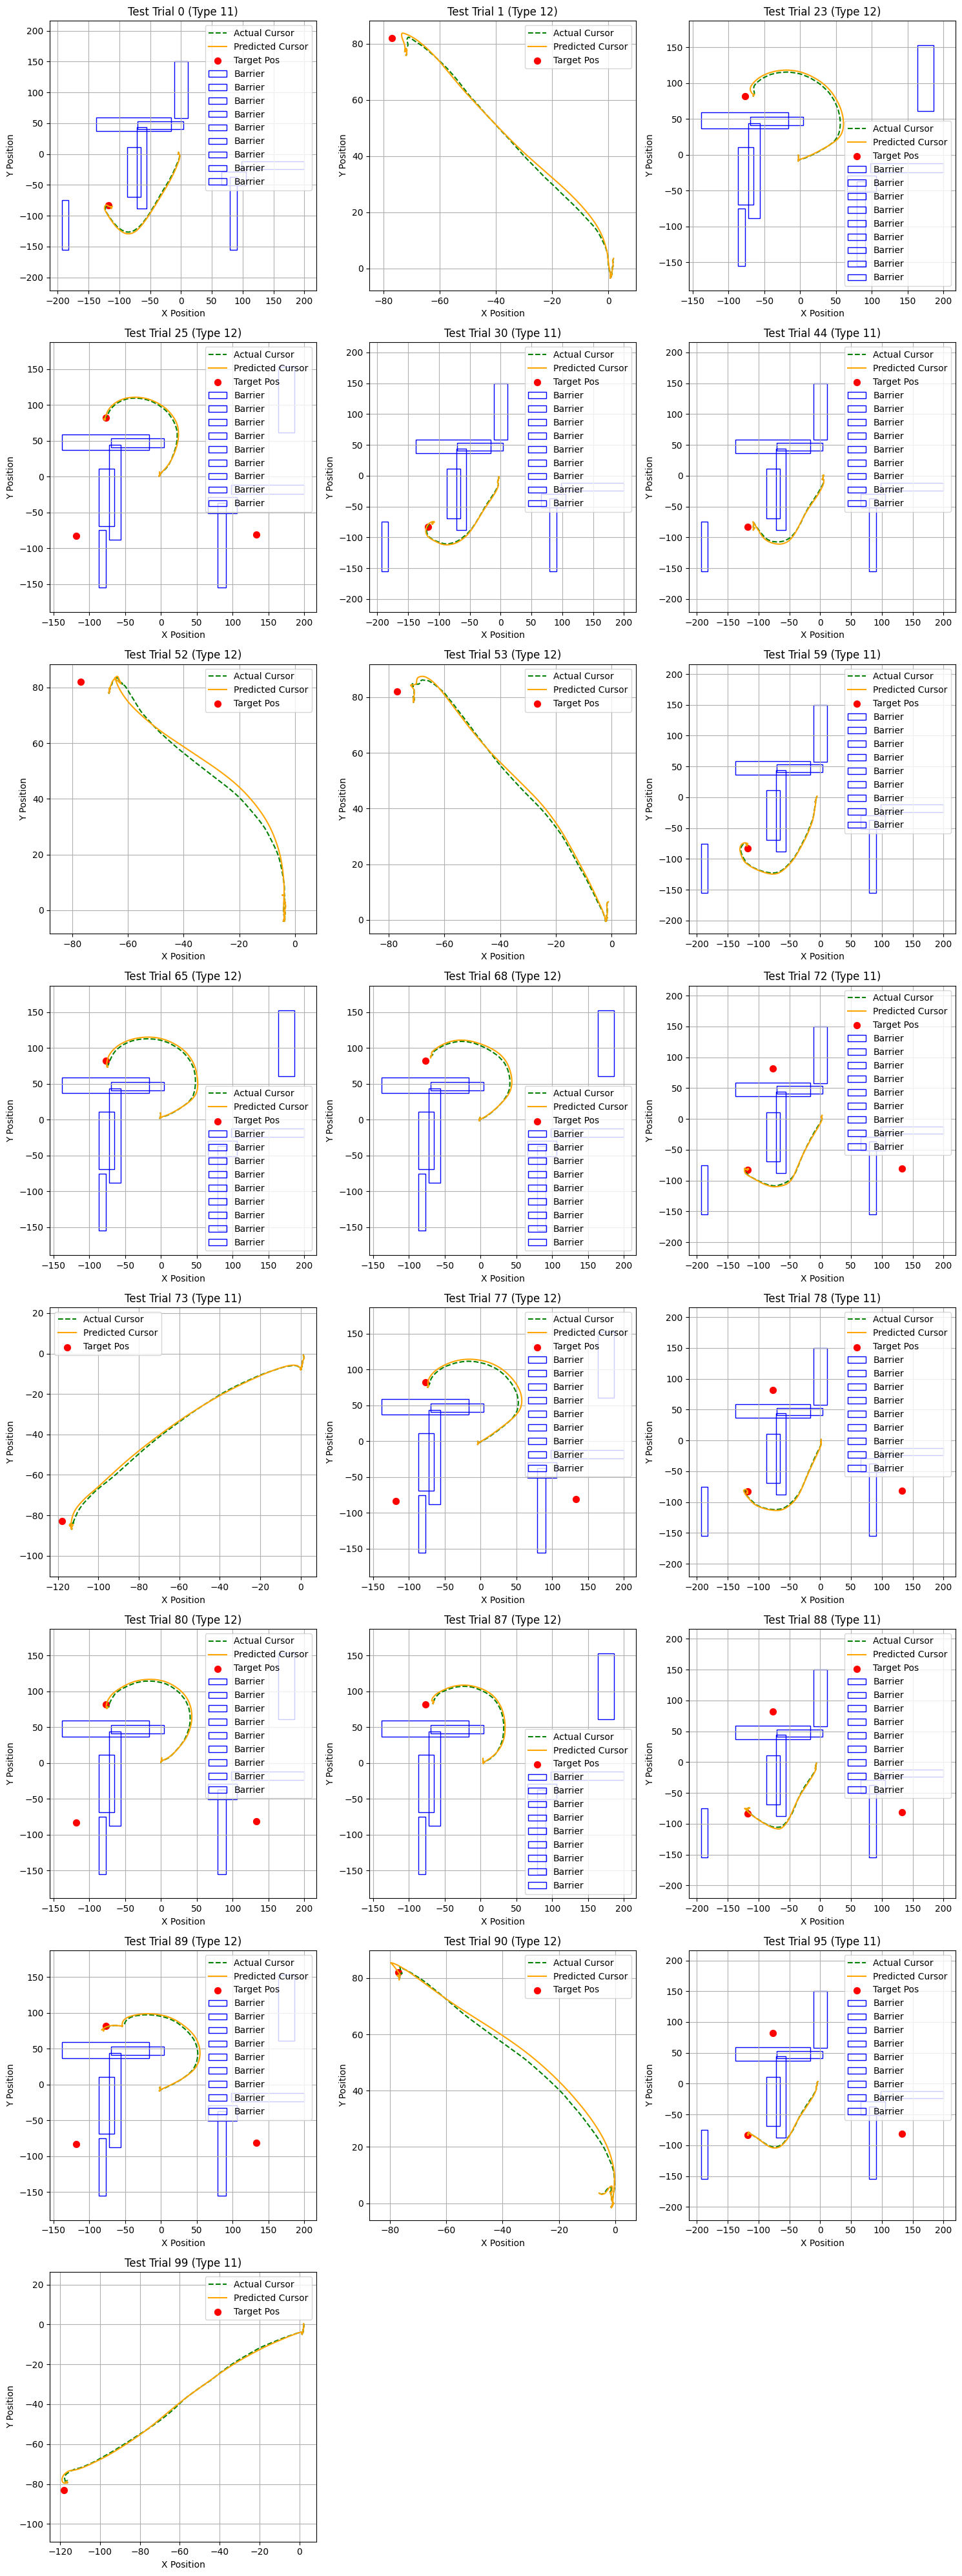

In [22]:
# Set up the grid for plotting
n_cols = 3  # Number of columns in the grid
n_rows = (len(test_data) + n_cols - 1) // n_cols  # Number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot actual and predicted trajectories for test trials
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    ax = axes[i]  # Select subplot axis

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        ax.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        ax.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        ax.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            ax.add_patch(rect)

    # Add plot labels and title
    ax.set_title(f"Test Trial {trial['trial_id']} (Type {trial['trial_type']})")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)
    ax.axis("equal")

# Hide unused subplots
for j in range(len(test_data), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


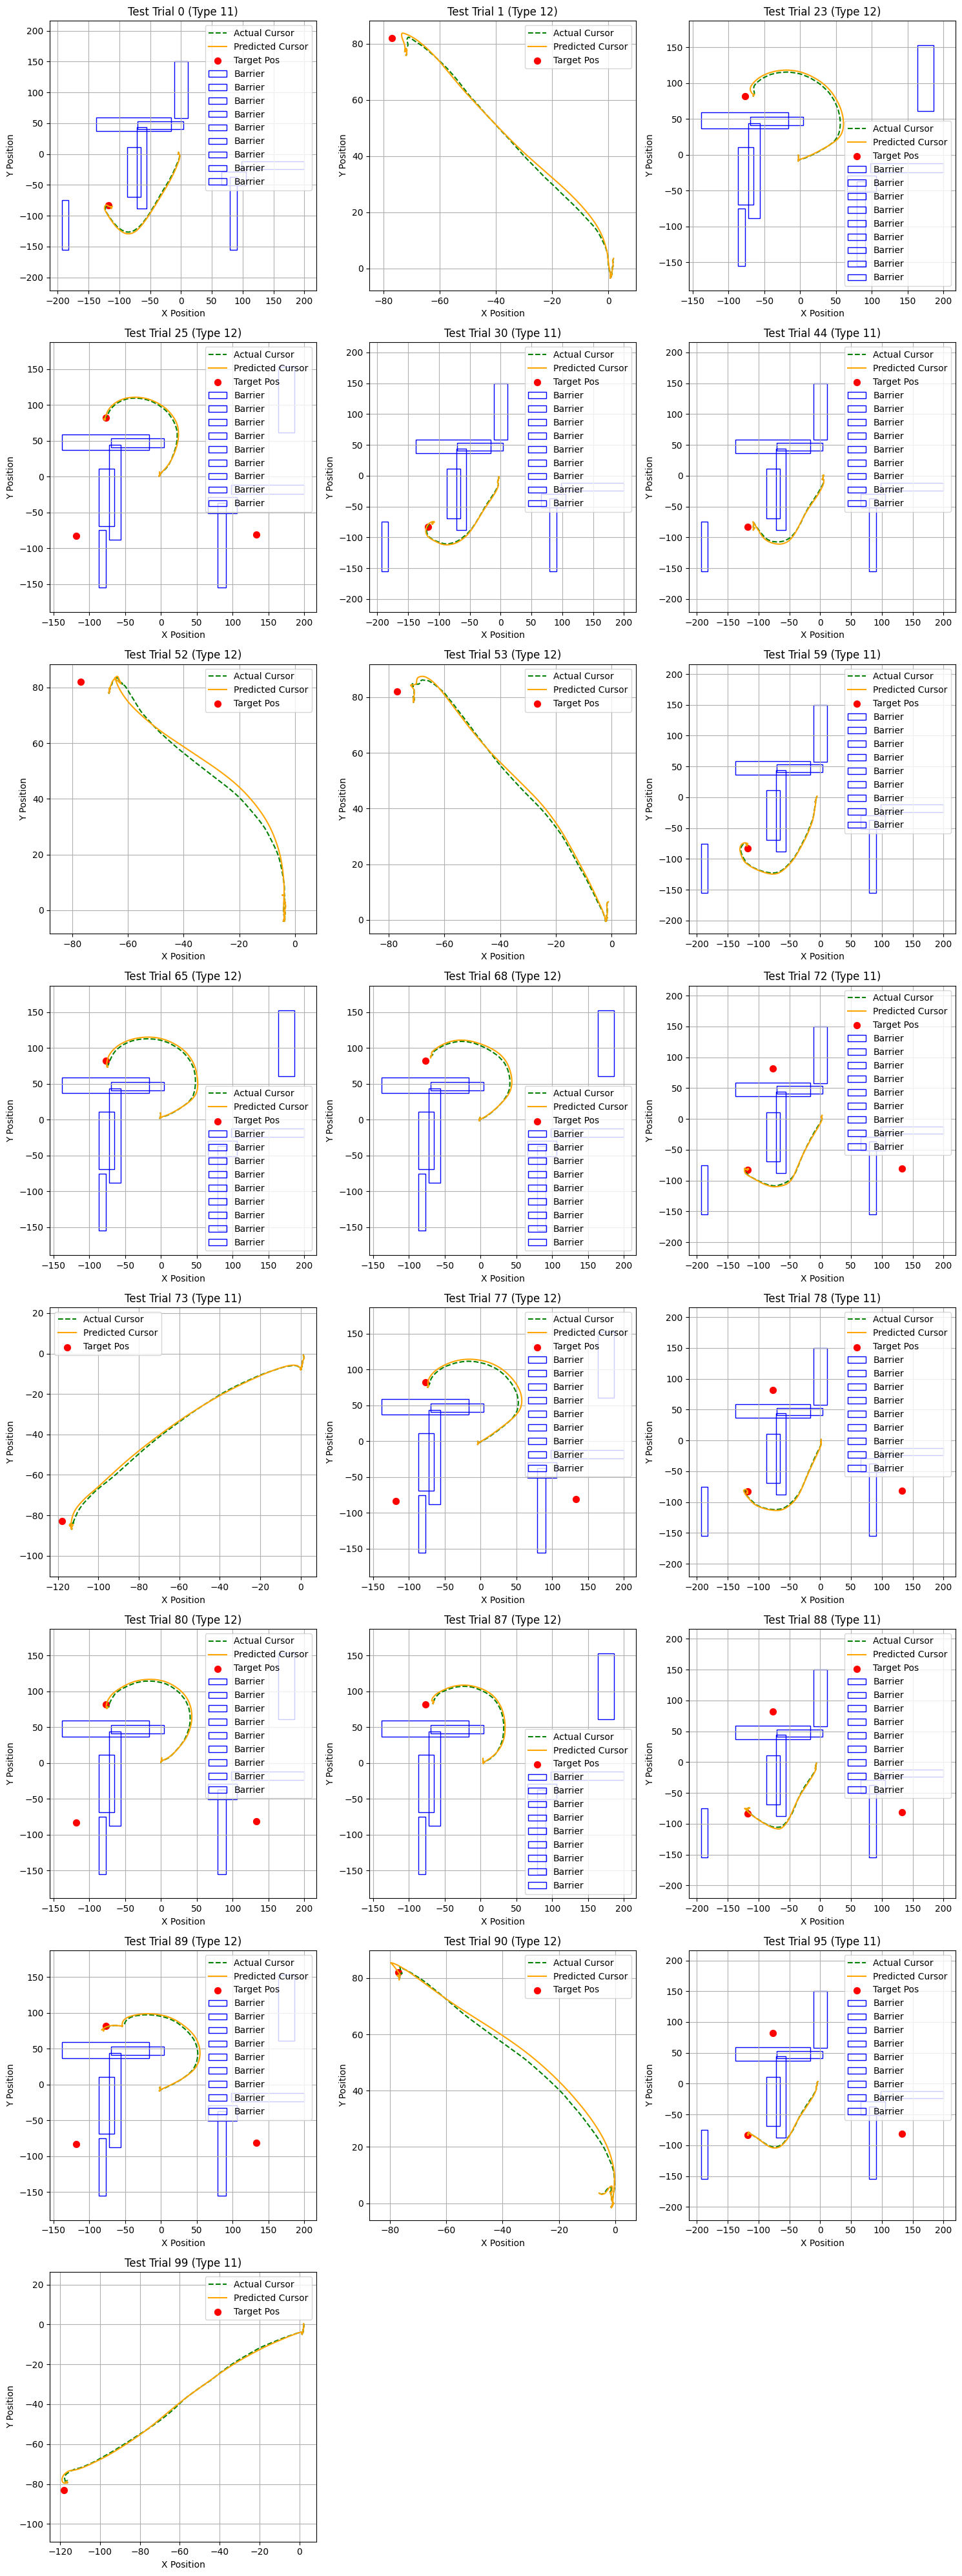

In [23]:
# Split data into training and testing sets based on trial type
test_types = [11, 12]  # Define trial types for test set
train_data = [trial for trial in trial_data if trial["trial_type"] not in test_types]
test_data = [trial for trial in trial_data if trial["trial_type"] in test_types]

# Train the Kalman Filter on the training data
Q, R = train_kalman_filter(train_data)

# Apply Kalman Filter to testing trials
predicted_test_trajectories = []
for trial in test_data:
    cursor_positions = preprocess_trial(trial)
    predicted_cursor = apply_kalman_filter(cursor_positions, Q, R)
    predicted_test_trajectories.append(predicted_cursor)

# Plot actual and predicted trajectories for test trials in a grid layout
n_cols = 3  # Number of columns in the grid
n_rows = (len(test_data) + n_cols - 1) // n_cols  # Calculate number of rows dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot actual and predicted trajectories
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    ax = axes[i]  # Select subplot axis

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        ax.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        ax.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        ax.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            ax.add_patch(rect)

    # Add plot labels and title
    ax.set_title(f"Test Trial {trial['trial_id']} (Type {trial['trial_type']})")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)
    ax.axis("equal")

# Hide unused subplots
for j in range(len(test_data), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


accuracy

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize lists to store metrics for all test trials
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

# Evaluate each test trial
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    # Ensure the shapes are compatible
    if actual_cursor.shape != predicted_cursor.shape or actual_cursor.size == 0 or predicted_cursor.size == 0:
        print(f"Skipping trial {trial['trial_id']} due to mismatched or empty data.")
        continue

    # Compute metrics
    mse = mean_squared_error(actual_cursor, predicted_cursor)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_cursor, predicted_cursor)
    r2 = r2_score(actual_cursor, predicted_cursor)

    # Append metrics to the lists
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    # Print metrics for each trial
    print(f"Trial {trial['trial_id']} (Type {trial['trial_type']}):")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")

# Aggregate metrics over all test trials
avg_mse = np.mean(mse_list) if mse_list else float("nan")
avg_rmse = np.mean(rmse_list) if rmse_list else float("nan")
avg_mae = np.mean(mae_list) if mae_list else float("nan")
avg_r2 = np.mean(r2_list) if r2_list else float("nan")

# Print overall metrics
print("\nOverall Metrics for Test Data:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average R² Score: {avg_r2:.4f}")


Trial 0 (Type 11):
  MSE: 0.3979
  RMSE: 0.6308
  MAE: 0.2296
  R² Score: 0.9998
Trial 1 (Type 12):
  MSE: 0.2869
  RMSE: 0.5356
  MAE: 0.1993
  R² Score: 0.9998
Trial 23 (Type 12):
  MSE: 0.9480
  RMSE: 0.9736
  MAE: 0.3461
  R² Score: 0.9992
Trial 25 (Type 12):
  MSE: 0.2553
  RMSE: 0.5053
  MAE: 0.1858
  R² Score: 0.9998
Trial 30 (Type 11):
  MSE: 0.2660
  RMSE: 0.5158
  MAE: 0.2187
  R² Score: 0.9998
Trial 44 (Type 11):
  MSE: 0.4162
  RMSE: 0.6452
  MAE: 0.2794
  R² Score: 0.9998
Trial 52 (Type 12):
  MSE: 0.3539
  RMSE: 0.5949
  MAE: 0.2060
  R² Score: 0.9996
Trial 53 (Type 12):
  MSE: 0.1762
  RMSE: 0.4198
  MAE: 0.1702
  R² Score: 0.9999
Trial 59 (Type 11):
  MSE: 0.1536
  RMSE: 0.3919
  MAE: 0.1708
  R² Score: 0.9999
Trial 65 (Type 12):
  MSE: 0.5898
  RMSE: 0.7680
  MAE: 0.2727
  R² Score: 0.9995
Trial 68 (Type 12):
  MSE: 0.4491
  RMSE: 0.6701
  MAE: 0.2396
  R² Score: 0.9996
Trial 72 (Type 11):
  MSE: 0.2896
  RMSE: 0.5381
  MAE: 0.2109
  R² Score: 0.9999
Trial 73 (Type 11)

**HMM yayy**

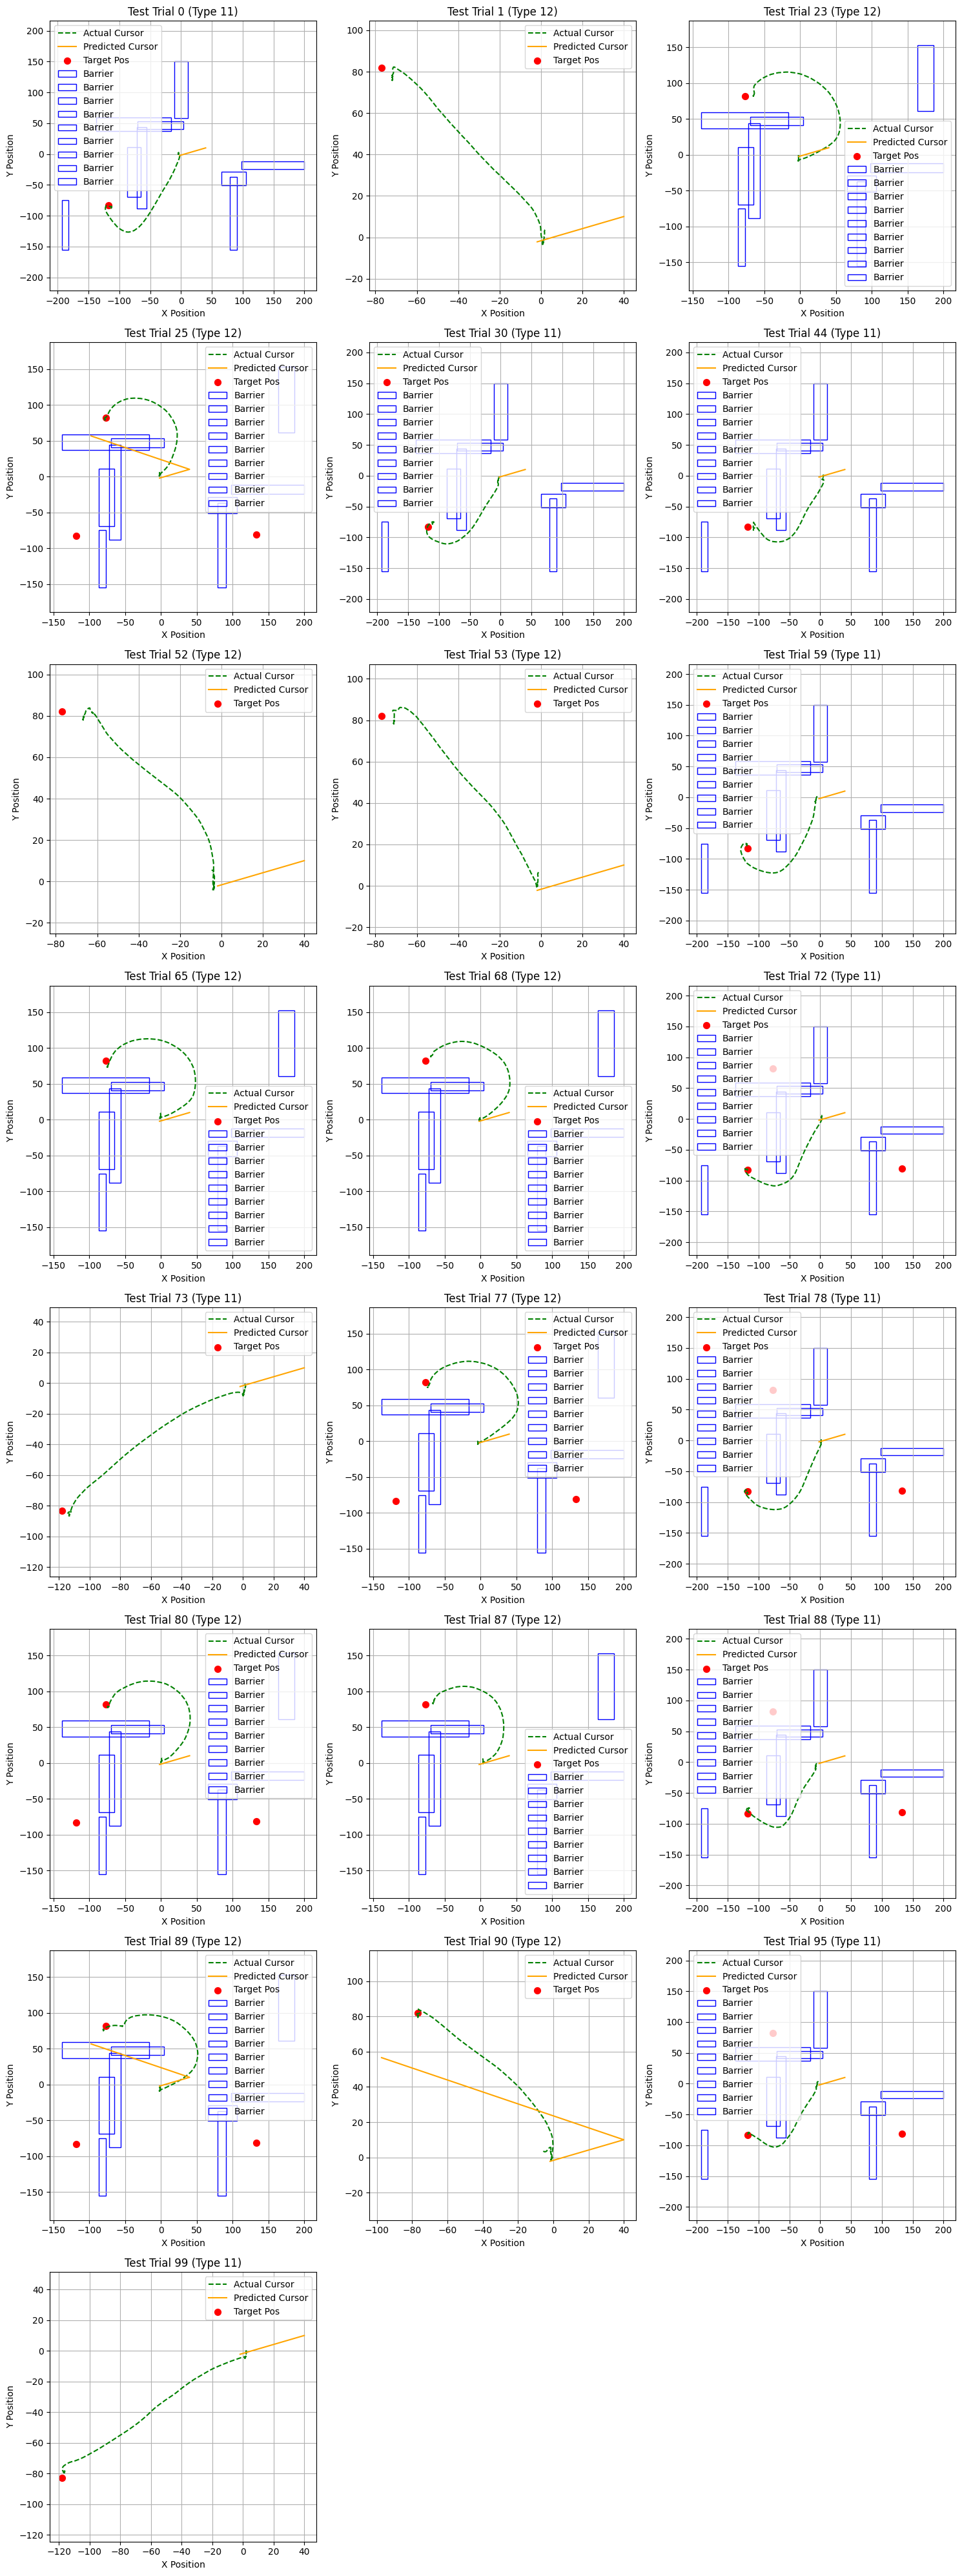

In [17]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler

# Preprocess the data
def preprocess_hmm_data(data):
    """Prepare cursor position data for HMM."""
    all_positions = []
    for trial in data:
        cursor_positions = np.array(trial["cursor_pos"])
        if cursor_positions.size > 0:
            all_positions.append(cursor_positions)
    return all_positions

# Prepare training and testing data
train_cursor_positions = preprocess_hmm_data(train_data)
test_cursor_positions = preprocess_hmm_data(test_data)

# Flatten training data to fit HMM
scaler = StandardScaler()
train_data_flat = np.vstack(train_cursor_positions)
train_data_scaled = scaler.fit_transform(train_data_flat)

# Train HMM model
n_components = 4  # Number of hidden states
hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=42)
hmm_model.fit(train_data_scaled)

# Predict trajectories for testing data
predicted_test_trajectories = []
for cursor_positions in test_cursor_positions:
    if cursor_positions.size == 0:
        predicted_test_trajectories.append(np.array([]))
        continue

    # Scale the test data using the same scaler
    test_data_scaled = scaler.transform(cursor_positions)

    # Predict hidden states and reconstruct trajectory
    hidden_states = hmm_model.predict(test_data_scaled)
    predicted_cursor = hmm_model.means_[hidden_states]  # Map states to mean positions
    predicted_cursor = scaler.inverse_transform(predicted_cursor)  # Transform back to original scale

    predicted_test_trajectories.append(predicted_cursor)

# Plot actual and predicted trajectories for test trials
n_cols = 3  # Number of columns in the grid
n_rows = (len(test_data) + n_cols - 1) // n_cols  # Calculate number of rows dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot actual and predicted trajectories
for i, trial in enumerate(test_data):
    # Extract actual and predicted cursor positions
    actual_cursor = np.array(trial["cursor_pos"])
    predicted_cursor = predicted_test_trajectories[i]

    ax = axes[i]  # Select subplot axis

    # Plot actual cursor trajectory
    if actual_cursor.size > 0:
        ax.plot(actual_cursor[:, 0], actual_cursor[:, 1], label="Actual Cursor", linestyle="--", color="green")

    # Plot predicted cursor trajectory
    if predicted_cursor.size > 0:
        ax.plot(predicted_cursor[:, 0], predicted_cursor[:, 1], label="Predicted Cursor", color="orange")

    # Plot target positions
    target_pos = np.array(trial["target_pos"])
    if target_pos.size > 0:
        ax.scatter(target_pos[:, 0], target_pos[:, 1], color="red", label="Target Pos", s=50)

    # Plot barriers
    barrier_pos = np.array(trial["barrier_pos"])
    if barrier_pos.size > 0:
        for barrier in barrier_pos:
            # Assuming barrier is represented as [x_center, y_center, half_width, half_height]
            x, y, half_width, half_height = barrier
            rect = patches.Rectangle(
                (x - half_width, y - half_height),  # Bottom-left corner
                2 * half_width,  # Width
                2 * half_height,  # Height
                linewidth=1,
                edgecolor="blue",
                facecolor="none",
                label="Barrier"
            )
            ax.add_patch(rect)

    # Add plot labels and title
    ax.set_title(f"Test Trial {trial['trial_id']} (Type {trial['trial_type']})")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)
    ax.axis("equal")

# Hide unused subplots
for j in range(len(test_data), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
from transformers import TFBertModel
import tensorflow as tf

# Example using a simple transformer-based model
model = TFBertModel.from_pretrained('bert-base-uncased')
input_layer = tf.keras.layers.Input(shape=(time_steps, input_features))
transformer_output = model(input_layer)[0]
output_layer = tf.keras.layers.Dense(2)(transformer_output)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.fit(train_data, train_targets, epochs=50, batch_size=32)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

NameError: name 'time_steps' is not defined

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# Define preprocessing function
def preprocess_trial_for_cnn(trial, time_steps=50):
    """Preprocess a trial to align inputs and outputs for CNN."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    spike_data = np.array(trial["spike_data"])        # Shape (num_neurons, num_spikes)

    # Create input features by binning spike data and aligning with cursor positions
    num_bins = min(len(cursor_positions), time_steps)  # Ensure time_steps alignment
    binned_spike_data = np.zeros((num_bins, len(spike_data)))

    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(
            spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1)
        )
        binned_spike_data[:, neuron_idx] = binned_spikes

    # Truncate cursor positions and spike data to `time_steps`
    truncated_cursor_positions = cursor_positions[:num_bins]
    binned_spike_data = binned_spike_data[:num_bins]

    return binned_spike_data, truncated_cursor_positions

# Preprocess all trials
input_features = []
output_labels = []

for trial in trial_data:
    features, labels = preprocess_trial_for_cnn(trial)
    input_features.append(features)
    output_labels.append(labels)

# Convert to numpy arrays
input_features = np.array(input_features)  # Shape: (num_trials, time_steps, num_neurons)
output_labels = np.array(output_labels)    # Shape: (num_trials, time_steps, 2)

# Split data into training and testing sets based on trial type
train_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] not in [5, 10]]
test_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] in [5, 10]]

train_inputs, train_labels = input_features[train_indices], output_labels[train_indices]
test_inputs, test_labels = input_features[test_indices], output_labels[test_indices]

# Print dataset shapes
print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(train_inputs.shape[1], train_inputs.shape[2])),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(test_labels.shape[-1] * test_labels.shape[1]),  # Output for all time steps
])

# Reshape output labels for compatibility with Dense layer
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 2)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 2, 2)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual = test_labels[i].reshape(-1, 2)
    predicted = predicted_test_labels[i]

    ax = axes[i]
    ax.plot(actual[:, 0], actual[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (142,) + inhomogeneous part.

In [24]:
import numpy as np

def preprocess_trial_for_cnn(trial, time_steps=50, num_neurons=50):
    """Preprocess a trial to align cursor positions and spike data."""
    cursor_positions = np.array(trial["cursor_pos"])  # Shape (T, 2)
    spike_data = trial["spike_data"]  # List of spike timestamps for each neuron

    # Ensure `cursor_positions` has `time_steps`
    cursor_positions_padded = np.zeros((time_steps, 2))  # Padding with zeros
    num_cursor_steps = min(len(cursor_positions), time_steps)
    cursor_positions_padded[:num_cursor_steps] = cursor_positions[:num_cursor_steps]

    # Ensure `spike_data` has fixed bins and neurons
    binned_spike_data = np.zeros((time_steps, num_neurons))  # Shape (time_steps, num_neurons)
    for neuron_idx, spikes in enumerate(spike_data):
        if neuron_idx >= num_neurons:
            break  # Limit to `num_neurons`

        # Bin spike data within the trial duration
        num_bins = min(len(cursor_positions), time_steps)  # Align with time steps
        binned_spikes, _ = np.histogram(
            spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1)
        )
        binned_spike_data[:num_bins, neuron_idx] = binned_spikes[:num_bins]

    return binned_spike_data, cursor_positions_padded


Train Inputs: (89, 50, 50), Train Labels: (89, 50, 2)
Test Inputs: (11, 50, 50), Test Labels: (11, 50, 2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 15.0849 - mae: 3.1839 - val_loss: 17.6888 - val_mae: 3.4764
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 14.4549 - mae: 3.0701 - val_loss: 16.9766 - val_mae: 3.4030
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 15.1151 - mae: 3.1472 - val_loss: 16.1370 - val_mae: 3.3181
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.3763 - mae: 2.9966 - val_loss: 15.7273 - val_mae: 3.2604
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 12.1330 - mae: 2.7960 - val_loss: 15.5603 - val_mae: 3.2251
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 12.2827 - mae: 2.7768 - val_loss: 15.5264 - val_mae: 3.2255
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 11.6035 - mae: 2.7385 - val_loss: 15.4536 - val_mae: 3.2642
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.9554 - mae: 2.6333 - val_loss: 15.4348 - val_mae: 3.3052
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 11.393

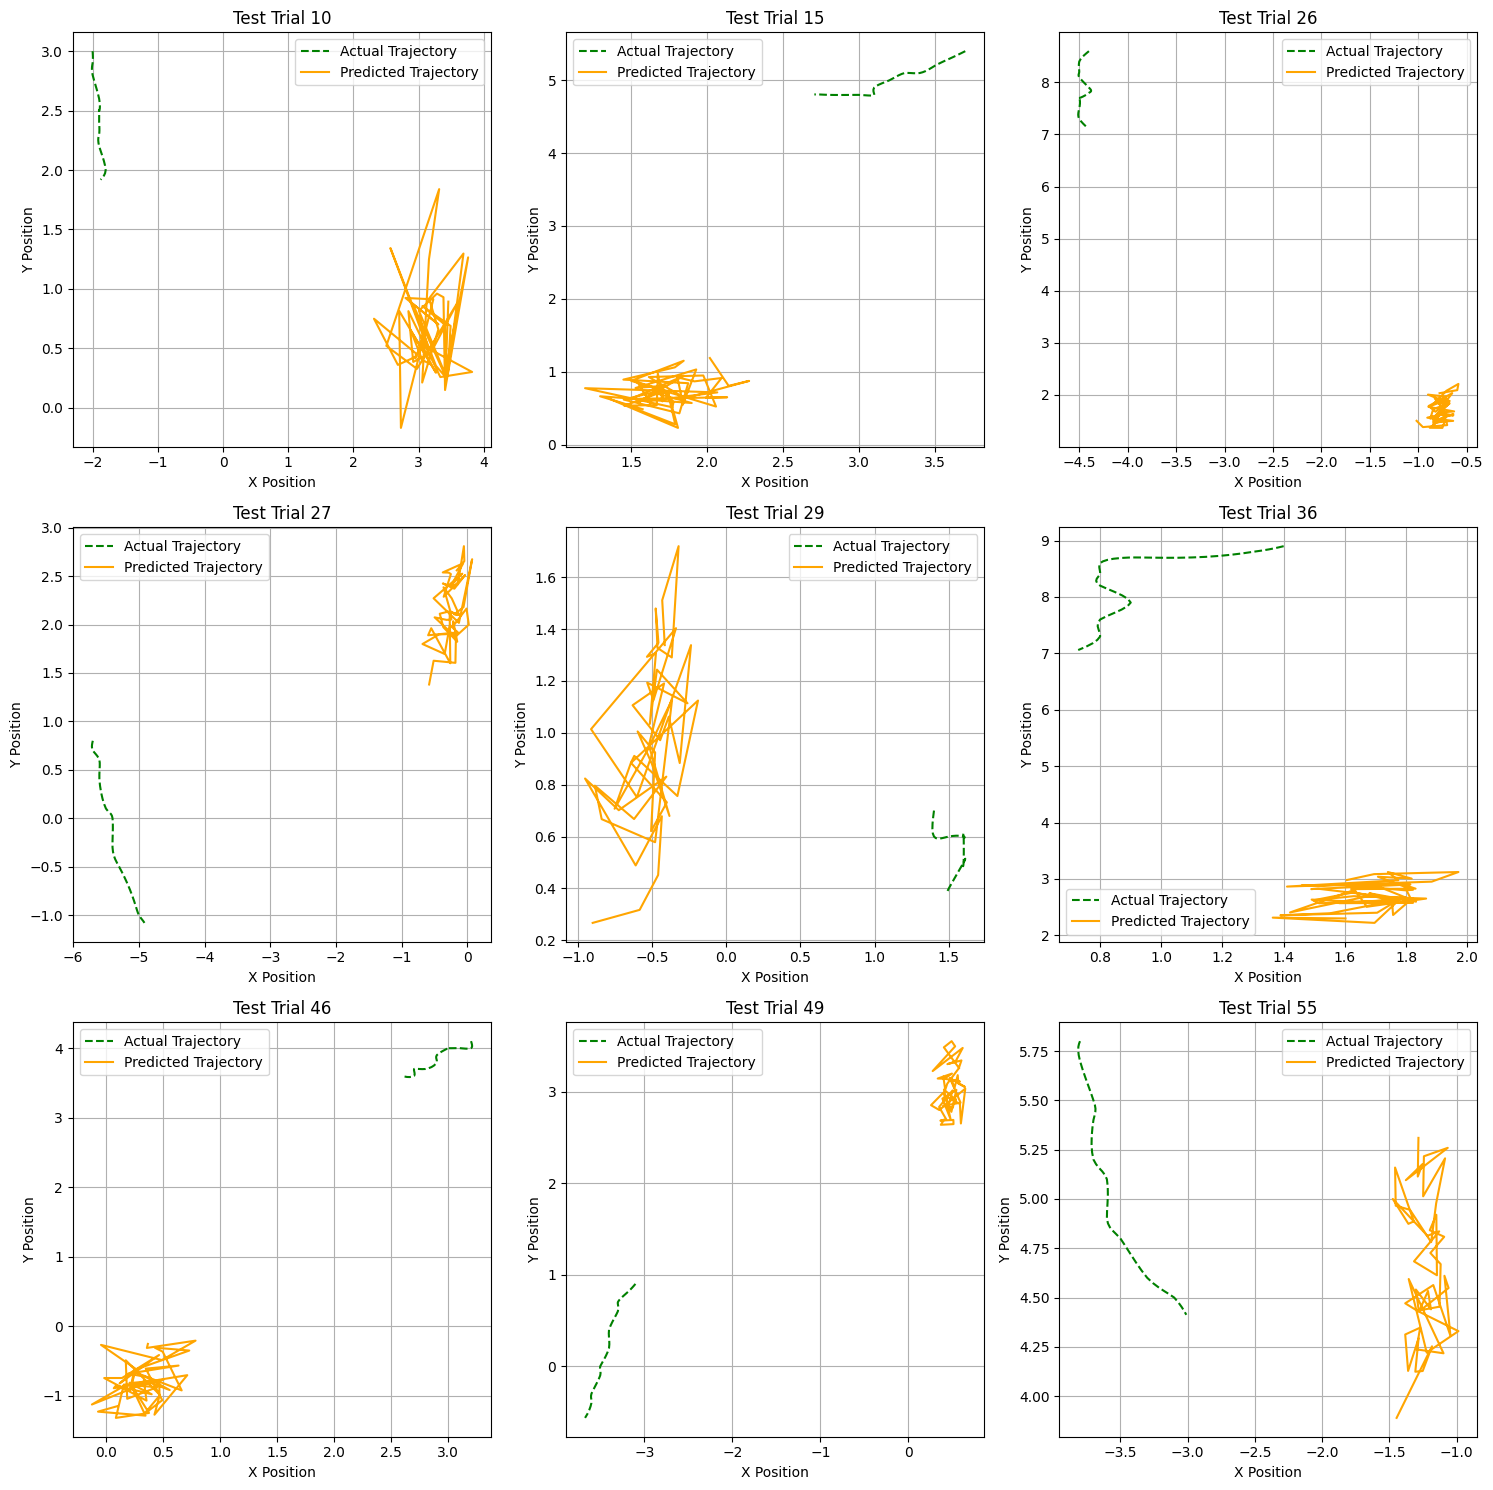

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preprocess all trials
time_steps = 50
num_neurons = 50

input_features = []
output_labels = []

for trial in trial_data:
    features, labels = preprocess_trial_for_cnn(trial, time_steps, num_neurons)
    input_features.append(features)
    output_labels.append(labels)

# Convert to numpy arrays
input_features = np.array(input_features)  # Shape: (num_trials, time_steps, num_neurons)
output_labels = np.array(output_labels)    # Shape: (num_trials, time_steps, 2)

# Split data into training and testing based on trial type
train_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] not in [5, 10]]
test_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] in [5, 10]]

train_inputs, train_labels = input_features[train_indices], output_labels[train_indices]
test_inputs, test_labels = input_features[test_indices], output_labels[test_indices]

# Print dataset shapes
print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(train_inputs.shape[1], train_inputs.shape[2])),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(test_labels.shape[-1] * test_labels.shape[1]),  # Output for all time steps
])

# Reshape output labels for compatibility with Dense layer
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 2)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 2, 2)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual = test_labels[i].reshape(-1, 2)
    predicted = predicted_test_labels[i]

    ax = axes[i]
    ax.plot(actual[:, 0], actual[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Train Inputs: (78, 50, 50), Train Labels: (78, 50, 2)
Test Inputs: (22, 50, 50), Test Labels: (22, 50, 2)
Number of training trials: 78
Number of testing trials: 22
Train Inputs: (78, 50, 50), Train Labels: (78, 50, 2)
Test Inputs: (22, 50, 50), Test Labels: (22, 50, 2)
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 16.7709 - mae: 3.3557 - val_loss: 13.2102 - val_mae: 3.0634
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 15.9555 - mae: 3.2598 - val_loss: 12.4931 - val_mae: 2.9929
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.9506 - mae: 3.1456 - val_loss: 11.8173 - val_mae: 2.9061
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 13.8846 - mae: 2.9704 - val_loss: 11.7912 - val_mae: 2.8795
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 13.2215 - mae: 2.8954 - val_loss: 11.9428 - val_mae: 2.8872
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 12.3147 - mae: 2.7857 - val_loss: 11.7597 - val_mae: 2.8819
Epoch 7/50
3/3 ━━━━━━━━━━━

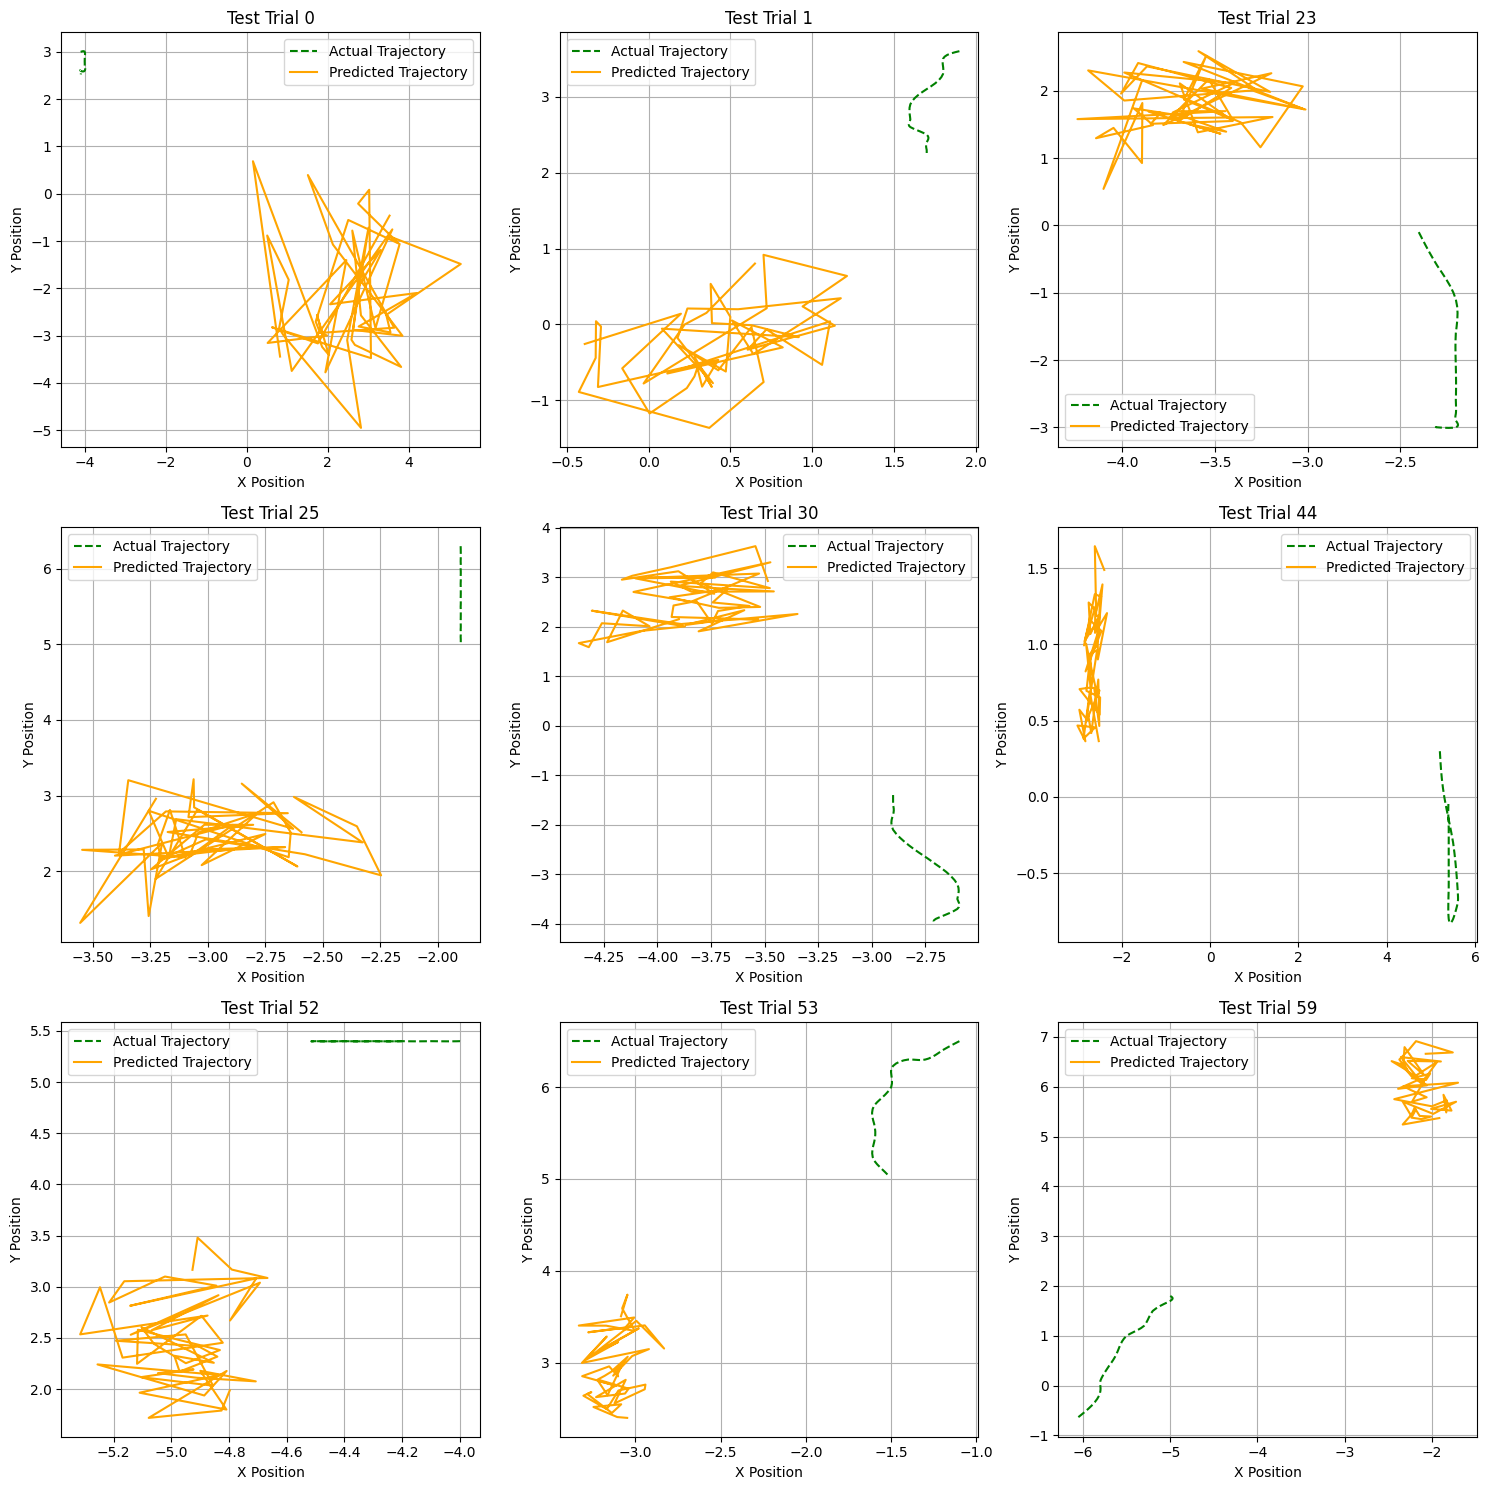

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preprocess all trials
time_steps = 50
num_neurons = 50

input_features = []
output_labels = []

for trial in trial_data:
    features, labels = preprocess_trial_for_cnn(trial, time_steps, num_neurons)
    input_features.append(features)
    output_labels.append(labels)

# Convert to numpy arrays
input_features = np.array(input_features)  # Shape: (num_trials, time_steps, num_neurons)
output_labels = np.array(output_labels)    # Shape: (num_trials, time_steps, 2)

# Split data into training and testing based on trial type
# Split data into training and testing based on trial type
train_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] not in [11, 12]]
test_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] in [11, 12]]

train_inputs, train_labels = input_features[train_indices], output_labels[train_indices]
test_inputs, test_labels = input_features[test_indices], output_labels[test_indices]

# Print dataset shapes
print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Verify split
print(f"Number of training trials: {len(train_indices)}")
print(f"Number of testing trials: {len(test_indices)}")


# Print dataset shapes
print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(train_inputs.shape[1], train_inputs.shape[2])),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(test_labels.shape[-1] * test_labels.shape[1]),  # Output for all time steps
])

# Reshape output labels for compatibility with Dense layer
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 2)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 2, 2)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual = test_labels[i].reshape(-1, 2)
    predicted = predicted_test_labels[i]

    ax = axes[i]
    ax.plot(actual[:, 0], actual[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [5]:
pip install elephant


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from elephant.gpfa import GPFA
import neo
import quantities as pq

bin_size=0.05
# Function to preprocess data into Neo SpikeTrain objects
def preprocess_data_for_gpfa(data, bin_size=0.05):
    """
    Preprocess trials for GPFA:
    - Convert spike timestamps into Neo SpikeTrain objects
    - Align spike data with cursor positions
    """
    spiketrains = []
    cursor_positions = []

    for trial in data:
        spike_data = trial["spike_data"]  # List of lists with spike timestamps
        cursor_pos = np.array(trial["cursor_pos"])  # Cursor positions

        trial_spiketrains = []
        for neuron_spikes in spike_data:
            # Convert spike timestamps to Neo SpikeTrain objects
            spiketrain = neo.SpikeTrain(times=np.array(neuron_spikes) * pq.s,
                                        t_start=0 * pq.s,
                                        t_stop=trial["stop_time"] * pq.s)
            trial_spiketrains.append(spiketrain)

        spiketrains.append(trial_spiketrains)
        cursor_positions.append(cursor_pos)

    return spiketrains, cursor_positions


# Split data into training and testing based on trial type
train_data = [trial for trial in trial_data if trial["trial_type"] not in [11, 12]]
test_data = [trial for trial in trial_data if trial["trial_type"] in [11, 12]]

# Preprocess data for GPFA
train_spikes, train_cursor_positions = preprocess_data_for_gpfa(train_data)
test_spikes, test_cursor_positions = preprocess_data_for_gpfa(test_data)

# Apply GPFA to training data
gpfa_model = GPFA(bin_size=pq.Quantity(bin_size, 's'), x_dim=3)  # 3 latent dimensions
gpfa_results = gpfa_model.fit(train_spikes)  # Train GPFA model

# Decode trajectories using inferred latent variables
def decode_latent_to_trajectory(latents, scaling_factor=10.0):
    """
    Decode latent variables to trajectories for visualization.
    This assumes a linear mapping from latent space to cursor space.
    """
    return np.cumsum(latents * scaling_factor, axis=0)

# Decode test trajectories
predicted_trajectories = []
for test_trial in test_spikes:
    # Transform the test data to latent space
    latents = gpfa_model.transform([test_trial])[0]  # Latent variables

    # Decode latent variables into trajectories
    decoded_trajectory = decode_latent_to_trajectory(latents)
    predicted_trajectories.append(decoded_trajectory)

# Plot actual vs. predicted trajectories for test trials
n_trials_to_plot = min(len(test_data), 9)  # Plot up to 9 test trials
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid
axes = axes.flatten()

for i in range(n_trials_to_plot):
    ax = axes[i]

    actual_trajectory = np.array(test_cursor_positions[i])
    predicted_trajectory = predicted_trajectories[i]

    ax.plot(actual_trajectory[:, 0], actual_trajectory[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], label="Predicted Trajectory", color="orange")

    ax.set_title(f"Test Trial {test_data[i]['trial_id']}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [29]:
pip install neo


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess trial data
def preprocess_trial_for_cnn(trial, time_steps, num_neurons):
    # Extract spike data and position
    spikes = trial["spike_data"]
    positions = trial["pos"]

    # Calculate velocity from positional data
    velocity = []
    for i in range(1, len(positions)):
        v = [positions[i][0] - positions[i - 1][0], positions[i][1] - positions[i - 1][1]]
        velocity.append(v)
    velocity = np.array(velocity)

    # Truncate data to match time steps
    spikes = np.array(spikes[:time_steps]).T[:num_neurons, :time_steps]  # Shape: (num_neurons, time_steps)
    positions = np.array(positions[:time_steps])
    velocity = np.pad(velocity, ((1, 0), (0, 0)), mode='constant')[:time_steps]  # Align with time steps

    # Concatenate velocity to positional data
    labels = np.concatenate([positions, velocity], axis=1)  # Shape: (time_steps, 4)

    return spikes.T, labels  # Shape: (time_steps, num_neurons), (time_steps, 4)

# Preprocess all trials
time_steps = 50
num_neurons = 50

input_features = []
output_labels = []

for trial in trial_data:
    features, labels = preprocess_trial_for_cnn(trial, time_steps, num_neurons)
    input_features.append(features)
    output_labels.append(labels)

# Convert to numpy arrays
input_features = np.array(input_features)  # Shape: (num_trials, time_steps, num_neurons)
output_labels = np.array(output_labels)    # Shape: (num_trials, time_steps, 4)

# Split data into training and testing based on trial type
train_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] not in [11, 12]]
test_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] in [11, 12]]

train_inputs, train_labels = input_features[train_indices], output_labels[train_indices]
test_inputs, test_labels = input_features[test_indices], output_labels[test_indices]

print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Define CNN model
input_spikes = Input(shape=(train_inputs.shape[1], train_inputs.shape[2]), name="spikes")
x = Conv1D(64, kernel_size=3, activation='relu')(input_spikes)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_labels.shape[1] * train_labels.shape[2], activation='linear')(x)  # Predict for all time steps

# Create and compile the model
model = Model(inputs=input_spikes, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Reshape output labels for training compatibility
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Train the model
model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 4)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 4, 4)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual_positions = test_labels[i].reshape(-1, 4)[:, :2]  # Extract positions
    predicted_positions = predicted_test_labels[i][:, :2]

    ax = axes[i]
    ax.plot(actual_positions[:, 0], actual_positions[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


KeyError: 'pos'

Train Inputs: (78, 50, 50), Train Labels: (78, 50, 4)
Test Inputs: (22, 50, 50), Test Labels: (22, 50, 4)
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - loss: 419.4846 - mae: 13.2613 - val_loss: 17.4674 - val_mae: 3.0649
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 17.6955 - mae: 2.8866 - val_loss: 7.2935 - val_mae: 1.6918
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 9.0489 - mae: 1.7948 - val_loss: 6.9090 - val_mae: 1.5884
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 8.5698 - mae: 1.7056 - val_loss: 6.8697 - val_mae: 1.5650
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8.7632 - mae: 1.7033 - val_loss: 6.8671 - val_mae: 1.5649
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.4025 - mae: 1.6997 - val_loss: 6.8644 - val_mae: 1.5647
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.5777 - mae: 1.7119 - val_loss: 6.8617 - val_mae: 1.5645
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 8.3606 - mae: 1.7106 - va

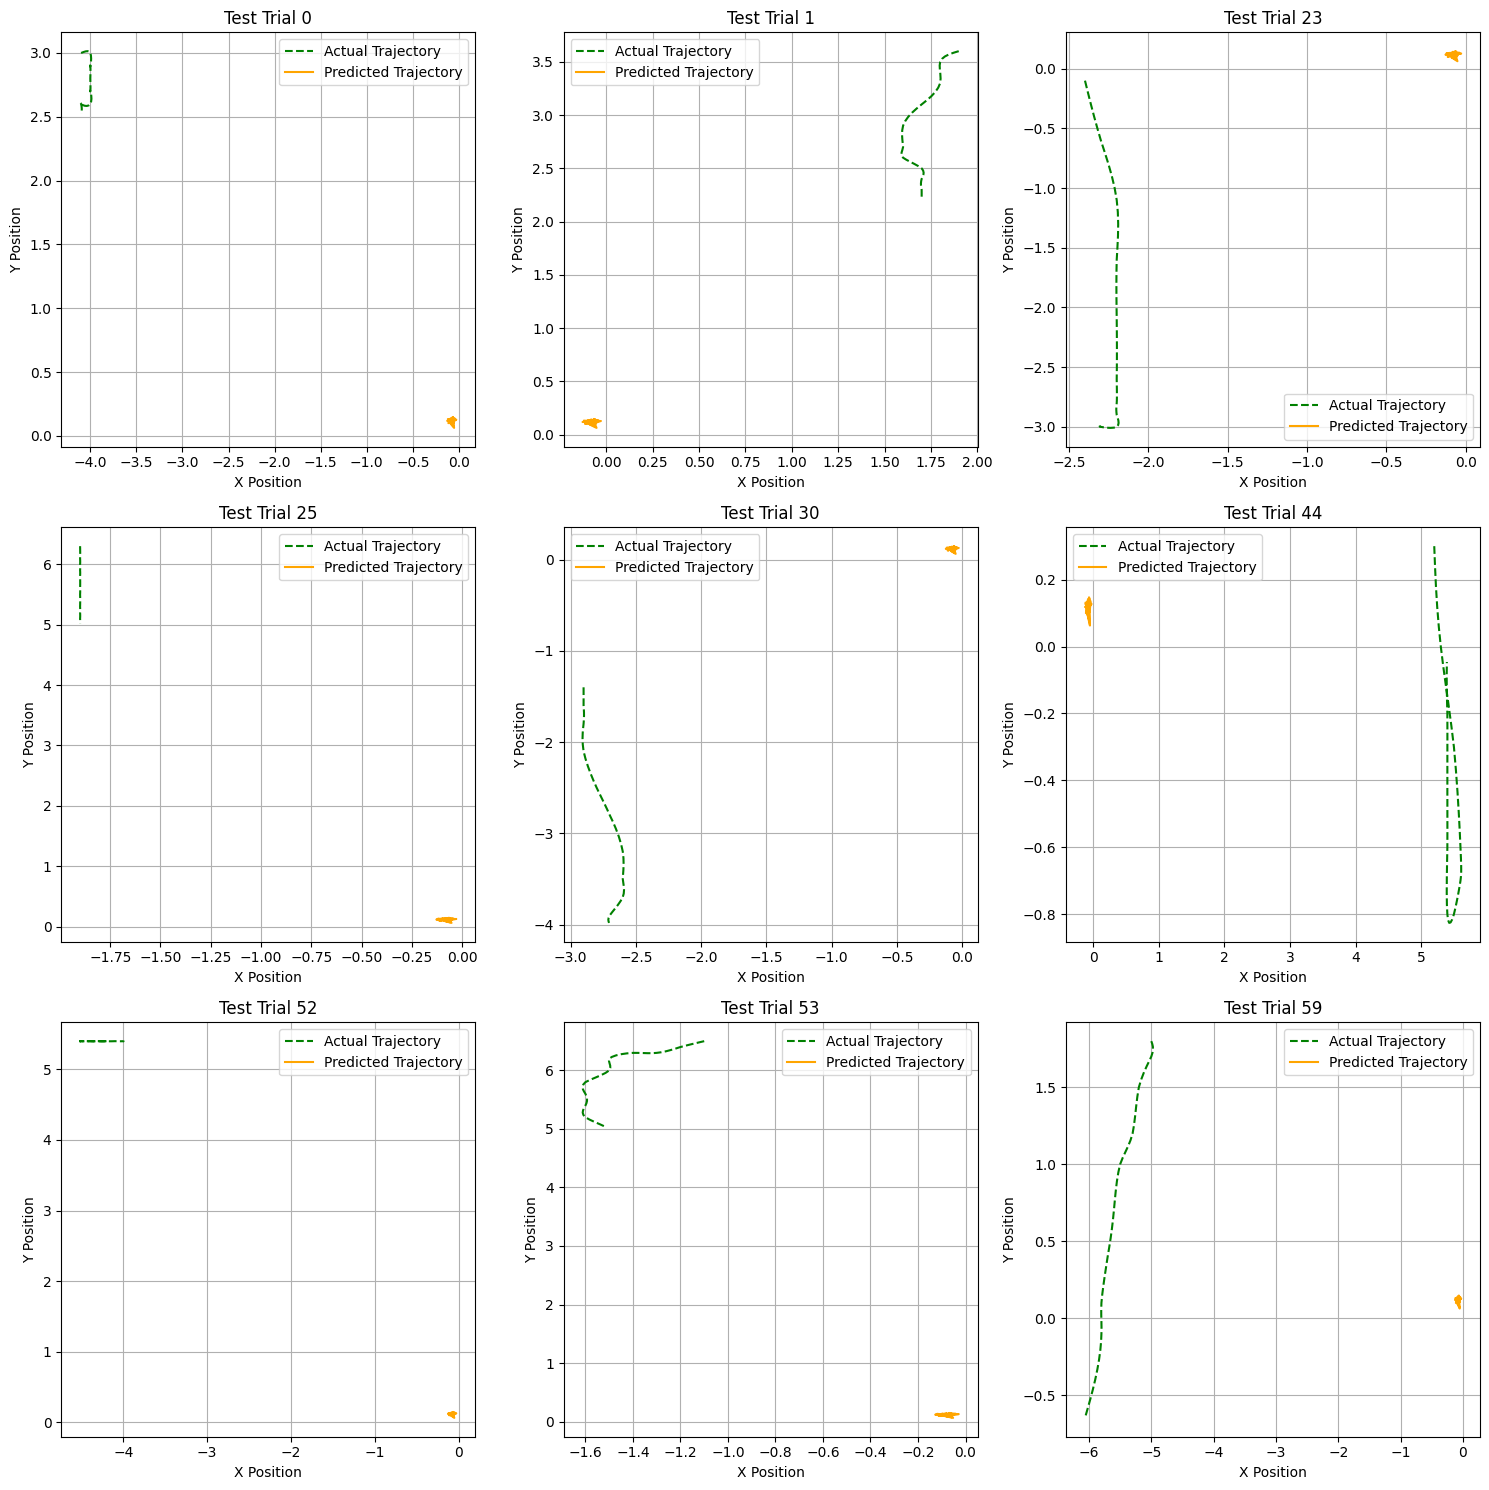

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess trial data
def preprocess_trial_for_cnn(trial, time_steps, num_neurons):
    # Extract spike data and positional data
    spikes = trial.get("spike_data", [])
    positions = trial.get("cursor_pos", [])

    if not positions:  # Handle missing cursor_pos
        raise ValueError(f"Missing 'cursor_pos' data in trial: {trial}")

    # Pad or truncate spikes to have a consistent number of neurons and time steps
    spikes = [np.array(neuron_spikes) for neuron_spikes in spikes]
    if len(spikes) < num_neurons:
        spikes += [np.zeros(time_steps)] * (num_neurons - len(spikes))  # Pad with zeros
    spikes = spikes[:num_neurons]  # Truncate to num_neurons
    spikes = np.array([np.pad(neuron, (0, max(0, time_steps - len(neuron))), 'constant')[:time_steps] for neuron in spikes])

    # Pad or truncate positions to match time_steps
    positions = np.array(positions)
    if len(positions) < time_steps:
        positions = np.pad(positions, ((0, time_steps - len(positions)), (0, 0)), 'constant')
    positions = positions[:time_steps]

    # Calculate velocity from positions
    velocity = np.zeros_like(positions)
    velocity[1:] = positions[1:] - positions[:-1]

    # Concatenate positions and velocity as labels
    labels = np.concatenate([positions, velocity], axis=1)  # Shape: (time_steps, 4)

    return spikes.T, labels  # Shape: (time_steps, num_neurons), (time_steps, 4)


# Preprocess all trials
time_steps = 50
num_neurons = 50

input_features = []
output_labels = []

for trial in trial_data:
    features, labels = preprocess_trial_for_cnn(trial, time_steps, num_neurons)
    input_features.append(features)
    output_labels.append(labels)

# Convert to numpy arrays
input_features = np.array(input_features)  # Shape: (num_trials, time_steps, num_neurons)
output_labels = np.array(output_labels)    # Shape: (num_trials, time_steps, 4)

# Split data into training and testing based on trial type
train_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] not in [11, 12]]
test_indices = [i for i, trial in enumerate(trial_data) if trial["trial_type"] in [11, 12]]

train_inputs, train_labels = input_features[train_indices], output_labels[train_indices]
test_inputs, test_labels = input_features[test_indices], output_labels[test_indices]

print(f"Train Inputs: {train_inputs.shape}, Train Labels: {train_labels.shape}")
print(f"Test Inputs: {test_inputs.shape}, Test Labels: {test_labels.shape}")

# Define CNN model
input_spikes = Input(shape=(train_inputs.shape[1], train_inputs.shape[2]), name="spikes")
x = Conv1D(64, kernel_size=3, activation='relu')(input_spikes)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_labels.shape[1] * train_labels.shape[2], activation='linear')(x)  # Predict for all time steps

# Create and compile the model
model = Model(inputs=input_spikes, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Reshape output labels for training compatibility
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Train the model
model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 4)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 4, 4)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual_positions = test_labels[i].reshape(-1, 4)[:, :2]  # Extract positions
    predicted_positions = predicted_test_labels[i][:, :2]

    ax = axes[i]
    ax.plot(actual_positions[:, 0], actual_positions[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │          13,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,056 (601.78 KB)

 Trainable params: 154,056 (601.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 9.1442 - mae: 1.7882 - val_loss: 6.7827 - val_mae: 1.5883
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 8.8195 - mae: 1.7514 - val_loss: 6.6558 - val_mae: 1.5869
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - loss: 8.7703 - mae: 1.7487 - val_loss: 6.4571 - val_mae: 1.5780
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 8.1474 - mae: 1.6995 - val_loss: 6.2594 - val_mae: 1.5613
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 7.7190 - mae: 1.6541 - val_loss: 6.0786 - val_mae: 1.5354
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 7.5149 - mae: 1.6159 - val_loss: 5.9142 - val_mae: 1.5042
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 6.3788 - mae: 1.4861 - val_loss: 5.7885 - val_mae: 1.4829
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 6.7548 - mae: 1.5309 - val_loss: 5.7107 - val_mae: 1.4707
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 6.0420 - mae: 1.

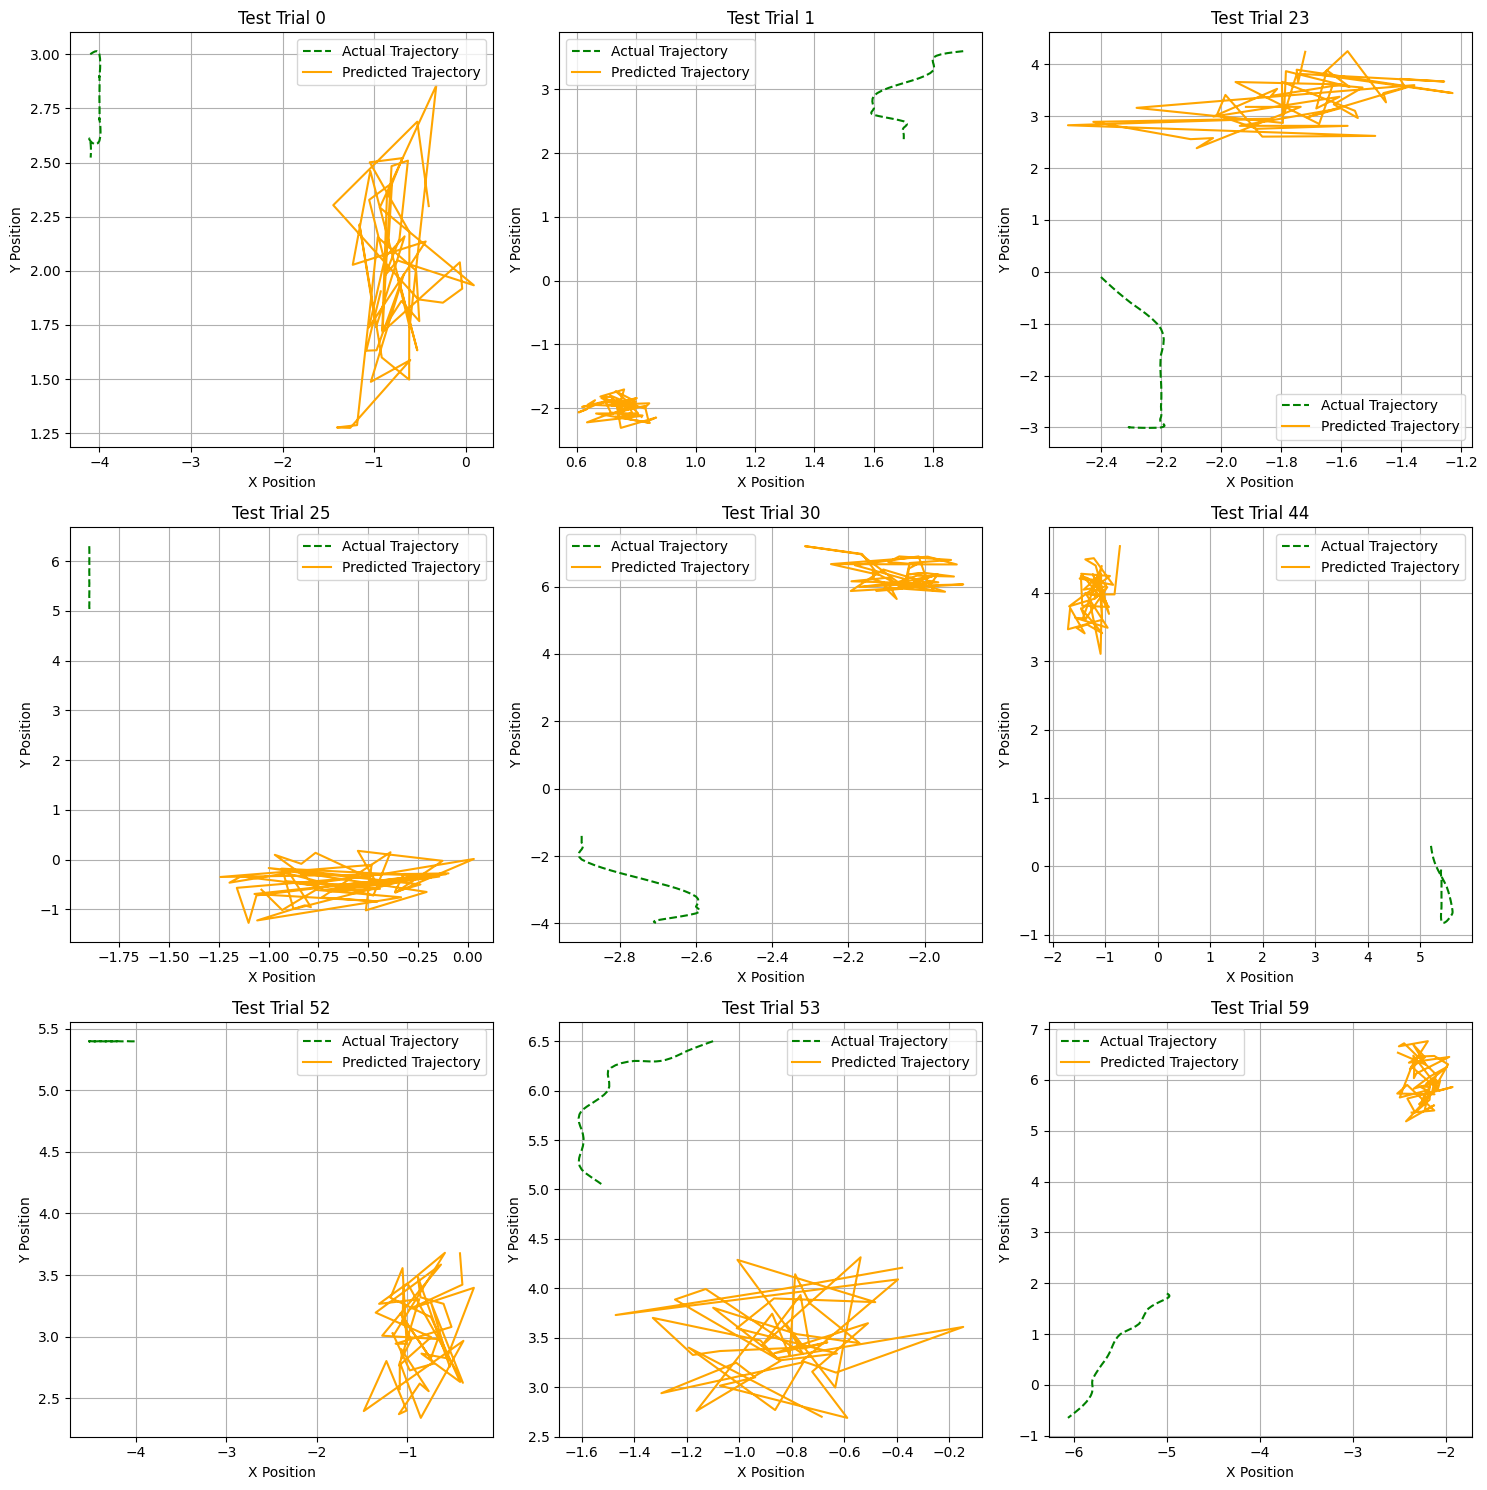

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Define LSTM-based model
model = Sequential([
    LSTM(128, input_shape=(train_inputs.shape[1], train_inputs.shape[2]), return_sequences=True),  # First LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dense(train_labels.shape[1], activation='linear')  # Fully connected layer for output
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

# Reshape the labels for training compatibility
train_labels = train_labels.reshape(train_labels.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Train the LSTM model
history = model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 4)
predicted_test_labels = predicted_test_labels.reshape(-1, test_labels.shape[1] // 4, 4)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)  # Max 9 plots for grid
n_rows = (n_test_trials_to_plot + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual_positions = test_labels[i].reshape(-1, 4)[:, :2]  # Extract positions
    predicted_positions = predicted_test_labels[i][:, :2]

    ax = axes[i]
    ax.plot(actual_positions[:, 0], actual_positions[:, 1], label="Actual Trajectory", linestyle="--", color="green")
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], label="Predicted Trajectory", color="orange")
    ax.set_title(f"Test Trial {test_indices[i]}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 8.6292 - mae: 1.7305 - val_loss: 6.8201 - val_mae: 1.5879
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - loss: 8.6863 - mae: 1.7585 - val_loss: 6.6969 - val_mae: 1.5881
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 8.4986 - mae: 1.7243 - val_loss: 6.4956 - val_mae: 1.5819
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - loss: 7.8216 - mae: 1.6696 - val_loss: 6.2892 - val_mae: 1.5617
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 7.4139 - mae: 1.6225 - val_loss: 6.0958 - val_mae: 1.5310
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - loss: 7.4947 - mae: 1.6325 - val_loss: 5.9212 - val_mae: 1.5025
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 6.6029 - mae: 1.5021 - val_loss: 5.7859 - val_mae: 1.4779
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 6.9883 - mae: 1.5237 - val_loss: 5.6953 - val_mae: 1.4598
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 6.5967 - mae: 1.

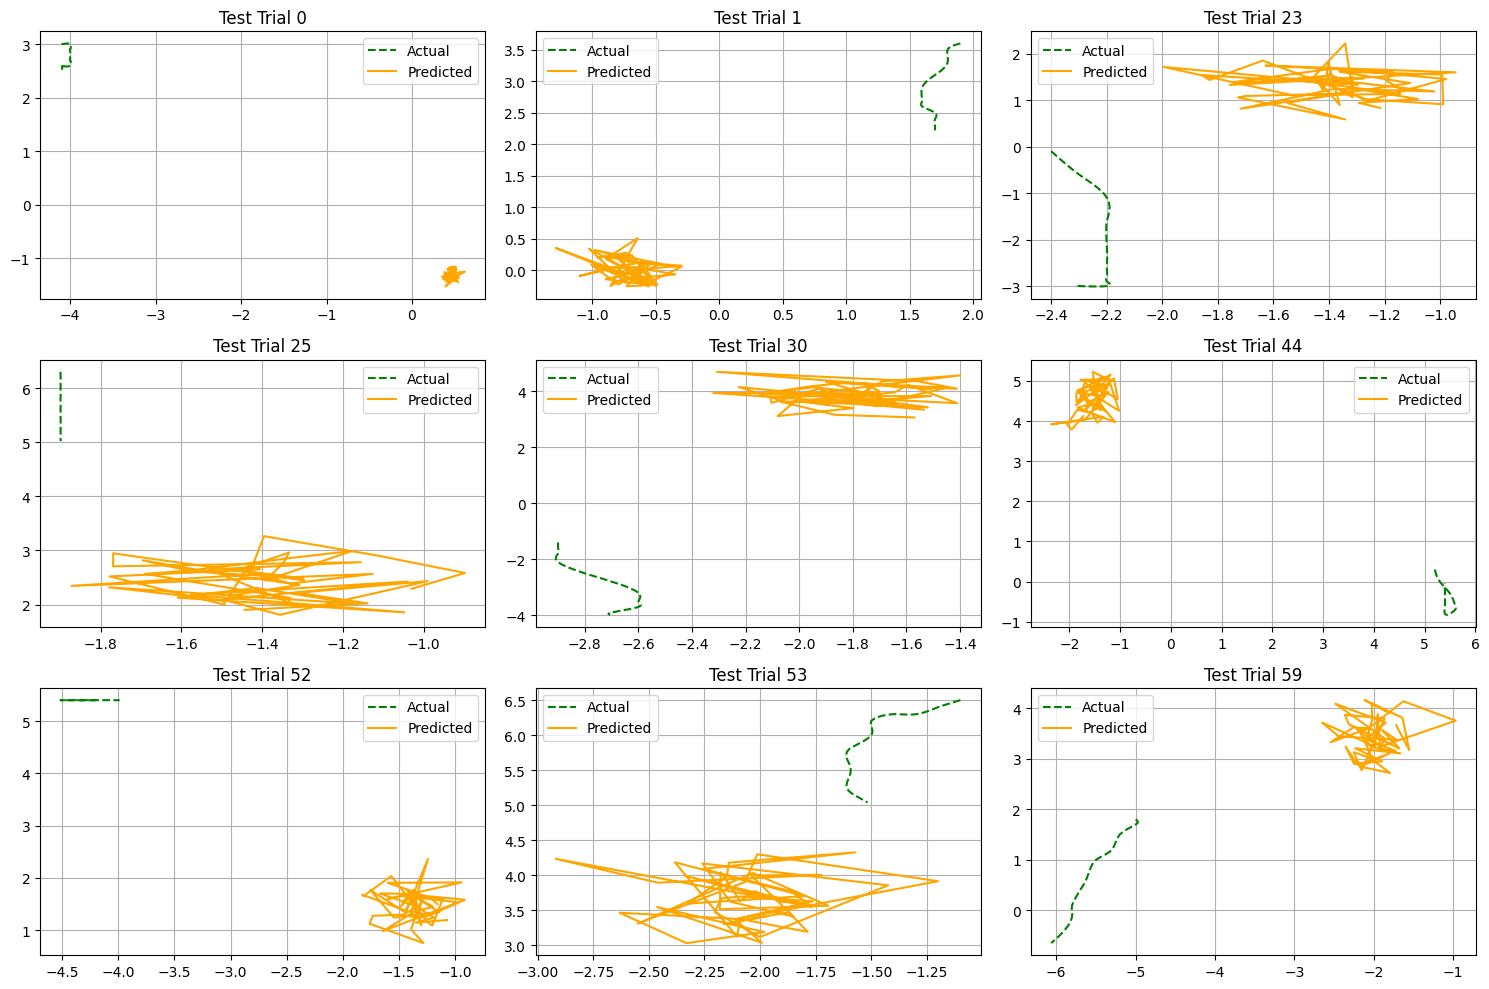

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM-based model
model = Sequential([
    LSTM(128, input_shape=(train_inputs.shape[1], train_inputs.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(train_inputs.shape[1] * 4, activation='linear')  # Output positions and velocities for all time steps
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Reshape labels correctly
train_labels = train_labels.reshape(train_labels.shape[0], train_inputs.shape[1] * 4)  # Flatten to (num_trials, time_steps * 4)
test_labels = test_labels.reshape(test_labels.shape[0], train_inputs.shape[1] * 4)

# Train the model
history = model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=50, batch_size=32)

# Predict on the test set
predicted_test_labels = model.predict(test_inputs)

# Reshape predictions back to (num_trials, time_steps, 4)
predicted_test_labels = predicted_test_labels.reshape(-1, train_inputs.shape[1], 4)

# Plot actual vs predicted trajectories for test trials
n_test_trials_to_plot = min(len(test_indices), 9)
fig, axes = plt.subplots((n_test_trials_to_plot + 2) // 3, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(n_test_trials_to_plot):
    actual = test_labels[i].reshape(-1, 4)[:, :2]  # Extract positions
    predicted = predicted_test_labels[i][:, :2]
    axes[i].plot(actual[:, 0], actual[:, 1], label="Actual", linestyle="--", color="green")
    axes[i].plot(predicted[:, 0], predicted[:, 1], label="Predicted", color="orange")
    axes[i].set_title(f"Test Trial {test_indices[i]}")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


In [14]:
pip install pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.8 MB/s eta 0:00:00
